In [1]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import make_scorer
from skrebate import ReliefF
import warnings
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import OrderedDict
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from imblearn.ensemble import RUSBoostClassifier
from scipy.stats import randint
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import os
import time
from joblib import Parallel
from joblib import delayed
from os import cpu_count
import matplotlib.ticker as ticker
from sklearn.metrics import roc_curve


warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline

# Utils

In [3]:
def plot_roc_curve(test_y, model_probs):
 fpr, tpr, _ = roc_curve(test_y, model_probs)
 plt.title("ROC CURVE")
 plt.plot(fpr, tpr)
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')
 plt.show()
 
# PR curve focuses on the minority class, whereas the ROC curve covers both classes.
def plot_pr_rec_curve(y_test, model_probs):
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    plt.plot(recall, precision)
    plt.title("PRECISION-RECALL CURVE")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
def plot_combined_curves(y_test, model_probs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


    fpr, tpr, _ = roc_curve(y_test, model_probs)
    ax1.plot(fpr, tpr)
    ax1.set_title("ROC Curve")
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')

    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    ax2.plot(recall, precision)
    ax2.set_title("Precision-Recall Curve")
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')

    plt.show()

In [4]:
def plot_heat_map(results_path, plot, output_path):
    """
    Plot a heat-map of the test_score (mean of the test_scores in the nestedk-fold cross validation)
    :param results_path: path to csv of results
    :param plot: if True show heat map
    :param output_path: path to save the image 
    :return: 
    """
    
    data = pd.read_csv(results_path)
    
    data[['Selector', 'Classifier']] = data['combination_id'].str.split('_', expand=True)
    mean_scores = data.groupby(['Selector', 'Classifier'])['test_score'].mean().reset_index()

    pivot_df = mean_scores.pivot(index="Selector", columns="Classifier", values="test_score")

    if plot:
        plt.figure(figsize=(7, 4))
        sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="YlGnBu", vmin=0, vmax=1)

        plt.title("Averaged test scores for selector-classifier combinations")
        
        plt.xticks(rotation=45, ha='right')
        plt.savefig(f"{output_path}/heatmap.jpg")
        plt.show()
        plt.close()

In [5]:
from ast import literal_eval
from collections import Counter


def most_common_features(df_results, max_features, plot=False):
    feature_counts = Counter()
    first_row_dict = literal_eval(df_results['selected_features'].iloc[0])
    
    all_feature_names = list(first_row_dict.keys())

    for run_counts_string in df_results['selected_features']:
        run_counts_dict = literal_eval(run_counts_string)
        for feature in all_feature_names:
            count = run_counts_dict.get(feature, 0)
            feature_counts[feature] += int(count) 
    
    filtered_feature_counts = {feature: count for feature, count in feature_counts.items() if count > 0}
    most_common = Counter(filtered_feature_counts).most_common(max_features)
    if plot:
        plt.figure(figsize=(8, 6)) 
        features, counts = zip(*most_common)
        
        plt.bar(features, counts, color='skyblue')
        plt.ylabel('Counts')
        plt.title('Most selected features')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout() 
        plt.show()
    
    return most_common

# Feature selection and classification
## Drop high correlated features

In [48]:
features_ant_1 = pd.read_csv('../data/anterior/features_1_pix_norm.csv')
len(features_ant_1)

549

In [49]:
features_my_ant = pd.read_csv('../data/anterior/my_df_3sigma_7_norm.csv')
len(features_my_ant)

529

In [6]:
def filter_correlated_features(data, threshold):
    """
    For every pair of correlated features we keep just one
    :param data: 
    :param threshold: 
    :return: 
    """
    corr_matrix = data.corr(method='spearman').abs()

    to_remove = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                to_remove.add(corr_matrix.columns[j])

    return list(to_remove)

In [52]:
to_remove = filter_correlated_features(features_my_ant.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_ant_filtered = features_my_ant.drop(to_remove, axis=1)
features_ant_filtered = features_ant_filtered.drop(['Pixel spacing x','ROI pixels'], axis=1)
features_ant_filtered

Record ID                 Image  Label    GLH_Mean  GLH_Skewness  \
0            1  IMG_20220831_1_3.dcm      0  127.956712     -0.504903   
1            2  IMG_20220908_2_2.dcm      0  128.011818     -0.504543   
2            2  IMG_20220908_2_3.dcm      0  127.845058     -0.504530   
3           12  IMG_20220913_1_1.dcm      0  127.911217     -0.504408   
4           12  IMG_20220913_1_2.dcm      0  127.892888     -0.504408   
..         ...                   ...    ...         ...           ...   
524        361  IMG_20230606_1_3.dcm      0  127.965989     -0.504649   
525        361  IMG_20230606_1_4.dcm      0  127.983057     -0.504660   
526        364  IMG_20230606_1_2.dcm      0  128.024054     -0.504652   
527        364  IMG_20230606_1_3.dcm      0  128.033609     -0.504504   
528        364  IMG_20230606_1_4.dcm      0  127.989633     -0.504541   

     GLH_10Percentile  GLH_25Percentile  GLH_50Percentile  GLH_75Percentile  \
0                17.0              25.0              32.0              39.0   
1                18.0              24.0              31.0              38.0   
2                18.0              24.0              31.0              39.0   
3                18.0              24.0              31.0              38.0   
4                19.0              24.0              31.0              38.0   
..                ...               ...               ...               ...   
524              18.0              24.0              31.0              39.0   
525              18.0              24.0              31.0              38.0   
526              19.0              25.0              31.0              38.0   
527              18.0              24.0              31.0              39.0   
528              18.0              24.0              31.0              38.0   

     GLH_90Percentile  ...  LBP_R_1_P_8_Hist_5  LBP_R_1_P_8_Hist_7  \
0                44.0  ...            0.313229            0.066386   
1                45.0  ...            0.313901            0.078295   
2                45.0  ...            0.355563            0.069144   
3                46.0  ...            0.331858            0.062797   
4                45.0  ...            0.338038            0.065727   
..                ...  ...                 ...                 ...   
524              45.0  ...            0.394534            0.061344   
525              45.0  ...            0.384549            0.064228   
526              45.0  ...            0.400986            0.059981   
527              46.0  ...            0.364948            0.056896   
528              45.0  ...            0.396996            0.059361   

     LBP_R_2_P_16_Hist_4  LBP_R_2_P_16_Hist_14  LBP_R_2_P_16_Hist_17  \
0               0.041681              0.037644              0.054206   
1               0.048055              0.044385              0.051367   
2               0.047002              0.046237              0.044445   
3               0.049890              0.038928              0.053365   
4               0.044915              0.039457              0.048463   
..                   ...                   ...                   ...   
524             0.045875              0.043055              0.038102   
525             0.045487              0.043278              0.036568   
526             0.044503              0.042598              0.037913   
527             0.044726              0.045048              0.044627   
528             0.046291              0.041898              0.038028   

     LBP_R_3_P_24_Hist_4  LBP_R_3_P_24_Hist_5  LBP_R_3_P_24_Hist_22  \
0               0.034435             0.025982              0.028742   
1               0.035143             0.030676              0.032704   
2               0.034824             0.032468              0.036474   
3               0.039507             0.030158              0.030034   
4               0.039059             0.026785              0.033613   
..                   ...                  ...  

# Read datasets

In [8]:
stone_sand = pd.read_csv('../data/dummy/sand_stone.csv')
stone_sand_3sigma = pd.read_csv('../data/dummy/sand_stone_3sigma.csv')
blanket_stone = pd.read_csv('../data/dummy/blanket_stone.csv')
blanket_stone_3sigma = pd.read_csv('../data/dummy/blanket_stone_3sigma.csv')
stone_sand_mask = pd.read_csv('../data/dummy/sand_stone_mask.csv')
stone_sand_mask_3sigma = pd.read_csv('../data/dummy/sand_stone_mask_3sigma.csv')
stone_sand_mask_3sigma_norm = pd.read_csv('../data/dummy/sand_stone_mask_3sigma_norm.csv')
blanket_stone_mask_norm = pd.read_csv('../data/dummy/blanket_stone_mask_norm.csv')
blanket_stone_mask_3sigma_norm = pd.read_csv('../data/dummy/blanket_stone_mask_3sigma_norm.csv')

In [7]:
my_df_3sigma_7_int_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_int_norm.csv')
my_df_3sigma_7_int_pe_norm  = pd.read_csv('../data/anterior/my_df_3sigma_7_int_pe_norm.csv')
my_df_3sigma_7_int_fgr_norm  = pd.read_csv('../data/anterior/my_df_3sigma_7_int_fgr_norm.csv')
my_df_3sigma_6_norm  = pd.read_csv('../data/anterior/my_df_3sigma_6_norm.csv')
my_df_3sigma_7_norm  = pd.read_csv('../data/anterior/my_df_3sigma_7_norm.csv')
my_df_3sigma_7_fgr_norm  = pd.read_csv('../data/anterior/my_df_3sigma_7_fgr_norm.csv')
my_df_3sigma_7_pe_norm  = pd.read_csv('../data/anterior/my_df_3sigma_7_pe_norm.csv')
my_df_3sigma_8_norm  = pd.read_csv('../data/anterior/my_df_3sigma_8_norm.csv')
my_df_3sigma_6_resegment  = pd.read_csv('../data/anterior/my_df_3sigma_6_resegment.csv')
my_df_3sigma_7_resegment  = pd.read_csv('../data/anterior/my_df_3sigma_7_resegment.csv')
my_df_3sigma_7_pe_eq_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_pe_norm_eq.csv')
my_df_3sigma_raw_norm = pd.read_csv('../data/anterior/my_df_3sigma_raw_norm.csv')
my_df_3sigma_raw_fgr_eq_norm = pd.read_csv('../data/anterior/my_df_3sigma_fgr_raw_norm_eq.csv')
my_df_3sigma_raw_pe_eq_norm = pd.read_csv('../data/anterior/my_df_3sigma_pe_raw_norm_eq.csv')
my_df_3sigma_raw_fgr_all_norm = pd.read_csv('../data/all/my_df_3sigma_raw_fgr_norm.csv')
my_df_3sigma_7_fgr_all_norm= pd.read_csv('../data/all/my_df_3sigma_7_fgr_all_norm.csv')
my_df_3sigma_7_fgr_eq_norm = pd.read_csv('../data/anterior/my_df_3sigma_7_fgr_norm_eq.csv')
my_df_3_sigma8_fgr_norm = pd.read_csv('../data/anterior/my_df_3sigma_8_fgr_norm.csv')

features_1_norm= pd.read_csv('../data/anterior/features_1_pix_norm.csv')
features_1_fgr_norm= pd.read_csv('../data/anterior/features_1_fgr_pix_norm.csv')
features_1_pe_norm= pd.read_csv('../data/anterior/features_1_pe_pix_norm.csv')
features_2_norm= pd.read_csv('../data/anterior/features_2_pix_norm.csv')
features_2_fgr_norm= pd.read_csv('../data/anterior/features_2_fgr_pix_norm.csv')
features_2_pe_norm= pd.read_csv('../data/anterior/features_2_pe_pix_norm.csv')
features_3_fgr= pd.read_csv('../data/anterior/features_3_fgr.csv')
features_3_norm= pd.read_csv('../data/anterior/features_3_pix_norm.csv')
features_3_fgr_norm= pd.read_csv('../data/anterior/features_3_fgr_pix_norm.csv')
features_3_fgr_pix_norm_lbp = pd.read_csv('../data/anterior/features_3_fgr_lbp_pix_norm.csv')
features_3_fgr_lbp_all_norm= pd.read_csv('../data/all/features_3_fgr_lbp_pix_norm.csv')
features_3_ant_zscore_fgr_norm = pd.read_csv('../data/anterior/features_3_zscore_fgr_pix_norm.csv')
features_3_pe_norm= pd.read_csv('../data/anterior/features_3_pe_pix_norm.csv')
features_3_fgr_pix_norm_eq = pd.read_csv('../data/anterior/features_3_fgr_pix_norm_eq.csv')
features_3_pe_pix_norm_eq = pd.read_csv('../data/anterior/features_3_pe_pix_norm_eq.csv')
features_3_fgr_pix_norm_eq_lbp = pd.read_csv('../data/anterior/features_3_fgr_pix_norm_eq_lbp.csv')
features_4_norm= pd.read_csv('../data/anterior/features_4_pix_norm.csv')
features_5_fgr_pix_norm_eq = pd.read_csv('../data/anterior/features_5_fgr_pix_norm_eq.csv')
features_5_fgr_pix_norm = pd.read_csv('../data/anterior/features_5_fgr_pix_norm.csv')
features_5_pe_pix_norm_eq = pd.read_csv('../data/anterior/features_5_pe_pix_norm_eq.csv')
features_5_fgr_pix_norm_eq_lbp = pd.read_csv('../data/anterior/features_5_fgr_pix_norm_eq_lbp.csv')
features_5_pe_pix_norm_eq_lbp = pd.read_csv('../data/anterior/features_5_pe_pix_norm_eq_lbp.csv')
features_5_norm= pd.read_csv('../data/anterior/features_5_pix_norm.csv')
features_5_pe_pix_norm = pd.read_csv('../data/anterior/features_5_pe_pix_norm.csv')
features_6_norm= pd.read_csv('../data/anterior/features_6_pix_norm.csv')
features_7_norm= pd.read_csv('../data/anterior/features_7_pix_norm.csv')
features_8_norm= pd.read_csv('../data/anterior/features_8_pix_norm.csv')
features_8= pd.read_csv('../data/anterior/features_8.csv')
features_9_norm= pd.read_csv('../data/anterior/features_9_pix_norm.csv')
features_10_fgr_norm= pd.read_csv('../data/anterior/features_10_fgr_norm.csv')
features_11_ant_fgr_norm= pd.read_csv('../data/anterior/features_11_fgr_pix_norm.csv')
features_11_all_norm= pd.read_csv('../data/all/features_11_pix_norm.csv')
features_11_all_fgr_norm= pd.read_csv('../data/all/features_11_fgr_pix_norm.csv')
features_12_fgr_pix_norm = pd.read_csv('../data/anterior/features_12_fgr_pix_norm.csv')
features_13_norm = pd.read_csv('../data/anterior/features_13_pix_norm.csv')
features_14_norm = pd.read_csv('../data/anterior/features_14_pix_norm.csv')

lbp= pd.read_csv('../data/anterior/lbp.csv')
lbp_norm= pd.read_csv('../data/anterior/lbp_norm.csv')
lbp_int_norm= pd.read_csv('../data/anterior/lbp_int_norm.csv')
lbp_pe_norm= pd.read_csv('../data/anterior/lbp_pe_norm.csv')
lbp_fgr_norm= pd.read_csv('../data/anterior/lbp_fgr_norm.csv')

both_features_1_norm = pd.read_csv('../data/both/features_1_pix_norm.csv')
both_features_2_norm = pd.read_csv('../data/both/features_2_pix_norm.csv')
both_features_4_norm = pd.read_csv('../data/both/features_4_pix_norm.csv')
both_features_5_norm = pd.read_csv('../data/both/features_5_pix_norm.csv')
both_features_8_norm = pd.read_csv('../data/both/features_8_pix_norm.csv')
both_features_9_norm = pd.read_csv('../data/both/features_9_pix_norm.csv')
both_my_df_3sigma_7_norm = pd.read_csv('../data/both/my_df_3sigma_7_norm_filtered.csv')

Prepare filtered dataframe:

In [9]:
to_remove = filter_correlated_features(my_df_3sigma_raw_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_raw_norm_filtered = my_df_3sigma_raw_norm.drop(to_remove, axis=1)

In [10]:
to_remove = filter_correlated_features(features_3_fgr_pix_norm_lbp.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_fgr_pix_norm_lbp_filtered = features_3_fgr_pix_norm_lbp.drop(to_remove, axis=1)

In [12]:
to_remove = filter_correlated_features(features_10_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_10_fgr_norm_filtered = features_10_fgr_norm.drop(to_remove, axis=1)

In [13]:
to_remove = filter_correlated_features(features_3_fgr_lbp_all_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_fgr_lbp_all_norm_filtered = features_3_fgr_lbp_all_norm.drop(to_remove, axis=1)

In [15]:
to_remove = filter_correlated_features(my_df_3sigma_raw_fgr_all_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_raw_fgr_all_norm_filtered = my_df_3sigma_raw_fgr_all_norm.drop(to_remove, axis=1)

In [16]:
to_remove = filter_correlated_features(my_df_3sigma_7_fgr_all_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_fgr_all_norm_filtered = my_df_3sigma_7_fgr_all_norm.drop(to_remove, axis=1)

In [17]:
to_remove = filter_correlated_features(my_df_3sigma_6_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_6_norm_filtered = my_df_3sigma_6_norm.drop(to_remove, axis=1)

In [18]:
to_remove = filter_correlated_features(my_df_3sigma_7_int_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_int_norm_filtered = my_df_3sigma_7_int_norm.drop(to_remove, axis=1)

In [19]:
to_remove = filter_correlated_features(my_df_3sigma_7_int_pe_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_int_pe_norm_filtered = my_df_3sigma_7_int_pe_norm.drop(to_remove, axis=1)

In [20]:
to_remove = filter_correlated_features(my_df_3sigma_7_int_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_int_fgr_norm_filtered = my_df_3sigma_7_int_fgr_norm.drop(to_remove, axis=1)

In [21]:
to_remove = filter_correlated_features(my_df_3sigma_7_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_norm_filtered = my_df_3sigma_7_norm.drop(to_remove, axis=1)

In [22]:
to_remove = filter_correlated_features(my_df_3sigma_7_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_fgr_norm_filtered = my_df_3sigma_7_fgr_norm.drop(to_remove, axis=1)

In [23]:
to_remove = filter_correlated_features(my_df_3sigma_7_pe_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_pe_norm_filtered = my_df_3sigma_7_pe_norm.drop(to_remove, axis=1)

In [24]:
to_remove = filter_correlated_features(my_df_3sigma_8_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_8_norm_filtered = my_df_3sigma_8_norm.drop(to_remove, axis=1)

In [25]:
to_remove = filter_correlated_features(features_1_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_1_norm_filtered = features_1_norm.drop(to_remove, axis=1)

In [26]:
to_remove = filter_correlated_features(features_1_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_1_fgr_norm_filtered = features_1_fgr_norm.drop(to_remove, axis=1)

In [27]:
to_remove = filter_correlated_features(features_1_pe_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_1_pe_norm_filtered = features_1_pe_norm.drop(to_remove, axis=1)

In [28]:
to_remove = filter_correlated_features(features_2_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_2_norm_filtered = features_2_norm.drop(to_remove, axis=1)

In [29]:
to_remove = filter_correlated_features(features_2_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_2_fgr_norm_filtered = features_2_fgr_norm.drop(to_remove, axis=1)

In [30]:
to_remove = filter_correlated_features(features_2_pe_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_2_pe_norm_filtered = features_2_pe_norm.drop(to_remove, axis=1)

In [31]:
to_remove = filter_correlated_features(features_3_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_norm_filtered = features_3_norm.drop(to_remove, axis=1)

In [32]:
to_remove = filter_correlated_features(features_3_pe_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_pe_norm_filtered = features_3_pe_norm.drop(to_remove, axis=1)

In [33]:
to_remove = filter_correlated_features(features_3_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_fgr_norm_filtered = features_3_fgr_norm.drop(to_remove, axis=1)

In [34]:
to_remove = filter_correlated_features(features_4_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_4_norm_filtered = features_4_norm.drop(to_remove, axis=1)

In [35]:
to_remove = filter_correlated_features(features_5_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_5_norm_filtered = features_5_norm.drop(to_remove, axis=1)

In [36]:
to_remove = filter_correlated_features(features_6_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_6_norm_filtered = features_6_norm.drop(to_remove, axis=1)

In [37]:
to_remove = filter_correlated_features(features_7_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_7_norm_filtered = features_7_norm.drop(to_remove, axis=1)

In [38]:
to_remove = filter_correlated_features(features_8_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_8_norm_filtered = features_8_norm.drop(to_remove, axis=1)

In [39]:
to_remove = filter_correlated_features(features_9_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_9_norm_filtered = features_9_norm.drop(to_remove, axis=1)

In [40]:
to_remove = filter_correlated_features(features_13_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_13_norm_filtered = features_13_norm.drop(to_remove, axis=1)

In [41]:
to_remove = filter_correlated_features(features_14_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_14_norm_filtered = features_14_norm.drop(to_remove, axis=1)

In [42]:
to_remove = filter_correlated_features(both_features_1_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
both_features_1_norm_filtered = both_features_1_norm.drop(to_remove, axis=1)

In [43]:
to_remove = filter_correlated_features(both_features_2_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
both_features_2_norm_filtered = both_features_2_norm.drop(to_remove, axis=1)

In [44]:
to_remove = filter_correlated_features(both_features_4_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
both_features_4_norm_filtered = both_features_4_norm.drop(to_remove, axis=1)

In [45]:
to_remove = filter_correlated_features(both_features_5_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
both_features_5_norm_filtered = both_features_5_norm.drop(to_remove, axis=1)

In [46]:
to_remove = filter_correlated_features(both_features_8_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
both_features_8_norm_filtered = both_features_8_norm.drop(to_remove, axis=1)

In [47]:
to_remove = filter_correlated_features(both_features_9_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
both_features_9_norm_filtered = both_features_9_norm.drop(to_remove, axis=1)

In [48]:
to_remove = filter_correlated_features(lbp_int_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
lbp_int_norm_filtered = lbp_int_norm.drop(to_remove, axis=1)

In [49]:
to_remove = filter_correlated_features(lbp.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
lbp_filtered = lbp.drop(to_remove, axis=1)

In [50]:
to_remove = filter_correlated_features(lbp_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
lbp_norm_filtered = lbp_norm.drop(to_remove, axis=1)

In [51]:
to_remove = filter_correlated_features(lbp_pe_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
lbp_pe_norm_filtered = lbp_pe_norm.drop(to_remove, axis=1)

In [52]:
to_remove = filter_correlated_features(lbp_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
lbp_fgr_norm_filtered = lbp_fgr_norm.drop(to_remove, axis=1)

In [53]:
to_remove = filter_correlated_features(features_8.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_8_filtered = features_8.drop(to_remove, axis=1)

In [54]:
to_remove = filter_correlated_features(my_df_3sigma_6_resegment.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_6_resegment_filtered = my_df_3sigma_6_resegment.drop(to_remove, axis=1)

In [55]:
to_remove = filter_correlated_features(my_df_3sigma_7_resegment.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_resegment_filtered = my_df_3sigma_7_resegment.drop(to_remove, axis=1)

In [56]:
to_remove = filter_correlated_features(both_my_df_3sigma_7_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
both_my_df_3sigma_7_norm_filtered = both_my_df_3sigma_7_norm.drop(to_remove, axis=1)

In [57]:
to_remove = filter_correlated_features(features_3_fgr.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_fgr_filtered = features_3_fgr.drop(to_remove, axis=1)

In [58]:
to_remove = filter_correlated_features(features_11_all_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_11_all_fgr_norm_filtered = features_11_all_fgr_norm.drop(to_remove, axis=1)

In [59]:
to_remove = filter_correlated_features(features_11_ant_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_11_ant_fgr_norm_filtered = features_11_ant_fgr_norm.drop(to_remove, axis=1)

In [60]:
to_remove = filter_correlated_features(features_11_all_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_11_all_norm_filtered = features_11_all_norm.drop(to_remove, axis=1)

In [61]:
to_remove = filter_correlated_features(features_12_fgr_pix_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_12_fgr_pix_norm_filtered = features_12_fgr_pix_norm.drop(to_remove, axis=1)

In [62]:
to_remove = filter_correlated_features(features_3_ant_zscore_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_ant_zscore_fgr_norm_filtered = features_3_ant_zscore_fgr_norm.drop(to_remove, axis=1)

In [63]:
to_remove = filter_correlated_features(my_df_3_sigma8_fgr_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3_sigma8_fgr_norm_filtered = my_df_3_sigma8_fgr_norm.drop(to_remove, axis=1)

In [64]:
to_remove = filter_correlated_features(stone_sand_mask.drop(['Record ID','Label','Image','ROI pixels'], axis=1), 0.8)
stone_sand_mask_filtered = stone_sand_mask.drop(to_remove, axis=1)

In [65]:
to_remove = filter_correlated_features(stone_sand_mask_3sigma_norm.drop(['Record ID','Label','Image','ROI pixels'], axis=1), 0.8)
stone_sand_mask_3sigma_norm_filtered = stone_sand_mask_3sigma_norm.drop(to_remove, axis=1)

In [66]:
to_remove = filter_correlated_features(blanket_stone_3sigma.drop(['Record ID','Label','Image'], axis=1), 0.8)
blanket_stone_3sigma_filtered = blanket_stone_3sigma.drop(to_remove, axis=1)

In [67]:
to_remove = filter_correlated_features(blanket_stone_mask_norm.drop(['Record ID','Label','Image','ROI pixels'], axis=1), 0.8)
blanket_stone_mask_norm_filtered = blanket_stone_mask_norm.drop(to_remove, axis=1)

In [68]:
to_remove = filter_correlated_features(blanket_stone_mask_3sigma_norm.drop(['Record ID','Label','Image','ROI pixels'], axis=1), 0.8)
blanket_stone_mask_3sigma_norm_filtered = blanket_stone_mask_3sigma_norm.drop(to_remove, axis=1)

In [69]:
to_remove = filter_correlated_features(features_3_fgr_pix_norm_eq.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_fgr_pix_norm_eq_filtered = features_3_fgr_pix_norm_eq.drop(to_remove, axis=1)

In [70]:
to_remove = filter_correlated_features(features_3_pe_pix_norm_eq.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_pe_pix_norm_eq_filtered = features_3_pe_pix_norm_eq.drop(to_remove, axis=1)

In [71]:
to_remove = filter_correlated_features(features_5_fgr_pix_norm_eq.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_5_fgr_pix_norm_eq_filtered = features_5_fgr_pix_norm_eq.drop(to_remove, axis=1)

In [72]:
to_remove = filter_correlated_features(features_5_fgr_pix_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_5_fgr_pix_norm_filtered = features_5_fgr_pix_norm.drop(to_remove, axis=1)

In [73]:
to_remove = filter_correlated_features(features_5_pe_pix_norm_eq.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_5_pe_pix_norm_eq_filtered = features_5_pe_pix_norm_eq.drop(to_remove, axis=1)

In [74]:
to_remove = filter_correlated_features(features_5_fgr_pix_norm_eq_lbp.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_5_fgr_pix_norm_eq_filtered_lbp = features_5_fgr_pix_norm_eq_lbp.drop(to_remove, axis=1)

In [75]:
to_remove = filter_correlated_features(features_5_pe_pix_norm_eq_lbp.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_5_pe_pix_norm_eq_filtered_lbp = features_5_pe_pix_norm_eq_lbp.drop(to_remove, axis=1)

In [76]:
to_remove = filter_correlated_features(my_df_3sigma_raw_fgr_eq_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_raw_fgr_eq_norm_filtered = my_df_3sigma_raw_fgr_eq_norm.drop(to_remove, axis=1)

In [77]:
to_remove = filter_correlated_features(my_df_3sigma_raw_pe_eq_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_raw_pe_eq_norm_filtered = my_df_3sigma_raw_pe_eq_norm.drop(to_remove, axis=1)

In [78]:
to_remove = filter_correlated_features(features_3_fgr_pix_norm_eq_lbp.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
features_3_fgr_pix_norm_eq_lbp_filtered = features_3_fgr_pix_norm_eq_lbp.drop(to_remove, axis=1)

In [79]:
to_remove = filter_correlated_features(my_df_3sigma_7_fgr_eq_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_fgr_eq_norm_filtered = my_df_3sigma_7_fgr_eq_norm.drop(to_remove, axis=1)

In [80]:
to_remove = filter_correlated_features(my_df_3sigma_7_pe_eq_norm.drop(['Record ID','Label','Image','Pixel spacing x','ROI pixels'], axis=1), 0.8)
my_df_3sigma_7_pe_eq_norm_filtered = my_df_3sigma_7_pe_eq_norm.drop(to_remove, axis=1)

# Best selector and model

In [81]:
#Definition of the score (we have imbalanced data and the important class is minority)
def auc_pr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

## AutoML
We'll try to find a good combination of feature selector and model in this imbalanced data, using k-fold cv with RandomSearch to search the best hyperparameters.

In [82]:
def get_feature_votes(selector_name, selector, features_list):
    feature_votes = {feature: 0 for feature in features_list}
    
    if selector_name == VarianceThreshold.__name__ or selector_name == SelectKBest.__name__:
        features_selected_mask  = selector.get_support()
        for idx, is_selected in enumerate(features_selected_mask):
            if is_selected:
                selected_feature = features_list[idx]
                feature_votes[selected_feature] = 1

    else: 
        selector_array = selector.top_features_
        num = selector.n_features_to_select
    
        for i, idx in enumerate(selector_array):
            if i < num:
                selected_feature = features_list[idx]
                feature_votes[selected_feature] = 1
   
    return feature_votes

def merge_dict(dict1, dict2):
    merged = dict1.copy()
    merged.update(dict2)
   
    return merged

In [21]:
import imblearn
print(imblearn.__version__)

0.11.0


In [83]:
from sklearn.feature_selection import SelectKBest
from imblearn.ensemble import BalancedRandomForestClassifier
from skrebate import MultiSURF
from sklearn.svm import SVC
from scipy.stats import uniform

def get_lists(random_state):
    
    params_dict= {
       
        'SVM': {'SVC__C': uniform(1,10),
                'SVC__kernel': ['linear', 'rbf'],
                'SVC__gamma': ['scale', 'auto', 0.1, 1.0, 10.0]},
    
        'RANDOM_FOREST': {'BalancedRandomForestClassifier__n_estimators': randint(10, 350),
                          'BalancedRandomForestClassifier__criterion': ['gini', 'entropy'],
                          'BalancedRandomForestClassifier__max_depth': randint(3, 27),
                          'BalancedRandomForestClassifier__min_samples_split': randint(2, 15),
                          'BalancedRandomForestClassifier__min_samples_leaf': [1],
                          'BalancedRandomForestClassifier__max_features': [9, 11, 13, 15],
                          'BalancedRandomForestClassifier__sampling_strategy': ['not minority']},

        'RUSBOOST': {
            'RUSBoostClassifier__n_estimators': [50, 100, 500],
            'RUSBoostClassifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
            'RUSBoostClassifier__sampling_strategy': ['not minority']
        },
    
        "RELIEFF": {
            "ReliefF__n_neighbors": randint(1, 5),
            "ReliefF__n_features_to_select": randint(5, 10),
        },
        
        "MULTISURF": {
            "MultiSURF__n_features_to_select": randint(5, 10)
        },
        
        
        "VARTH": {
            "VarianceThreshold__threshold": uniform(0, 0.5)
        },
        
        "KBEST": {
            "SelectKBest__k": randint(5, 10)
        }
        
    }
    
    #classifiers
    rus_param = params_dict['RUSBOOST']
    svm_param = params_dict['SVM']
    rf_param = params_dict['RANDOM_FOREST']
    
    # selectors
    relieff_param = params_dict['RELIEFF']
    multi_surf_param = params_dict["MULTISURF"]
    var_t_param = params_dict["VARTH"]
    kbest_param = params_dict["KBEST"]

    selector_dict = dict()
    selector_dict[VarianceThreshold.__name__] = (VarianceThreshold.__name__, VarianceThreshold()), var_t_param
    selector_dict[ReliefF.__name__] = (ReliefF.__name__,ReliefF()), relieff_param
    selector_dict[MultiSURF.__name__] = (MultiSURF.__name__, MultiSURF()), multi_surf_param
    selector_dict[SelectKBest.__name__] = (SelectKBest.__name__, SelectKBest(mutual_info_classif)), kbest_param
    
    classifier_dict = dict()
    classifier_dict[RUSBoostClassifier.__name__] = (RUSBoostClassifier.__name__,RUSBoostClassifier(random_state=random_state)), rus_param
    # class_weight='balanced' in SVC: weights are adjusted inversely proportional to the class frequencies
    classifier_dict[SVC.__name__] = (SVC.__name__, SVC(probability=True, random_state=random_state,class_weight='balanced')), svm_param
    classifier_dict[BalancedRandomForestClassifier.__name__] = (BalancedRandomForestClassifier.__name__, BalancedRandomForestClassifier(random_state=random_state)), rf_param
    
    return selector_dict, classifier_dict

In [84]:
def get_lists2(random_state):
    
    params_dict= {
       
        'KNN': {
             'KNeighborsClassifier__n_neighbors': randint(1, 10), 
             'KNeighborsClassifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  
        },
        
        'SVM': {'SVC__C': uniform(1,10),
                'SVC__kernel': ['linear', 'rbf'],
                'SVC__gamma': ['scale', 'auto', 0.1, 1.0, 10.0]},
    
        'RANDOM_FOREST': {'RandomForestClassifier__n_estimators': randint(10, 350),
                          'RandomForestClassifier__criterion': ['gini', 'entropy'],
                          'RandomForestClassifier__max_depth': randint(3, 27),
                          'RandomForestClassifier__min_samples_split': randint(2, 15),
                          'RandomForestClassifier__min_samples_leaf': [1],
                          'RandomForestClassifier__max_features': [9, 11, 13, 15]},

        "RELIEFF": {
            "ReliefF__n_neighbors": randint(1, 5),
            "ReliefF__n_features_to_select": randint(5, 10),
        },
        
        "MULTISURF": {
            "MultiSURF__n_features_to_select": randint(5, 10)
        },
        
        
        "VARTH": {
            "VarianceThreshold__threshold": uniform(0, 0.5)
        },
        
        "KBEST": {
            "SelectKBest__k": randint(5, 10)
        }
        
    }
    
    #classifiers
    svm_param = params_dict['SVM']
    rf_param = params_dict['RANDOM_FOREST']
    knn_param = params_dict['KNN']
    
    # selectors
    relieff_param = params_dict['RELIEFF']
    multi_surf_param = params_dict["MULTISURF"]
    var_t_param = params_dict["VARTH"]
    kbest_param = params_dict["KBEST"]

    selector_dict = dict()
    selector_dict[VarianceThreshold.__name__] = (VarianceThreshold.__name__, VarianceThreshold()), var_t_param
    selector_dict[ReliefF.__name__] = (ReliefF.__name__,ReliefF()), relieff_param
    selector_dict[MultiSURF.__name__] = (MultiSURF.__name__, MultiSURF()), multi_surf_param
    selector_dict[SelectKBest.__name__] = (SelectKBest.__name__, SelectKBest(mutual_info_classif)), kbest_param
    
    classifier_dict = dict()
    classifier_dict[KNeighborsClassifier.__name__] = (KNeighborsClassifier.__name__,KNeighborsClassifier()), knn_param
    classifier_dict[SVC.__name__] = (SVC.__name__, SVC(probability=True, random_state=random_state)), svm_param
    classifier_dict[RandomForestClassifier.__name__] = (RandomForestClassifier.__name__, BalancedRandomForestClassifier(random_state=random_state)), rf_param
    
    return selector_dict, classifier_dict

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

def get_lists_smote(random_state):
    
    params_dict_smote= {
       
        'SVM': {'SVC__C': uniform(1,10),
                'SVC__kernel': ['linear', 'rbf'],
                'SVC__gamma': ['scale', 'auto', 0.1, 1.0, 10.0]},
    
        'RANDOM_FOREST': {'RandomForestClassifier__n_estimators': randint(10, 350),
                          'RandomForestClassifier__criterion': ['gini', 'entropy'],
                          'RandomForestClassifier__max_depth': randint(3, 27),
                          'RandomForestClassifier__min_samples_split': randint(2, 15),
                          'RandomForestClassifier__min_samples_leaf': [1],
                          'RandomForestClassifier__max_features': [9, 11, 13, 15]}, 
    
        'KNN': {
             'KNeighborsClassifier__n_neighbors': randint(1, 20), 
             'KNeighborsClassifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  
        },
    
        "RELIEFF": {
            "ReliefF__n_neighbors": randint(1, 5),
            "ReliefF__n_features_to_select": randint(5, 10),
        },
        
        "MULTISURF": {
            "MultiSURF__n_features_to_select": randint(5, 10)
        },
        
        
        "VARTH": {
            "VarianceThreshold__threshold": uniform(0, 0.5)
        },
        
        "KBEST": {
            "SelectKBest__k": randint(5, 10)
        }
    
    }
    
    #classifiers
    knn_param = params_dict_smote['KNN']
    svm_param = params_dict_smote['SVM']
    rf_param = params_dict_smote['RANDOM_FOREST']
    
    # selectors
    relieff_param = params_dict_smote['RELIEFF']
    multi_surf_param = params_dict_smote["MULTISURF"]
    var_t_param = params_dict_smote["VARTH"]
    kbest_param = params_dict_smote["KBEST"]

    selector_dict = dict()
    selector_dict[VarianceThreshold.__name__] = (VarianceThreshold.__name__, VarianceThreshold()), var_t_param
    selector_dict[ReliefF.__name__] = (ReliefF.__name__,ReliefF()), relieff_param
    selector_dict[MultiSURF.__name__] = (MultiSURF.__name__, MultiSURF()), multi_surf_param
    selector_dict[SelectKBest.__name__] = (SelectKBest.__name__, SelectKBest(mutual_info_classif)), kbest_param
    
    classifier_dict = dict()
    classifier_dict[KNeighborsClassifier.__name__] = (KNeighborsClassifier.__name__,KNeighborsClassifier()), knn_param
    classifier_dict[SVC.__name__] = (SVC.__name__, SVC(probability=True, random_state=random_state)), svm_param
    classifier_dict[RandomForestClassifier.__name__] = (RandomForestClassifier.__name__, RandomForestClassifier(random_state=random_state)), rf_param
    
    return selector_dict, classifier_dict

In [86]:
def get_combinations(smote=False):  
    combinations = []
    if smote:
        selector_list, classifier_list = get_lists_smote(32)
    else:
        selector_list, classifier_list = get_lists(32)
        
    for classifier_k, _ in classifier_list.items():    
        for selector_k, _ in selector_list.items():    
            combinations.append(f'{selector_k}_{classifier_k}') 
   
    return combinations

def get_combinations2(smote=False):  
    combinations = []
    if smote:
        selector_list, classifier_list = get_lists_smote(32)
    else:
        selector_list, classifier_list = get_lists2(32)
        
    for classifier_k, _ in classifier_list.items():    
        for selector_k, _ in selector_list.items():    
            combinations.append(f'{selector_k}_{classifier_k}') 
   
    return combinations

def get_pipeline2(combination_name, random_state, smote=False):  
    scalar = (StandardScaler.__name__, StandardScaler())

    if smote:
        smote = (SMOTE.__name__, SMOTE(random_state))
        selector_list, classifier_list = get_lists_smote(random_state)
        selector = selector_list[combination_name.split("_")[0]]
        classifier = classifier_list[combination_name.split("_")[1]]  
        
        if selector[0][0] == VarianceThreshold.__name__:
            return ImbPipeline(
                [selector[0], scalar, smote, classifier[0]]
            )
        else:   
            return ImbPipeline(
                [scalar, smote, selector[0], classifier[0]]
            )
    else:
        selector_list, classifier_list = get_lists2(random_state)
        selector = selector_list[combination_name.split("_")[0]]
        classifier = classifier_list[combination_name.split("_")[1]]  
        if selector[0][0] == VarianceThreshold.__name__:
            return Pipeline(
                [selector[0], scalar, classifier[0]]
            )
        else:   
            return Pipeline(
                [scalar, selector[0], classifier[0]]
            )
        
def get_pipeline(combination_name, random_state, smote=False):  
    scalar = (StandardScaler.__name__, StandardScaler())

    if smote:
        smote = (SMOTE.__name__, SMOTE(random_state=random_state))
        selector_list, classifier_list = get_lists_smote(random_state)
        selector = selector_list[combination_name.split("_")[0]]
        classifier = classifier_list[combination_name.split("_")[1]]  
        
        if selector[0][0] == VarianceThreshold.__name__:
            return ImbPipeline(
                [selector[0], scalar, smote, classifier[0]]
            )
        else:   
            return ImbPipeline(
                [scalar, smote, selector[0], classifier[0]]
            )
    else:
        selector_list, classifier_list = get_lists(random_state)
        selector = selector_list[combination_name.split("_")[0]]
        classifier = classifier_list[combination_name.split("_")[1]]  
        if selector[0][0] == VarianceThreshold.__name__:
            return Pipeline(
                [selector[0], scalar, classifier[0]]
            )
        else:   
            return Pipeline(
                [scalar, selector[0], classifier[0]]
            )
        
def get_params(combination_name, random_state, smote=False): 
    if smote:
        selector_list, classifier_list = get_lists_smote(random_state)  
    else:
        selector_list, classifier_list = get_lists(random_state)  
    selector = selector_list[combination_name.split("_")[0]]
    classifier = classifier_list[combination_name.split("_")[1]]   
    
    return merge_dict(selector[1], classifier[1])  

def get_params2(combination_name, random_state, smote=False): 
    if smote:
        selector_list, classifier_list = get_lists_smote(random_state)  
    else:
        selector_list, classifier_list = get_lists2(random_state)  
    selector = selector_list[combination_name.split("_")[0]]
    classifier = classifier_list[combination_name.split("_")[1]]   
    
    return merge_dict(selector[1], classifier[1])

In [96]:
import logging
from sklearn.metrics import confusion_matrix, roc_auc_score
logging.basicConfig(filename='./results/log.log', filemode='w', level=logging.INFO)

In [134]:
from copy import deepcopy
    
# https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
# https://github.com/ahmedalbuni/biorad/blob/nmbu_ml/experiment/comparison_schemes.py#L192
def nested_k_fold_cross_validation(X, y, groups, pipeline, params, combination_id,
                                    n_splits, n_inner_splits, score_func,  n_iter,
                                    verbose, random_state, columns_name):
    
    """
    Nested k fold cv using StratifiedGroupKFold
    :param X: 
    :param y: 
    :param groups: 
    :param pipeline: 
    :param params: 
    :param combination_id: 
    :param n_splits: 
    :param n_inner_splits: 
    :param score_func: 
    :param n_iter: 
    :param verbose: 
    :param random_state: 
    :param columns_name: 
    :return: the mean of the train and tests scores and the feature votes
    """
    logging.basicConfig(filename='./results/log.log', filemode='a', level=logging.INFO)
    result = {'random_state': random_state, 'combination_id': combination_id}
    logging.info(f"Combination {result}")
    if verbose > 0:
        logging.info(f"Columns {columns_name}")
        logging.info(f"Pipeline {pipeline}")
        logging.info(f"Params {params}")
    
     
    scorer = make_scorer(score_func, needs_proba=True)
   
    feature_votes = {feature: 0 for feature in columns_name}
    logging.info(f"Features votes ini {feature_votes}")
    
    best_score = 0
    test_scores, train_scores = [], []
    test_f1_scores, train_f1_scores = [], []  
    test_recall_scores, train_recall_scores = [], [] 
    test_specificity_scores, train_specificity_scores = [], [] 
    test_precision_scores, train_precision_scores = [], [] 
    test_average_precision_scores, train_average_precision_scores = [], [] 
    test_auc_roc_scores, train_auc_roc_scores = [], [] 
    best_params = {}
    
    gkf_outer = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state) 
    for train_ix, test_ix in gkf_outer.split(X, y, groups=groups):
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        group_train = groups[train_ix]
       
        train_counts = np.bincount(y_train)
        test_counts = np.bincount(y_test)
     
        logging.info(f"Training set: 0s = {train_counts[0]}, 1s = {train_counts[1]}")
        logging.info(f"Test set: 0s = {test_counts[0]}, 1s = {test_counts[1]}\n")
    
        train_groups = set(groups[train_ix])
        test_groups = set(groups[test_ix])
        common_groups = train_groups.intersection(test_groups)
        logging.info(f"Number of common groups between train and test sets: {len(common_groups)}")
        if common_groups:
            logging.error(f"Common groups: {common_groups}")
            raise Exception("Common groups")
        else:
            logging.info("No common groups. Groups are separated correctly.")
            
        pipeline_inner = deepcopy(pipeline)
        gkf_inner = StratifiedGroupKFold(n_splits=n_inner_splits, shuffle=True, random_state=random_state)
        search = RandomizedSearchCV(
                estimator=pipeline_inner,
                param_distributions= params,
                n_iter=n_iter,  
                scoring=scorer,
                cv=gkf_inner,  
                verbose=verbose,
                random_state=random_state,
                error_score='raise',
                n_jobs=9
            )
        # by default refit=True so random_search returns the info for the best model trained in the whole inner training set
        random_search = search.fit(X_train, y_train, groups=group_train)
                 
        pipeline_outer = deepcopy(pipeline)
        pipeline_outer.set_params(**random_search.best_params_)
        pipeline_outer.fit(X_train, y_train)     
        
        # Train scores
        y_train_pos_probs = pipeline_outer.predict_proba(X_train)[:, 1]
        y_train_preds = pipeline_outer.predict(X_train)
        train_score = score_func(y_train, y_train_pos_probs)
        train_scores.append(train_score)
        train_f1_scores.append(round(metrics.f1_score(y_train, y_train_preds), 3))
        train_recall_scores.append(round(metrics.recall_score(y_train, y_train_preds), 3))
        train_specificity_scores.append(specificity_score(y_train, y_train_preds))
        train_precision_scores.append(round(metrics.precision_score(y_train, y_train_preds), 3))    
        train_average_precision_scores.append(round(metrics.average_precision_score(y_train, y_train_pos_probs), 3))
        train_auc_roc_scores.append(roc_auc_score(y_train, y_train_pos_probs))
    
        # Evaluate the model
        y_test_pos_probs = pipeline_outer.predict_proba(X_test)[:, 1]
        y_test_preds = pipeline_outer.predict(X_test)
        test_score = score_func(y_test, y_test_pos_probs)
        if test_score > best_score:
            best_score = test_score
            best_params = random_search.best_params_
            
        test_scores.append(test_score)
        test_f1_scores.append(round(metrics.f1_score(y_test, y_test_preds), 3))
        test_recall_scores.append(round(metrics.recall_score(y_test, y_test_preds), 3))
        test_specificity_scores.append(specificity_score(y_test, y_test_preds))
        test_precision_scores.append(round(metrics.precision_score(y_test, y_test_preds), 3))    
        test_average_precision_scores.append(round(metrics.average_precision_score(y_test, y_test_pos_probs), 3))
        test_auc_roc_scores.append(roc_auc_score(y_test, y_test_pos_probs))

        if verbose > 0:
            outer_results = [{
                'test_score': test_score,
                'train_score': train_score,
                'best_params': random_search.best_params_
            }]
            logging.info(outer_results)
 
        selector_name = combination_id.split("_")[0]
        
        selector = pipeline_outer.named_steps[selector_name]
        logging.info(f"selector {selector}")
      
        selected_features = get_feature_votes(selector_name, selector, columns_name) 
        
        for feature_name, selected in selected_features.items():
            feature_votes[feature_name] += selected
        logging.info(f"features votes end one outer loop {feature_votes}")
    
    result.update(
                OrderedDict(
                    [
                        ('test_score', np.mean(test_scores)),
                        ('test_score_std', np.std(test_scores)),
                        ('train_score', np.mean(train_scores)),
                        ('train_score_std', np.std(train_scores)),
                        ('test_f1_score', np.mean(test_f1_scores)),
                        ('train_f1_score', np.mean(train_f1_scores)),
                        ('test_recall', np.mean(test_recall_scores)),
                        ('train_recall', np.mean(train_recall_scores)),
                        ('test_specificity', np.mean(test_specificity_scores)),
                        ('train_specificity', np.mean(train_specificity_scores)),
                        ('test_precision', np.mean(test_precision_scores)),
                        ('train_precision', np.mean(train_precision_scores)),
                        ('test_average_precision', np.mean(test_average_precision_scores)),
                        ('train_average_precision', np.mean(train_average_precision_scores)),
                        ('test_auc_roc', np.mean(test_auc_roc_scores)),
                        ('train_auc_roc', np.mean(train_auc_roc_scores)),
                        ('selected_features', feature_votes)
                    ]
                )
            )

    result.update(**best_params)  
    
    return result

In [87]:
def get_selected_features(selector_name, selector, features_list):
    selected_features = [] 
    if selector_name == VarianceThreshold.__name__ or selector_name == SelectKBest.__name__:
        features_selected_mask  = selector.get_support()
        for idx, is_selected in enumerate(features_selected_mask):
            if is_selected:
                selected_features.append(features_list[idx])
                
    else: 
        selector_array = selector.top_features_
        num = selector.n_features_to_select
    
        for i, idx in enumerate(selector_array):
            if i < num:
                selected_features.append(features_list[idx])
                
    return selected_features

In [136]:
def apply_nested_k_fold_cv_balance(dataframe, func, name_output='results.csv', drop_columns= ["Record ID", "Label","Image", "Pixel spacing x", "ROI pixels"],
                           size_random_states = 5, n_splits=5, n_inner_splits = 3, n_iter = 10, verbose=1, seed=42):
    """
    Apply nested kfold cv to every combination of selector+model using different random states 
    :param dataframe: 
    :param func: score function in nested kfold cv
    :param name_output: file name where save the results
    :param drop_columns: columns that are not features
    :param size_random_states: number of times we execute every combination with a different random state
    :param n_splits: 
    :param n_inner_splits: 
    :param n_iter: 
    :param verbose: 
    :param seed: 
    :return: dataframe with the test and train scores means of every experiment
    """
    n_jobs = cpu_count() - 1 if cpu_count() > 1 else 1
    np.random.seed(seed=seed)
    random_states = np.random.choice(1000, size=size_random_states)
   
    result_path = './results/'
    columns_name = dataframe.drop(drop_columns, axis=1).columns
    n_splits = n_splits
    n_inner_splits = n_inner_splits
    n_iter = n_iter
    verbose = verbose
    results = []
    
    combinations = get_combinations2()
    start_time = time.time()

    groups = dataframe['Record ID'].values
    X = dataframe.drop(drop_columns, axis=1).values
    y = dataframe['Label'].values.squeeze()
    
   
    for name in combinations:
        logging.info("combination "+name)
       
        results.extend(
                Parallel(n_jobs=n_jobs, verbose=verbose)(
                       delayed(nested_k_fold_cross_validation)( 
                        X = X,
                        y=y,
                        groups=groups,
                        pipeline = get_pipeline2(name, random_state),
                        params = get_params2(name, random_state),
                        n_splits=n_splits,
                        n_inner_splits=n_inner_splits,
                        combination_id = name,
                        score_func=func,
                        n_iter=n_iter,
                        verbose=verbose,
                        random_state=random_state,
                        columns_name=columns_name
                        )  for random_state in random_states
                )
        )
       
    end_time = time.time()    
    duration = end_time - start_time
    print(f"Execution time: {duration} s")   
    
    data = pd.DataFrame([result for result in results])
    data.to_csv(os.path.join(result_path,name_output), index=False)
    
    return data

In [137]:
def apply_nested_k_fold_cv(dataframe, func, name_output='results.csv', drop_columns= ["Record ID", "Label","Image", "Pixel spacing x", "ROI pixels"],
                           size_random_states = 5, n_splits=5, n_inner_splits = 3, n_iter = 10, verbose=1, seed=42, smote=False):
    """
    Apply nested kfold cv to every combination of selector+model using different random states 
    :param dataframe: 
    :param func: score function in nested kfold cv
    :param name_output: file name where save the results
    :param drop_columns: columns that are not features
    :param size_random_states: number of times we execute every combination with a different random state
    :param n_splits: 
    :param n_inner_splits: 
    :param n_iter: 
    :param verbose: 
    :param seed: 
    :return: dataframe with the test and train scores means of every experiment
    """
    n_jobs = cpu_count() - 1 if cpu_count() > 1 else 1
    np.random.seed(seed=seed)
    random_states = np.random.choice(1000, size=size_random_states)
   
    result_path = './results/'
    columns_name = dataframe.drop(drop_columns, axis=1).columns
    n_splits = n_splits
    n_inner_splits = n_inner_splits
    n_iter = n_iter
    verbose = verbose
    results = []
    
    combinations = get_combinations(smote)
    start_time = time.time()

    groups = dataframe['Record ID'].values
    X = dataframe.drop(drop_columns, axis=1).values
    y = dataframe['Label'].values.squeeze()
    
    
    for name in combinations:
        logging.info("combination "+name)
       
        results.extend(
                Parallel(n_jobs=n_jobs, verbose=verbose)(
                       delayed(nested_k_fold_cross_validation)( 
                        X = X,
                        y=y,
                        groups=groups,
                        pipeline = get_pipeline(name, random_state, smote),
                        params = get_params(name, random_state, smote),
                        n_splits=n_splits,
                        n_inner_splits=n_inner_splits,
                        combination_id = name,
                        score_func=func,
                        n_iter=n_iter,
                        verbose=verbose,
                        random_state=random_state,
                        columns_name=columns_name
                        )  for random_state in random_states
                )
        )
       
    end_time = time.time()    
    duration = end_time - start_time
    print(f"Execution time: {duration} s")   
    
    data = pd.DataFrame([result for result in results])
    data.to_csv(os.path.join(result_path,name_output), index=False)
    
    return data

In [88]:
def show_training_scores(stats_df):
    """
    Shows train and test scores from the results dataframe
    :param df: 
    :return: 
    """
    unique_combinations = stats_df['combination_id'].unique()
    n_combinations = len(unique_combinations)
    n_cols = 3
    n_rows = (n_combinations + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2 * n_rows))
    axes = axes.flatten()

    for i, combination in enumerate(unique_combinations):
        ax = axes[i]
        df_subset = stats_df[stats_df['combination_id'] == combination]
        x_values = range(1, len(df_subset['random_state']) + 1)

        ax.plot(x_values, df_subset['train_score'], label='Train Score')
        ax.plot(x_values, df_subset['test_score'], label='Test Score')
        ax.fill_between(x_values, df_subset['train_score'] - df_subset['train_score_std'],
                        df_subset['train_score'] + df_subset['train_score_std'], alpha=0.1)
        ax.fill_between(x_values, df_subset['test_score'] - df_subset['test_score_std'],
                        df_subset['test_score'] + df_subset['test_score_std'], alpha=0.1)

        ax.set_ylim([0, 1]) 
        ax.set_xlabel('Repetition')
        ax.set_ylabel('Score')
        ax.set_title(f'{combination}')
        ax.legend()

        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
   
    
def show_boxplot_scores(stats_df):
    plt.figure(figsize=(10, 5))

    data_for_plot = []
    for combination in stats_df['combination_id'].unique():
        df_subset = stats_df[stats_df['combination_id'] == combination]
        for i in range(len(df_subset)):
            data_for_plot.append([combination, df_subset.iloc[i]['train_score'], 'Train'])
            data_for_plot.append([combination, df_subset.iloc[i]['test_score'], 'Test'])

    plot_df = pd.DataFrame(data_for_plot, columns=['Combination', 'Score', 'Type'])

    sns.boxplot(x='Combination', y='Score', hue='Type', data=plot_df)
    plt.xticks(rotation=45)
    plt.title('Train and test AUC PR scores for 5 random search CV')
    plt.show()

In [89]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def k_fold_cross_validation(X, y, groups, pipeline, params, combination_id,
                                    n_splits, score_func,  n_iter,
                                    verbose, random_state, columns_name):
    
    """
    Nested k fold cv using StratifiedGroupKFold
    :param X: 
    :param y: 
    :param groups: 
    :param pipeline: 
    :param params: 
    :param combination_id: 
    :param n_splits: 
    :param score_func: 
    :param n_iter: 
    :param verbose: 
    :param random_state: 
    :param columns_name: 
    :return: the mean of the train and tests scores and the feature votes
    """
    logging.basicConfig(filename='./results/log.log', filemode='a', level=logging.INFO)
    result = {'random_state': random_state, 'combination_id': combination_id}
    logging.info(f"Combination {result}")
    if verbose == 0:
        logging.info(f"Columns {columns_name}")
        logging.info(f"Pipeline {pipeline}")
        logging.info(f"Params {params}")
     
    scoring = {
        'f1_score': make_scorer(metrics.f1_score),
        'recall': make_scorer(metrics.recall_score),
        'specificity': make_scorer(specificity_score),
        'precision': make_scorer(metrics.precision_score),
        'average_precision': make_scorer(metrics.average_precision_score),
        'auc_roc': make_scorer(metrics.roc_auc_score, needs_proba=True),
        'auc_pr': make_scorer(score_func, needs_proba=True)
    }
    
    
    gkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
  
    search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions= params,
            n_iter=n_iter,  
            scoring=scoring,
            cv=gkf,  
            verbose=verbose,
            random_state=random_state,
            error_score='raise',
            refit='auc_pr',
            return_train_score=True,
            n_jobs=-1
    )
    
    random_search = search.fit(X, y, groups=groups)
   
    best_pipeline = random_search.best_estimator_
    test_score = random_search.best_score_
    cv_results = random_search.cv_results_
    best_index = random_search.best_index_
    if verbose > 0:
        outer_results = [{
            'test_score': test_score,
            'best_params': random_search.best_params_,
            'best_index': best_index
        }]
        logging.info(outer_results)
    
    selector_name = combination_id.split("_")[0]
    
    selector = best_pipeline.named_steps[selector_name]
    logging.info(f"selector {selector}")
    logging.info(f"results {cv_results}")
    selected_features = get_selected_features(selector_name, selector, columns_name) 

    result.update(
                OrderedDict(
                    [
                        ('test_score', test_score),
                        ('test_score_std', cv_results['std_test_auc_pr'][best_index]),
                        ('train_score', cv_results['mean_train_auc_pr'][best_index]),
                        ('train_score_std', cv_results['std_train_auc_pr'][best_index]),
                        ('test_f1_score', cv_results['mean_test_f1_score'][best_index]),
                        ('train_f1_score',  cv_results['mean_train_f1_score'][best_index]),
                        ('test_recall', cv_results['mean_test_recall'][best_index]),
                        ('train_recall', cv_results['mean_train_recall'][best_index]),
                        ('test_specificity', cv_results['mean_test_specificity'][best_index]),
                        ('train_specificity', cv_results['mean_train_specificity'][best_index]),
                        ('test_precision', cv_results['mean_test_precision'][best_index]),
                        ('train_precision', cv_results['mean_train_precision'][best_index]),
                        ('test_average_precision',cv_results['mean_test_average_precision'][best_index]),
                        ('train_average_precision', cv_results['mean_train_average_precision'][best_index]),
                        ('test_auc_roc', cv_results['mean_test_auc_roc'][best_index]),
                        ('train_auc_roc', cv_results['mean_train_auc_roc'][best_index]),
                        ('selected_features', selected_features)
                    ]
                )
            )
    result.update(random_search.best_params_)      
       
    return result

In [90]:
def apply_k_fold_cv(data, func, name_output='results.csv', drop_columns= ["Record ID", "Label","Image", "Pixel spacing x", "ROI pixels"],
                           size_random_states = 5, n_splits=5, n_iter = 10, verbose=1, seed=42, smote=False):
    """
    Apply nested kfold cv to every combination of selector+model using different random states 
    :param data: 
    :param func: score function in nested kfold cv
    :param name_output: file name where save the results
    :param drop_columns: columns that are not features
    :param size_random_states: number of times we execute every combination with a different random state
    :param n_splits: : 
    :param n_iter: 
    :param verbose: 
    :param seed: 
    :param smote:
    :return: dataframe with the test and train scores means of every experiment
    """
    n_jobs = cpu_count() - 1 if cpu_count() > 1 else 1
    np.random.seed(seed=seed)
    random_states = np.random.choice(1000, size=size_random_states)
   
    result_path = './results/'
    dataframe = data.copy()
    columns_name = dataframe.drop(drop_columns, axis=1).columns
    n_splits = n_splits
    n_iter = n_iter
    verbose = verbose
    results = []
    
    combinations = get_combinations(smote)
    start_time = time.time()
    
    #to numpy array for taking advantage of job Parallel
    groups = dataframe['Record ID'].values
    X = dataframe.drop(drop_columns, axis=1).values
    y = dataframe['Label'].values.squeeze()
    print(f'kfold with smote? {smote}')
    
    for name in combinations:
        logging.info("random_state "+name)
        print("random_state "+name)
        with Parallel(n_jobs=n_jobs, verbose=verbose) as parallel:
            results.extend(
                    parallel(
                           delayed(k_fold_cross_validation)( 
                            X,
                            y, 
                            groups=groups,
                            pipeline = get_pipeline(name, random_state, smote),
                            params = get_params(name, random_state, smote),
                            n_splits=n_splits,
                            combination_id = name,
                            score_func=func,
                            n_iter=n_iter,
                            verbose=verbose,
                            random_state=random_state,
                            columns_name=columns_name
                            ) for random_state in random_states
                    ) 
            )
       
    end_time = time.time()    
    duration = end_time - start_time
    print(f"Execution time: {duration} s")   
    
    data = pd.DataFrame([result for result in results])
    if smote:
        name_output = "_smote"+name_output
    data.to_csv(os.path.join(result_path,name_output), index=False)
    
    return data

In [250]:
from joblib import cpu_count


def apply_k_fold_cv_balance(data, func, name_output='results.csv', drop_columns= ["Record ID", "Label","Image", "Pixel spacing x", "ROI pixels"],
                           size_random_states = 5, n_splits=10, n_iter = 10, verbose=1, seed=42, smote=False):
    """
    Apply nested kfold cv to every combination of selector+model using different random states 
    :param data: 
    :param func: score function in nested kfold cv
    :param name_output: file name where save the results
    :param drop_columns: columns that are not features
    :param size_random_states: number of times we execute every combination with a different random state
    :param n_splits: : 
    :param n_iter: 
    :param verbose: 
    :param seed: 
    :param smote:
    :return: dataframe with the test and train scores means of every experiment
    """
    n_jobs = cpu_count() - 1 if cpu_count() > 1 else 1
    np.random.seed(seed=seed)
    random_states = np.random.choice(1000, size=size_random_states)
   
    result_path = './results/'
    dataframe = data.copy()
    columns_name = dataframe.drop(drop_columns, axis=1).columns
    n_splits = n_splits
    n_iter = n_iter
    verbose = verbose
    results = []
  
    combinations = get_combinations2(smote)
    start_time = time.time()
    
    #to numpy array for taking advantage of job Parallel
    groups = dataframe['Record ID'].values
    X = dataframe.drop(drop_columns, axis=1).values
    y = dataframe['Label'].values.squeeze()
   
    for name in combinations:
        logging.info("combination "+name)

        results.extend(
                Parallel(n_jobs=n_jobs, verbose=verbose)(
                       delayed(k_fold_cross_validation)( 
                        X,
                        y, 
                        groups=groups,
                        pipeline = get_pipeline2(name, random_state, smote),
                        params = get_params2(name, random_state, smote),
                        n_splits=n_splits,
                        combination_id = name,
                        score_func=func,
                        n_iter=n_iter,
                        verbose=verbose,
                        random_state=random_state,
                        columns_name=columns_name
                        )  for random_state in random_states
                )
        )
       
    end_time = time.time()    
    duration = end_time - start_time
    print(f"Execution time: {duration} s")   
    
    data = pd.DataFrame([result for result in results])
    data.to_csv(os.path.join(result_path,name_output), index=False)
    
    return data

### Sand blanket stone texture

In [30]:
dummy = pd.read_csv('../data/dummy/blanket_stone_mask_3sigma_norm_not_balanced.csv')
dummy_val = pd.read_csv('../data/dummy/blanket_stone_mask_val_3sigma_norm_not_balanced.csv')

In [31]:
len(dummy[dummy["Label"]==1])

80

In [111]:
len(dummy_val[dummy_val["Label"]==1])

8

In [112]:
len(dummy_val[dummy_val["Label"]==0])

20

In [ ]:
apply_k_fold_cv(pd.read_csv('../data/dummy/blanket_stone_mask_3sigma_norm_not_balanced.csv'), 
                auc_pr, "blanket_stone_mask_3sigma_norm_auc_pr_5_5_k_fold.csv", 
                ["Record ID", "Label","Image", "ROI pixels"], n_splits=5, n_iter = 5)

In [142]:
pd.read_csv('./results/blanket_stone_mask_3sigma_norm_auc_pr_5_5_k_fold.csv')

random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            860              VarianceThreshold_RUSBoostClassifier   
3            270              VarianceThreshold_RUSBoostClassifier   
4            106              VarianceThreshold_RUSBoostClassifier   
5            102                        ReliefF_RUSBoostClassifier   
6            435                        ReliefF_RUSBoostClassifier   
7            860                        ReliefF_RUSBoostClassifier   
8            270                        ReliefF_RUSBoostClassifier   
9            106                        ReliefF_RUSBoostClassifier   
10           102                      MultiSURF_RUSBoostClassifier   
11           435                      MultiSURF_RUSBoostClassifier   
12           860                      MultiSURF_RUSBoostClassifier   
13           270                      MultiSURF_RUSBoostClassifier   
14           106                      MultiSURF_RUSBoostClassifier   
15           102                    SelectKBest_RUSBoostClassifier   
16           435                    SelectKBest_RUSBoostClassifier   
17           860                    SelectKBest_RUSBoostClassifier   
18           270                    SelectKBest_RUSBoostClassifier   
19           106                    SelectKBest_RUSBoostClassifier   
20           102                             VarianceThreshold_SVC   
21           435                             VarianceThreshold_SVC   
22           860                             VarianceThreshold_SVC   
23           270                             VarianceThreshold_SVC   
24           106                             VarianceThreshold_SVC   
25           102                                       ReliefF_SVC   
26           435                                       ReliefF_SVC   
27           860                                       ReliefF_SVC   
28           270                                       ReliefF_SVC   
29           106                                       ReliefF_SVC   
30           102                                     MultiSURF_SVC   
31           435                                     MultiSURF_SVC   
32           860                                     MultiSURF_SVC   
33           270                                     MultiSURF_SVC   
34           106                                     MultiSURF_SVC   
35           102                                   SelectKBest_SVC   
36           435                                   SelectKBest_SVC   
37           860                                   SelectKBest_SVC   
38           270                                   SelectKBest_SVC   
39           106                                   SelectKBest_SVC   
40           102  VarianceThreshold_BalancedRandomForestClassifier   
41           435  VarianceThreshold_BalancedRandomForestClassifier   
42           860  VarianceThreshold_BalancedRandomForestClassifier   
43           270  VarianceThreshold_BalancedRandomForestClassifier   
44           106  VarianceThreshold_BalancedRandomForestClassifier   
45           102            ReliefF_BalancedRandomForestClassifier   
46           435            ReliefF_BalancedRandomForestClassifier   
47           860            ReliefF_BalancedRandomForestClassifier   
48           270            ReliefF_BalancedRandomForestClassifier   
49           106            ReliefF_BalancedRandomForestClassifier   
50           102          MultiSURF_BalancedRandomForestClassifier   
51           435          MultiSURF_BalancedRandomForestClassifier   
52           860          MultiSURF_BalancedRandomForestClassifier   
53           270          MultiSURF_BalancedRandomForestClassifier   
54           106          MultiSURF_BalancedRandomForestClassifier   
55           102        SelectKBest_BalancedRandomForestClassifier   
56           4

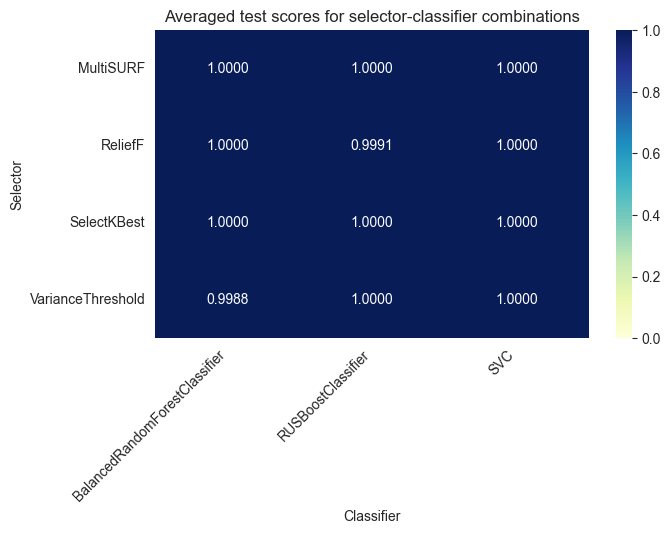

In [57]:
plot_heat_map('./results/blanket_stone_mask_3sigma_norm_auc_pr_5_5_k_fold.csv', True, './results')

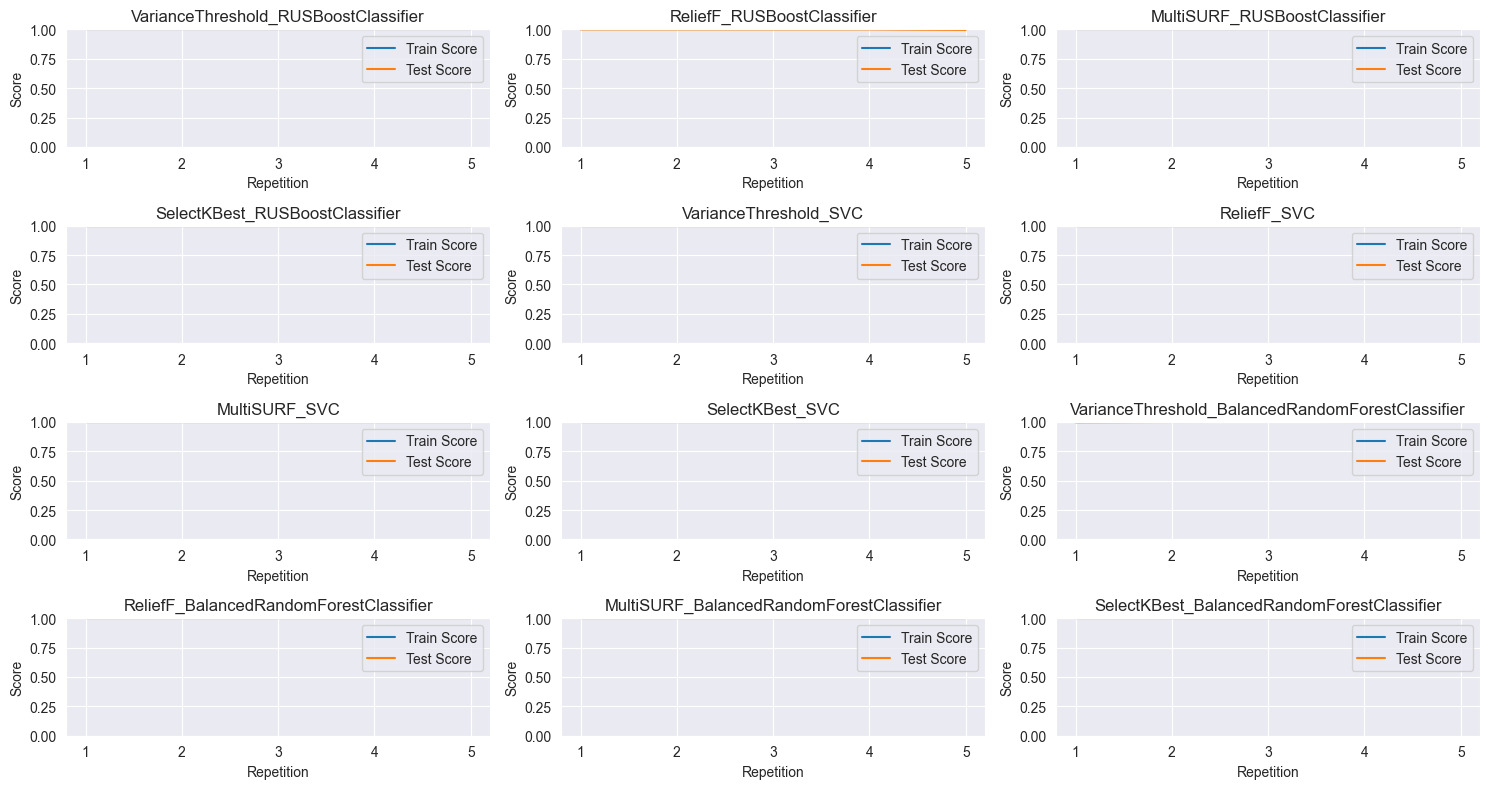

In [59]:
show_training_scores(pd.read_csv('./results/blanket_stone_mask_3sigma_norm_auc_pr_5_5_k_fold.csv')) 

In [39]:
dataframe = pd.read_csv('../data/dummy/blanket_stone_mask_3sigma_norm_not_balanced.csv')
stats_df = pd.read_csv('./results/blanket_stone_mask_3sigma_norm_auc_pr_5_5_k_fold.csv')
dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

X = dataframe.drop( ["Record ID", "Label","Image", "ROI pixels"], axis=1).values
y = dataframe['Label'].values.squeeze()

best_params_row = stats_df.iloc[55]  
random = best_params_row['random_state']
best_params_row = best_params_row.iloc[19:]
print(best_params_row)

RUSBoostClassifier__learning_rate                             NaN
RUSBoostClassifier__n_estimators                              NaN
RUSBoostClassifier__sampling_strategy                         NaN
VarianceThreshold__threshold                                  NaN
ReliefF__n_features_to_select                                 NaN
ReliefF__n_neighbors                                          NaN
MultiSURF__n_features_to_select                               NaN
SelectKBest__k                                                7.0
SVC__C                                                        NaN
SVC__gamma                                                    NaN
SVC__kernel                                                   NaN
BalancedRandomForestClassifier__criterion                    gini
BalancedRandomForestClassifier__max_depth                    22.0
BalancedRandomForestClassifier__max_features                 13.0
BalancedRandomForestClassifier__min_samples_leaf              1.0
BalancedRa

In [62]:
stats_df = pd.read_csv('./results/blanket_stone_mask_3sigma_norm_auc_pr_5_5_k_fold.csv')
stats_df["selected_features"].iloc[55] 

"['LBP_R_1_P_8_Hist_1', 'LBP_R_1_P_8_Hist_2', 'LBP_R_1_P_8_Hist_3', 'LBP_R_1_P_8_Hist_5', 'LBP_R_1_P_8_Hist_6', 'LBP_R_1_P_8_Hist_9', 'LBP_R_1_P_8_Hist_10']"

In [40]:
best_params = {'SelectKBest__k':7, 'BalancedRandomForestClassifier__criterion':'gini', 'BalancedRandomForestClassifier__max_depth':22,
               'BalancedRandomForestClassifier__max_features': 13, 'BalancedRandomForestClassifier__min_samples_leaf': 1,
               'BalancedRandomForestClassifier__min_samples_split': 4, 'BalancedRandomForestClassifier__n_estimators':124, 
               'BalancedRandomForestClassifier__sampling_strategy':'not minority'}
pipeline = Pipeline([('StandardScaler', StandardScaler()), 
                    (SelectKBest.__name__, SelectKBest(mutual_info_classif)),
                    (BalancedRandomForestClassifier.__name__, BalancedRandomForestClassifier(random_state=random))])
pipeline.set_params(**best_params)
pipeline.fit(X, y)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('SelectKBest',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_classif at 0x000001BFBCEB53F0>)),
                ('BalancedRandomForestClassifier',
                 BalancedRandomForestClassifier(max_depth=22, max_features=13,
                                                min_samples_split=4,
                                                n_estimators=124,
                                                random_state=102,
                                                sampling_strategy='not '
                                                                  'minority'))])

AUC-PR: 1.0


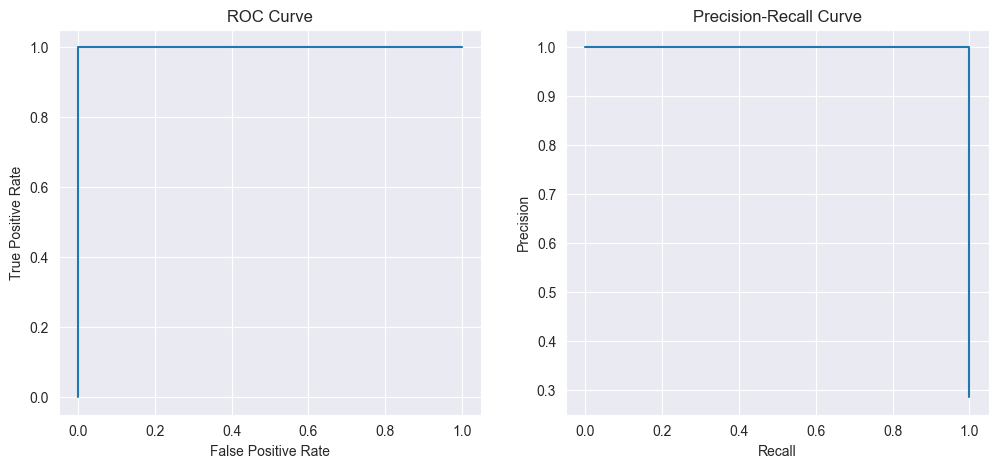

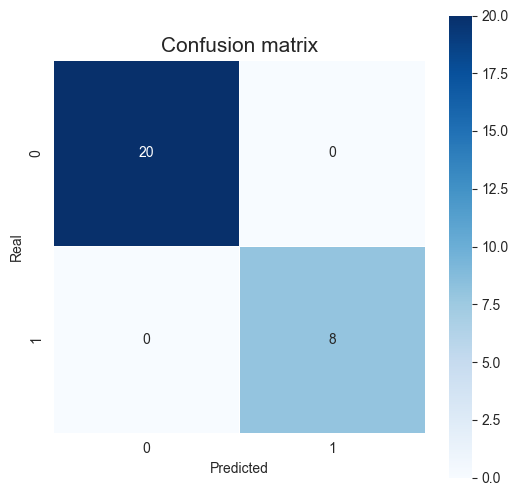

In [42]:
dataframe_val = pd.read_csv('../data/dummy/blanket_stone_mask_val_3sigma_norm_not_balanced.csv')

dataframe_val.sample(frac=1, random_state=42).reset_index(drop=True)
X_val = dataframe_val.drop( ["Record ID", "Label","Image", "ROI pixels"], axis=1).values
y_val = dataframe_val['Label'].values.squeeze()
prob = pipeline.predict_proba(X_val)[:, 1] 
y_pred = pipeline.predict(X_val)
precision, recall, _ = precision_recall_curve(y_val, prob)
auc_pr_ = auc(recall, precision)
print(f"AUC-PR: {auc_pr_}")
plot_combined_curves(y_val, prob)

conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Real')
plt.xlabel('Predicted')
plt.title('Confusion matrix', size = 15)
plt.show()

## Placenta dataset (balanced)

In [184]:
apply_nested_k_fold_cv_balance(features_5_fgr_pix_norm_eq, auc_pr, "b_features_5_fgr_pix_norm_eq_auc_pr_outer_5.csv", n_splits=5, n_inner_splits = 3, n_iter = 10, verbose=1, seed=42)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.7s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   16.5s remaining:   24.8s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   17.2s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   19.8s remaining:   29.7s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   19.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 547.0867524147034 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  2.0min finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.593643   
1            435    VarianceThreshold_KNeighborsClassifier    0.672103   
2            860    VarianceThreshold_KNeighborsClassifier    0.737086   
3            270    VarianceThreshold_KNeighborsClassifier    0.596712   
4            106    VarianceThreshold_KNeighborsClassifier    0.615020   
5            102              ReliefF_KNeighborsClassifier    0.710640   
6            435              ReliefF_KNeighborsClassifier    0.662001   
7            860              ReliefF_KNeighborsClassifier    0.709847   
8            270              ReliefF_KNeighborsClassifier    0.656450   
9            106              ReliefF_KNeighborsClassifier    0.720925   
10           102            MultiSURF_KNeighborsClassifier    0.589910   
11           435            MultiSURF_KNeighborsClassifier    0.667491   
12           860            MultiSURF_KNeighborsClassifier    0.737102   
13           270            MultiSURF_KNeighborsClassifier    0.608320   
14           106            MultiSURF_KNeighborsClassifier    0.655657   
15           102          SelectKBest_KNeighborsClassifier    0.639133   
16           435          SelectKBest_KNeighborsClassifier    0.663828   
17           860          SelectKBest_KNeighborsClassifier    0.707187   
18           270          SelectKBest_KNeighborsClassifier    0.622350   
19           106          SelectKBest_KNeighborsClassifier    0.702874   
20           102                     VarianceThreshold_SVC    0.601192   
21           435                     VarianceThreshold_SVC    0.691649   
22           860                     VarianceThreshold_SVC    0.626724   
23           270                     VarianceThreshold_SVC    0.585856   
24           106                     VarianceThreshold_SVC    0.526354   
25           102                               ReliefF_SVC    0.689883   
26           435                               ReliefF_SVC    0.794027   
27           860                               ReliefF_SVC    0.829071   
28           270                               ReliefF_SVC    0.716287   
29           106                               ReliefF_SVC    0.730492   
30           102                             MultiSURF_SVC    0.759277   
31           435                             MultiSURF_SVC    0.739898   
32           860                             MultiSURF_SVC    0.823564   
33           270                             MultiSURF_SVC    0.735372   
34           106                             MultiSURF_SVC    0.722952   
35           102                           SelectKBest_SVC    0.714276   
36           435                           SelectKBest_SVC    0.735819   
37           860                           SelectKBest_SVC    0.809000   
38           270                           SelectKBest_SVC    0.745929   
39           106                           SelectKBest_SVC    0.720083   
40           102  VarianceThreshold_RandomForestClassifier    0.597800   
41           435  VarianceThreshold_RandomForestClassifier    0.623791   
42           860  VarianceThreshold_RandomForestClassifier    0.719232   
43           270  VarianceThreshold_RandomForestClassifier    0.617530   
44           106  VarianceThreshold_RandomForestClassifier    0.582966   
45           102            ReliefF_RandomForestClassifier    0.626076   
46           435            ReliefF_RandomForestClassifier    0.634478   
47           860            ReliefF_RandomForestClassifier    0.703650   
48           270            ReliefF_RandomForestClassifier    0.685757   
49           106            ReliefF_RandomForestClassifier    0.658494   
50           102          MultiSURF_RandomForestClassifier    0.608953   
51           435          MultiSURF_RandomForestClassifier    0.760566   
52           860          MultiSURF_RandomForestClassifier    0.723867   
53      

In [145]:
apply_nested_k_fold_cv_balance(features_5_fgr_pix_norm_eq_lbp, auc_pr, "b_features_5_fgr_pix_norm_eq_lbp_auc_pr_outer_5.csv", n_splits=5, n_inner_splits = 3, n_iter = 10, verbose=1, seed=42)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    6.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   12.5s remaining:   18.9s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   28.6s remaining:   43.0s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   29.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   36.5s remaining:   54.8s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   36.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 600.5189390182495 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  2.1min finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.593643   
1            435    VarianceThreshold_KNeighborsClassifier    0.672103   
2            860    VarianceThreshold_KNeighborsClassifier    0.737086   
3            270    VarianceThreshold_KNeighborsClassifier    0.596712   
4            106    VarianceThreshold_KNeighborsClassifier    0.615020   
5            102              ReliefF_KNeighborsClassifier    0.620760   
6            435              ReliefF_KNeighborsClassifier    0.705763   
7            860              ReliefF_KNeighborsClassifier    0.726645   
8            270              ReliefF_KNeighborsClassifier    0.694898   
9            106              ReliefF_KNeighborsClassifier    0.754216   
10           102            MultiSURF_KNeighborsClassifier    0.692703   
11           435            MultiSURF_KNeighborsClassifier    0.702745   
12           860            MultiSURF_KNeighborsClassifier    0.721907   
13           270            MultiSURF_KNeighborsClassifier    0.686727   
14           106            MultiSURF_KNeighborsClassifier    0.673571   
15           102          SelectKBest_KNeighborsClassifier    0.611145   
16           435          SelectKBest_KNeighborsClassifier    0.715112   
17           860          SelectKBest_KNeighborsClassifier    0.688377   
18           270          SelectKBest_KNeighborsClassifier    0.651066   
19           106          SelectKBest_KNeighborsClassifier    0.668538   
20           102                     VarianceThreshold_SVC    0.596043   
21           435                     VarianceThreshold_SVC    0.693838   
22           860                     VarianceThreshold_SVC    0.626724   
23           270                     VarianceThreshold_SVC    0.613763   
24           106                     VarianceThreshold_SVC    0.535512   
25           102                               ReliefF_SVC    0.690965   
26           435                               ReliefF_SVC    0.633027   
27           860                               ReliefF_SVC    0.649443   
28           270                               ReliefF_SVC    0.650916   
29           106                               ReliefF_SVC    0.664214   
30           102                             MultiSURF_SVC    0.725578   
31           435                             MultiSURF_SVC    0.716983   
32           860                             MultiSURF_SVC    0.804876   
33           270                             MultiSURF_SVC    0.662663   
34           106                             MultiSURF_SVC    0.686662   
35           102                           SelectKBest_SVC    0.703403   
36           435                           SelectKBest_SVC    0.696369   
37           860                           SelectKBest_SVC    0.733959   
38           270                           SelectKBest_SVC    0.756350   
39           106                           SelectKBest_SVC    0.727351   
40           102  VarianceThreshold_RandomForestClassifier    0.593594   
41           435  VarianceThreshold_RandomForestClassifier    0.620861   
42           860  VarianceThreshold_RandomForestClassifier    0.672234   
43           270  VarianceThreshold_RandomForestClassifier    0.609522   
44           106  VarianceThreshold_RandomForestClassifier    0.591027   
45           102            ReliefF_RandomForestClassifier    0.646697   
46           435            ReliefF_RandomForestClassifier    0.698379   
47           860            ReliefF_RandomForestClassifier    0.777750   
48           270            ReliefF_RandomForestClassifier    0.700514   
49           106            ReliefF_RandomForestClassifier    0.720090   
50           102          MultiSURF_RandomForestClassifier    0.749934   
51           435          MultiSURF_RandomForestClassifier    0.710440   
52           860          MultiSURF_RandomForestClassifier    0.702015   
53      

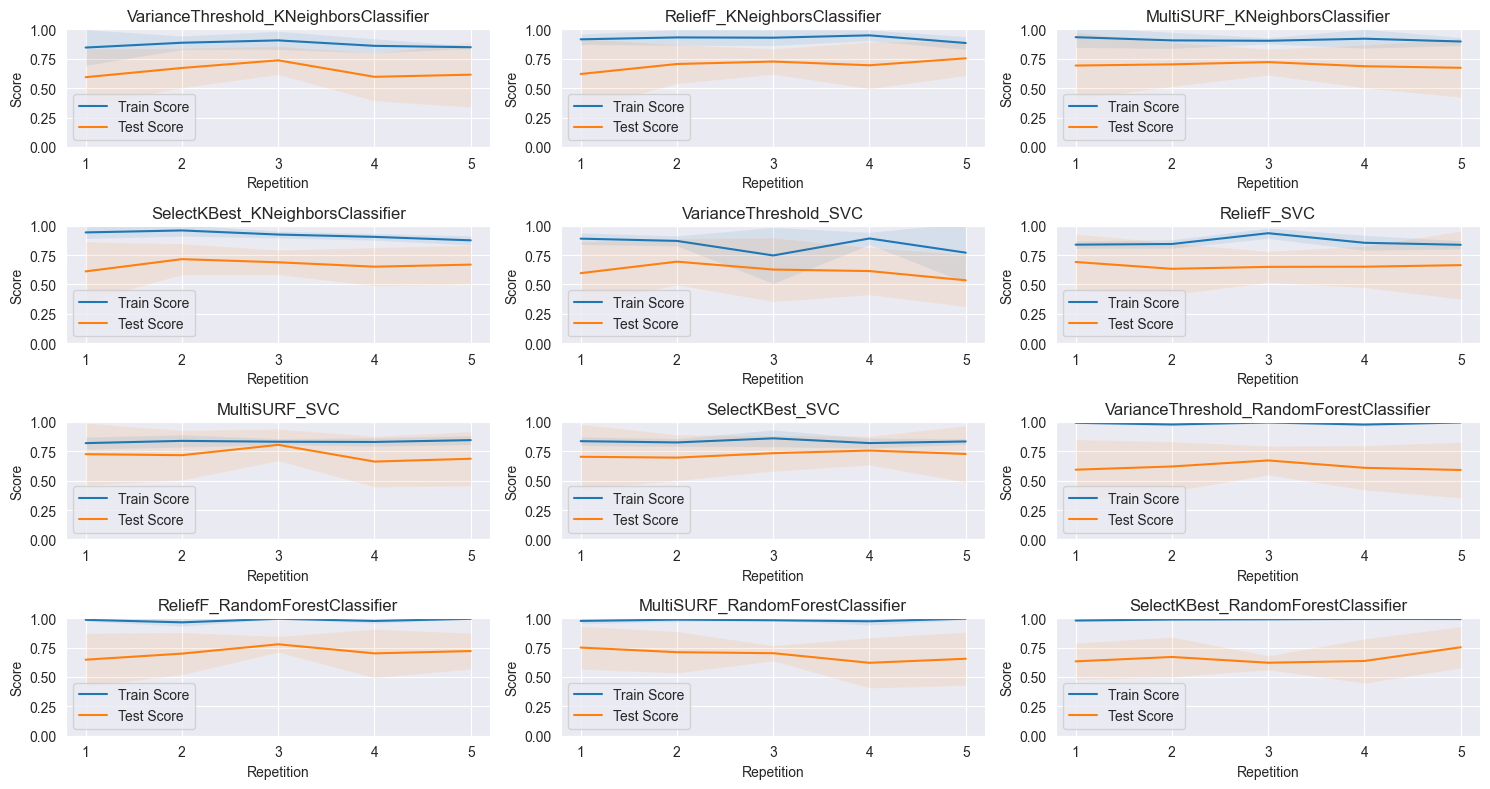

In [235]:
show_training_scores(pd.read_csv('./results/b_features_5_fgr_pix_norm_eq_lbp_auc_pr_outer_5.csv'))

In [ ]:
apply_k_fold_cv_balance(features_5_fgr_pix_norm_eq_lbp, auc_pr, "b_features_5_fgr_pix_norm_eq_lbp_auc_pr_k_fold_5_10.csv", n_splits=5) 

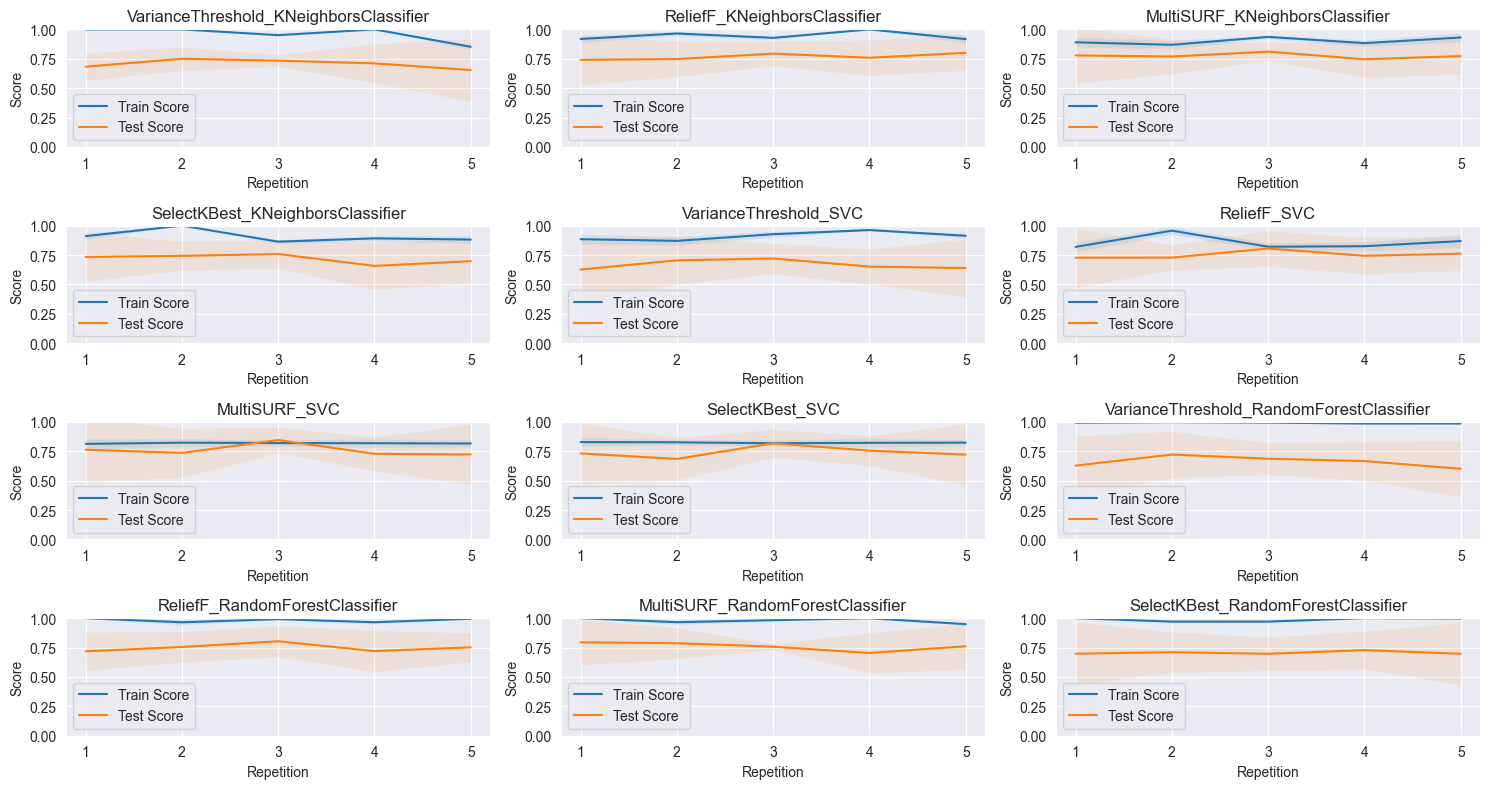

In [663]:
show_training_scores(pd.read_csv('./results/b_features_5_fgr_pix_norm_eq_lbp_auc_pr_k_fold_5_10.csv'))

In [664]:
stats_df = pd.read_csv('./results/b_features_5_fgr_pix_norm_eq_lbp_auc_pr_k_fold_5_10.csv')
stats_df["selected_features"].iloc[27] 

"['original_firstorder_90Percentile', 'original_firstorder_Energy_pix_norm', 'original_firstorder_RootMeanSquared', 'original_firstorder_Median', 'original_firstorder_Mean', 'LBP_R_1_P_8_Hist_4']"

In [219]:
apply_k_fold_cv_balance(features_5_fgr_pix_norm_eq, auc_pr, "b_features_5_fgr_pix_norm_eq_auc_pr_5_10_k_fold.csv", n_splits=5)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   15.1s remaining:   22.7s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   16.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.6s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 252.0072557926178 s


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.682955   
1            435    VarianceThreshold_KNeighborsClassifier    0.750303   
2            860    VarianceThreshold_KNeighborsClassifier    0.734179   
3            270    VarianceThreshold_KNeighborsClassifier    0.710833   
4            106    VarianceThreshold_KNeighborsClassifier    0.654414   
5            102              ReliefF_KNeighborsClassifier    0.768361   
6            435              ReliefF_KNeighborsClassifier    0.768527   
7            860              ReliefF_KNeighborsClassifier    0.728041   
8            270              ReliefF_KNeighborsClassifier    0.760556   
9            106              ReliefF_KNeighborsClassifier    0.731383   
10           102            MultiSURF_KNeighborsClassifier    0.761338   
11           435            MultiSURF_KNeighborsClassifier    0.751764   
12           860            MultiSURF_KNeighborsClassifier    0.788010   
13           270            MultiSURF_KNeighborsClassifier    0.710565   
14           106            MultiSURF_KNeighborsClassifier    0.734073   
15           102          SelectKBest_KNeighborsClassifier    0.709684   
16           435          SelectKBest_KNeighborsClassifier    0.783141   
17           860          SelectKBest_KNeighborsClassifier    0.744976   
18           270          SelectKBest_KNeighborsClassifier    0.729394   
19           106          SelectKBest_KNeighborsClassifier    0.726052   
20           102                     VarianceThreshold_SVC    0.626560   
21           435                     VarianceThreshold_SVC    0.705064   
22           860                     VarianceThreshold_SVC    0.720831   
23           270                     VarianceThreshold_SVC    0.652060   
24           106                     VarianceThreshold_SVC    0.640460   
25           102                               ReliefF_SVC    0.762870   
26           435                               ReliefF_SVC    0.786404   
27           860                               ReliefF_SVC    0.842560   
28           270                               ReliefF_SVC    0.782301   
29           106                               ReliefF_SVC    0.730718   
30           102                             MultiSURF_SVC    0.759277   
31           435                             MultiSURF_SVC    0.736404   
32           860                             MultiSURF_SVC    0.845953   
33           270                             MultiSURF_SVC    0.743643   
34           106                             MultiSURF_SVC    0.722952   
35           102                           SelectKBest_SVC    0.723178   
36           435                           SelectKBest_SVC    0.737245   
37           860                           SelectKBest_SVC    0.833010   
38           270                           SelectKBest_SVC    0.784814   
39           106                           SelectKBest_SVC    0.736896   
40           102  VarianceThreshold_RandomForestClassifier    0.607233   
41           435  VarianceThreshold_RandomForestClassifier    0.657973   
42           860  VarianceThreshold_RandomForestClassifier    0.706452   
43           270  VarianceThreshold_RandomForestClassifier    0.660191   
44           106  VarianceThreshold_RandomForestClassifier    0.601818   
45           102            ReliefF_RandomForestClassifier    0.786591   
46           435            ReliefF_RandomForestClassifier    0.769845   
47           860            ReliefF_RandomForestClassifier    0.725001   
48           270            ReliefF_RandomForestClassifier    0.743671   
49           106            ReliefF_RandomForestClassifier    0.732444   
50           102          MultiSURF_RandomForestClassifier    0.751146   
51           435          MultiSURF_RandomForestClassifier    0.774407   
52           860          MultiSURF_RandomForestClassifier    0.746420   
53      

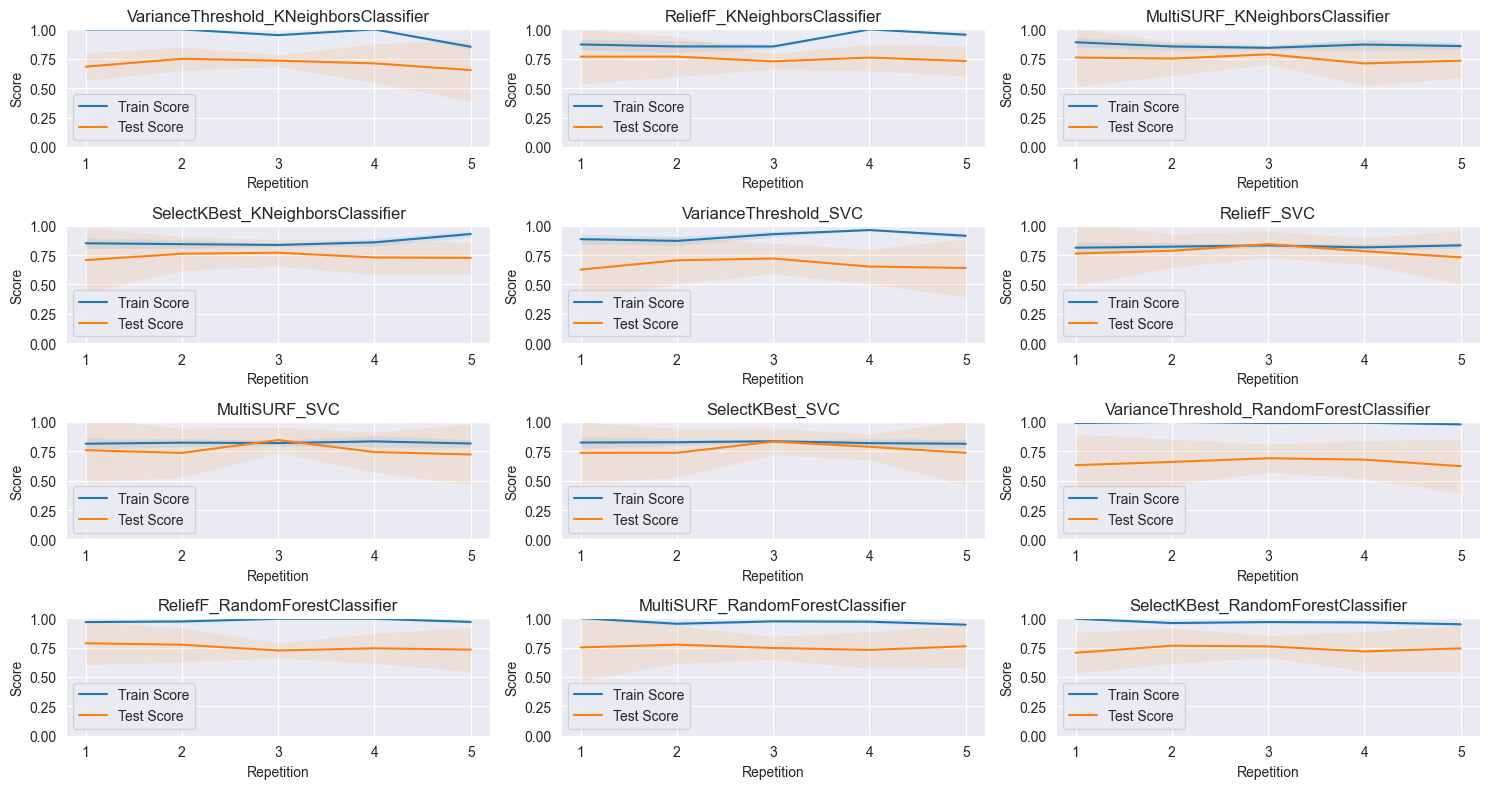

In [629]:
show_training_scores(pd.read_csv('./results/b_features_5_fgr_pix_norm_eq_auc_pr_5_10_k_fold.csv'))

In [192]:
apply_nested_k_fold_cv_balance(features_5_pe_pix_norm_eq_lbp, auc_pr, "b_features_5_pe_pix_norm_eq_lbp_auc_pr.csv", n_splits=3, n_inner_splits = 3, n_iter = 10, verbose=1, seed=42)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    7.9s remaining:   12.0s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   14.8s remaining:   22.2s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   14.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 312.17834973335266 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  1.3min finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.680336   
1            435    VarianceThreshold_KNeighborsClassifier    0.695100   
2            860    VarianceThreshold_KNeighborsClassifier    0.609163   
3            270    VarianceThreshold_KNeighborsClassifier    0.491154   
4            106    VarianceThreshold_KNeighborsClassifier    0.485941   
5            102              ReliefF_KNeighborsClassifier    0.555148   
6            435              ReliefF_KNeighborsClassifier    0.506876   
7            860              ReliefF_KNeighborsClassifier    0.419444   
8            270              ReliefF_KNeighborsClassifier    0.613386   
9            106              ReliefF_KNeighborsClassifier    0.333101   
10           102            MultiSURF_KNeighborsClassifier    0.460920   
11           435            MultiSURF_KNeighborsClassifier    0.521011   
12           860            MultiSURF_KNeighborsClassifier    0.423953   
13           270            MultiSURF_KNeighborsClassifier    0.530598   
14           106            MultiSURF_KNeighborsClassifier    0.335083   
15           102          SelectKBest_KNeighborsClassifier    0.525830   
16           435          SelectKBest_KNeighborsClassifier    0.626884   
17           860          SelectKBest_KNeighborsClassifier    0.492735   
18           270          SelectKBest_KNeighborsClassifier    0.598280   
19           106          SelectKBest_KNeighborsClassifier    0.411747   
20           102                     VarianceThreshold_SVC    0.688115   
21           435                     VarianceThreshold_SVC    0.434473   
22           860                     VarianceThreshold_SVC    0.536667   
23           270                     VarianceThreshold_SVC    0.715267   
24           106                     VarianceThreshold_SVC    0.756343   
25           102                               ReliefF_SVC    0.497567   
26           435                               ReliefF_SVC    0.478997   
27           860                               ReliefF_SVC    0.521745   
28           270                               ReliefF_SVC    0.476101   
29           106                               ReliefF_SVC    0.630478   
30           102                             MultiSURF_SVC    0.440404   
31           435                             MultiSURF_SVC    0.402310   
32           860                             MultiSURF_SVC    0.528208   
33           270                             MultiSURF_SVC    0.521404   
34           106                             MultiSURF_SVC    0.396308   
35           102                           SelectKBest_SVC    0.428922   
36           435                           SelectKBest_SVC    0.489924   
37           860                           SelectKBest_SVC    0.433646   
38           270                           SelectKBest_SVC    0.551873   
39           106                           SelectKBest_SVC    0.457571   
40           102  VarianceThreshold_RandomForestClassifier    0.498416   
41           435  VarianceThreshold_RandomForestClassifier    0.459274   
42           860  VarianceThreshold_RandomForestClassifier    0.424967   
43           270  VarianceThreshold_RandomForestClassifier    0.514347   
44           106  VarianceThreshold_RandomForestClassifier    0.420072   
45           102            ReliefF_RandomForestClassifier    0.475026   
46           435            ReliefF_RandomForestClassifier    0.534823   
47           860            ReliefF_RandomForestClassifier    0.396982   
48           270            ReliefF_RandomForestClassifier    0.485981   
49           106            ReliefF_RandomForestClassifier    0.416244   
50           102          MultiSURF_RandomForestClassifier    0.533091   
51           435          MultiSURF_RandomForestClassifier    0.481215   
52           860          MultiSURF_RandomForestClassifier    0.427518   
53      

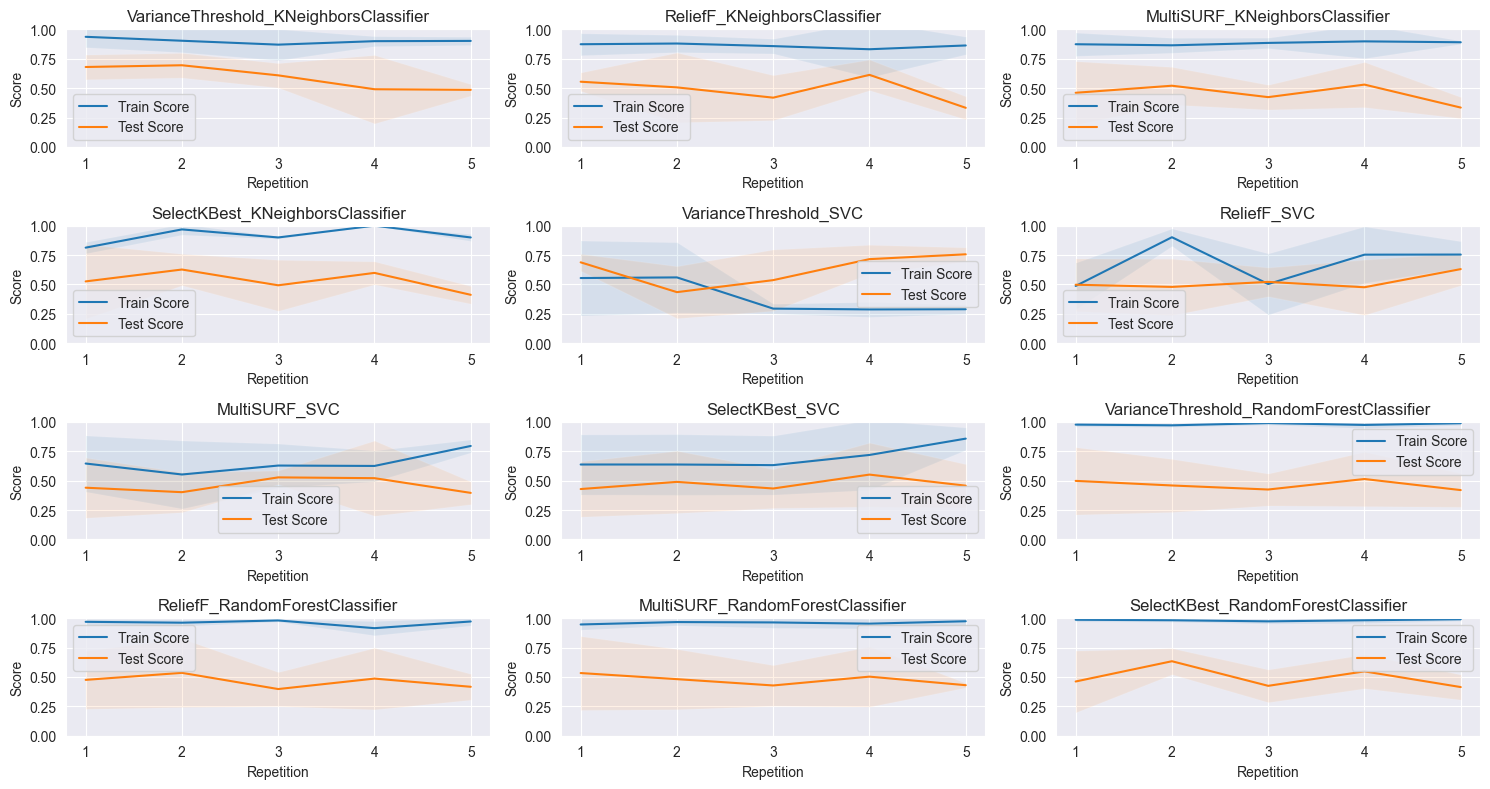

In [194]:
show_training_scores(pd.read_csv('./results/b_features_5_pe_pix_norm_eq_lbp_auc_pr.csv'))

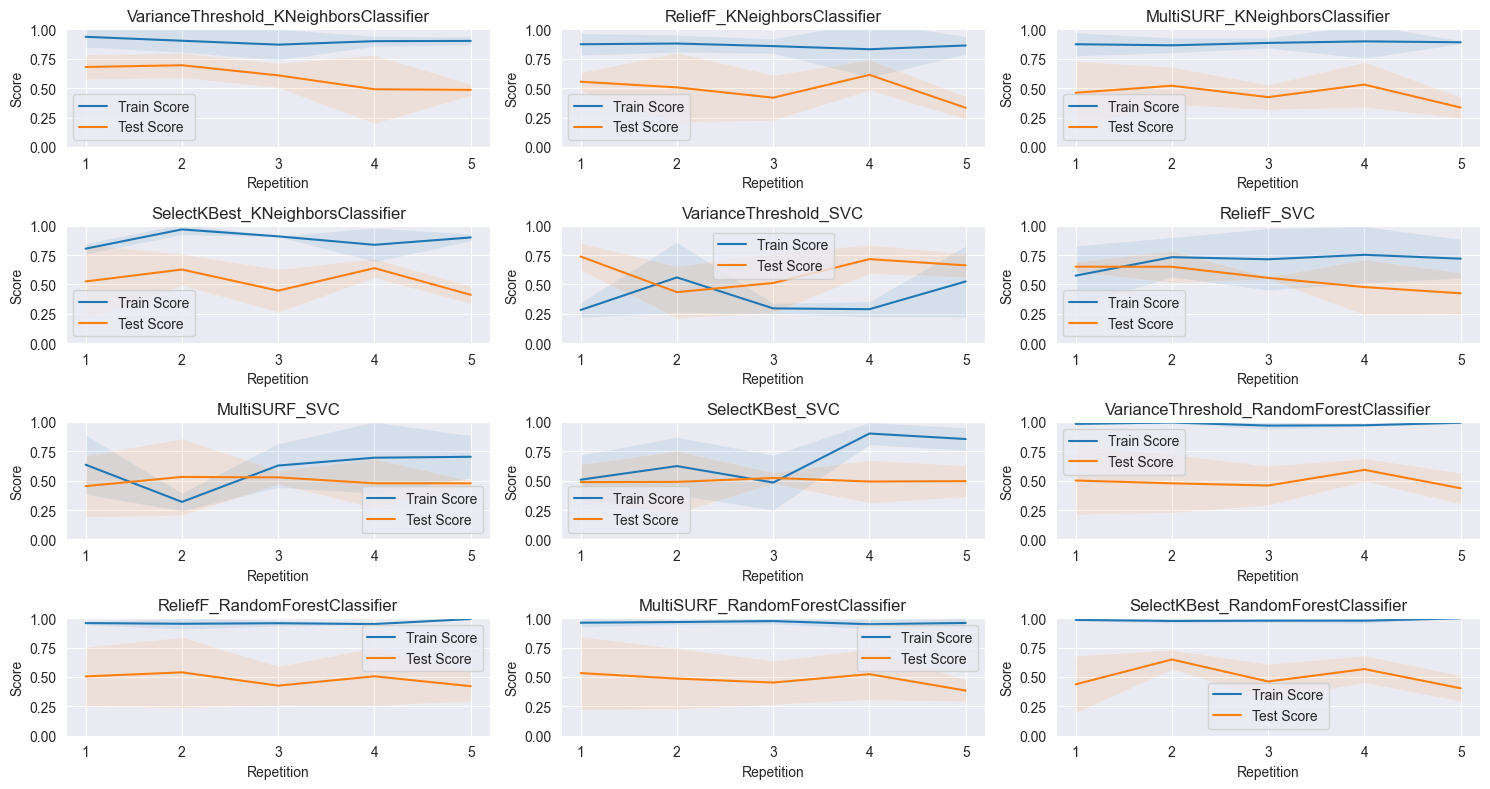

In [66]:
show_training_scores(pd.read_csv('./results/b_features_5_pe_pix_norm_eq_auc_pr.csv'))

In [255]:
apply_k_fold_cv_balance(features_5_pe_pix_norm_eq, auc_pr, "b_features_5_pe_pix_norm_eq_auc_pr_k_fold_3_10_k_fold.csv", n_splits=3)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.4s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    4.6s remaining:    7.0s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    6.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 130.97312259674072 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   26.7s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.741667   
1            435    VarianceThreshold_KNeighborsClassifier    0.698016   
2            860    VarianceThreshold_KNeighborsClassifier    0.613426   
3            270    VarianceThreshold_KNeighborsClassifier    0.683587   
4            106    VarianceThreshold_KNeighborsClassifier    0.479446   
5            102              ReliefF_KNeighborsClassifier    0.682812   
6            435              ReliefF_KNeighborsClassifier    0.649455   
7            860              ReliefF_KNeighborsClassifier    0.591860   
8            270              ReliefF_KNeighborsClassifier    0.683770   
9            106              ReliefF_KNeighborsClassifier    0.407224   
10           102            MultiSURF_KNeighborsClassifier    0.549062   
11           435            MultiSURF_KNeighborsClassifier    0.690608   
12           860            MultiSURF_KNeighborsClassifier    0.449430   
13           270            MultiSURF_KNeighborsClassifier    0.592788   
14           106            MultiSURF_KNeighborsClassifier    0.379287   
15           102          SelectKBest_KNeighborsClassifier    0.591871   
16           435          SelectKBest_KNeighborsClassifier    0.691546   
17           860          SelectKBest_KNeighborsClassifier    0.610742   
18           270          SelectKBest_KNeighborsClassifier    0.675397   
19           106          SelectKBest_KNeighborsClassifier    0.411713   
20           102                     VarianceThreshold_SVC    0.746872   
21           435                     VarianceThreshold_SVC    0.541812   
22           860                     VarianceThreshold_SVC    0.570628   
23           270                     VarianceThreshold_SVC    0.756287   
24           106                     VarianceThreshold_SVC    0.756343   
25           102                               ReliefF_SVC    0.737619   
26           435                               ReliefF_SVC    0.615376   
27           860                               ReliefF_SVC    0.688454   
28           270                               ReliefF_SVC    0.665182   
29           106                               ReliefF_SVC    0.742075   
30           102                             MultiSURF_SVC    0.701747   
31           435                             MultiSURF_SVC    0.576827   
32           860                             MultiSURF_SVC    0.667696   
33           270                             MultiSURF_SVC    0.516995   
34           106                             MultiSURF_SVC    0.487361   
35           102                           SelectKBest_SVC    0.573206   
36           435                           SelectKBest_SVC    0.709902   
37           860                           SelectKBest_SVC    0.636684   
38           270                           SelectKBest_SVC    0.746751   
39           106                           SelectKBest_SVC    0.502265   
40           102  VarianceThreshold_RandomForestClassifier    0.499753   
41           435  VarianceThreshold_RandomForestClassifier    0.496927   
42           860  VarianceThreshold_RandomForestClassifier    0.495769   
43           270  VarianceThreshold_RandomForestClassifier    0.531935   
44           106  VarianceThreshold_RandomForestClassifier    0.439853   
45           102            ReliefF_RandomForestClassifier    0.551696   
46           435            ReliefF_RandomForestClassifier    0.578484   
47           860            ReliefF_RandomForestClassifier    0.474338   
48           270            ReliefF_RandomForestClassifier    0.502230   
49           106            ReliefF_RandomForestClassifier    0.431102   
50           102          MultiSURF_RandomForestClassifier    0.529351   
51           435          MultiSURF_RandomForestClassifier    0.492008   
52           860          MultiSURF_RandomForestClassifier    0.436558   
53      

In [150]:
pd.read_csv('./results/b_features_5_pe_pix_norm_eq_auc_pr.csv')

random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.680336   
1            435    VarianceThreshold_KNeighborsClassifier    0.695100   
2            860    VarianceThreshold_KNeighborsClassifier    0.609163   
3            270    VarianceThreshold_KNeighborsClassifier    0.491154   
4            106    VarianceThreshold_KNeighborsClassifier    0.485941   
5            102              ReliefF_KNeighborsClassifier    0.555148   
6            435              ReliefF_KNeighborsClassifier    0.506876   
7            860              ReliefF_KNeighborsClassifier    0.419444   
8            270              ReliefF_KNeighborsClassifier    0.613386   
9            106              ReliefF_KNeighborsClassifier    0.333101   
10           102            MultiSURF_KNeighborsClassifier    0.460920   
11           435            MultiSURF_KNeighborsClassifier    0.521011   
12           860            MultiSURF_KNeighborsClassifier    0.423953   
13           270            MultiSURF_KNeighborsClassifier    0.530598   
14           106            MultiSURF_KNeighborsClassifier    0.335083   
15           102          SelectKBest_KNeighborsClassifier    0.525430   
16           435          SelectKBest_KNeighborsClassifier    0.626884   
17           860          SelectKBest_KNeighborsClassifier    0.447189   
18           270          SelectKBest_KNeighborsClassifier    0.638492   
19           106          SelectKBest_KNeighborsClassifier    0.411747   
20           102                     VarianceThreshold_SVC    0.737348   
21           435                     VarianceThreshold_SVC    0.434473   
22           860                     VarianceThreshold_SVC    0.512197   
23           270                     VarianceThreshold_SVC    0.715267   
24           106                     VarianceThreshold_SVC    0.662403   
25           102                               ReliefF_SVC    0.651199   
26           435                               ReliefF_SVC    0.650308   
27           860                               ReliefF_SVC    0.556049   
28           270                               ReliefF_SVC    0.477631   
29           106                               ReliefF_SVC    0.424631   
30           102                             MultiSURF_SVC    0.453614   
31           435                             MultiSURF_SVC    0.532152   
32           860                             MultiSURF_SVC    0.528208   
33           270                             MultiSURF_SVC    0.478174   
34           106                             MultiSURF_SVC    0.477632   
35           102                           SelectKBest_SVC    0.487714   
36           435                           SelectKBest_SVC    0.489924   
37           860                           SelectKBest_SVC    0.523038   
38           270                           SelectKBest_SVC    0.493128   
39           106                           SelectKBest_SVC    0.496407   
40           102  VarianceThreshold_RandomForestClassifier    0.501759   
41           435  VarianceThreshold_RandomForestClassifier    0.477527   
42           860  VarianceThreshold_RandomForestClassifier    0.459076   
43           270  VarianceThreshold_RandomForestClassifier    0.592265   
44           106  VarianceThreshold_RandomForestClassifier    0.435582   
45           102            ReliefF_RandomForestClassifier    0.504611   
46           435            ReliefF_RandomForestClassifier    0.539166   
47           860            ReliefF_RandomForestClassifier    0.425847   
48           270            ReliefF_RandomForestClassifier    0.505186   
49           106            ReliefF_RandomForestClassifier    0.421370   
50           102          MultiSURF_RandomForestClassifier    0.532707   
51           435          MultiSURF_RandomForestClassifier    0.485861   
52           860          MultiSURF_RandomForestClassifier    0.452334   
53      

In [253]:
apply_k_fold_cv_balance(features_5_pe_pix_norm_eq_lbp, auc_pr, "b_features_5_pe_pix_norm_eq_lbp_auc_pr_k_fold_3_10_kfold.csv", n_splits=3)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.9s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.5s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 119.11914443969727 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   24.1s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.741667   
1            435    VarianceThreshold_KNeighborsClassifier    0.698016   
2            860    VarianceThreshold_KNeighborsClassifier    0.613426   
3            270    VarianceThreshold_KNeighborsClassifier    0.683587   
4            106    VarianceThreshold_KNeighborsClassifier    0.479446   
5            102              ReliefF_KNeighborsClassifier    0.682812   
6            435              ReliefF_KNeighborsClassifier    0.649455   
7            860              ReliefF_KNeighborsClassifier    0.591860   
8            270              ReliefF_KNeighborsClassifier    0.683770   
9            106              ReliefF_KNeighborsClassifier    0.407224   
10           102            MultiSURF_KNeighborsClassifier    0.549062   
11           435            MultiSURF_KNeighborsClassifier    0.690608   
12           860            MultiSURF_KNeighborsClassifier    0.449430   
13           270            MultiSURF_KNeighborsClassifier    0.592788   
14           106            MultiSURF_KNeighborsClassifier    0.379287   
15           102          SelectKBest_KNeighborsClassifier    0.591871   
16           435          SelectKBest_KNeighborsClassifier    0.679742   
17           860          SelectKBest_KNeighborsClassifier    0.610785   
18           270          SelectKBest_KNeighborsClassifier    0.675397   
19           106          SelectKBest_KNeighborsClassifier    0.411713   
20           102                     VarianceThreshold_SVC    0.747459   
21           435                     VarianceThreshold_SVC    0.516537   
22           860                     VarianceThreshold_SVC    0.570628   
23           270                     VarianceThreshold_SVC    0.756287   
24           106                     VarianceThreshold_SVC    0.756343   
25           102                               ReliefF_SVC    0.737619   
26           435                               ReliefF_SVC    0.579054   
27           860                               ReliefF_SVC    0.652874   
28           270                               ReliefF_SVC    0.626254   
29           106                               ReliefF_SVC    0.742075   
30           102                             MultiSURF_SVC    0.701747   
31           435                             MultiSURF_SVC    0.576827   
32           860                             MultiSURF_SVC    0.648342   
33           270                             MultiSURF_SVC    0.544229   
34           106                             MultiSURF_SVC    0.484788   
35           102                           SelectKBest_SVC    0.543715   
36           435                           SelectKBest_SVC    0.630402   
37           860                           SelectKBest_SVC    0.599805   
38           270                           SelectKBest_SVC    0.818181   
39           106                           SelectKBest_SVC    0.502265   
40           102  VarianceThreshold_RandomForestClassifier    0.517505   
41           435  VarianceThreshold_RandomForestClassifier    0.493234   
42           860  VarianceThreshold_RandomForestClassifier    0.510631   
43           270  VarianceThreshold_RandomForestClassifier    0.585608   
44           106  VarianceThreshold_RandomForestClassifier    0.449667   
45           102            ReliefF_RandomForestClassifier    0.562014   
46           435            ReliefF_RandomForestClassifier    0.594115   
47           860            ReliefF_RandomForestClassifier    0.461912   
48           270            ReliefF_RandomForestClassifier    0.522444   
49           106            ReliefF_RandomForestClassifier    0.432180   
50           102          MultiSURF_RandomForestClassifier    0.532785   
51           435          MultiSURF_RandomForestClassifier    0.488519   
52           860          MultiSURF_RandomForestClassifier    0.420212   
53      

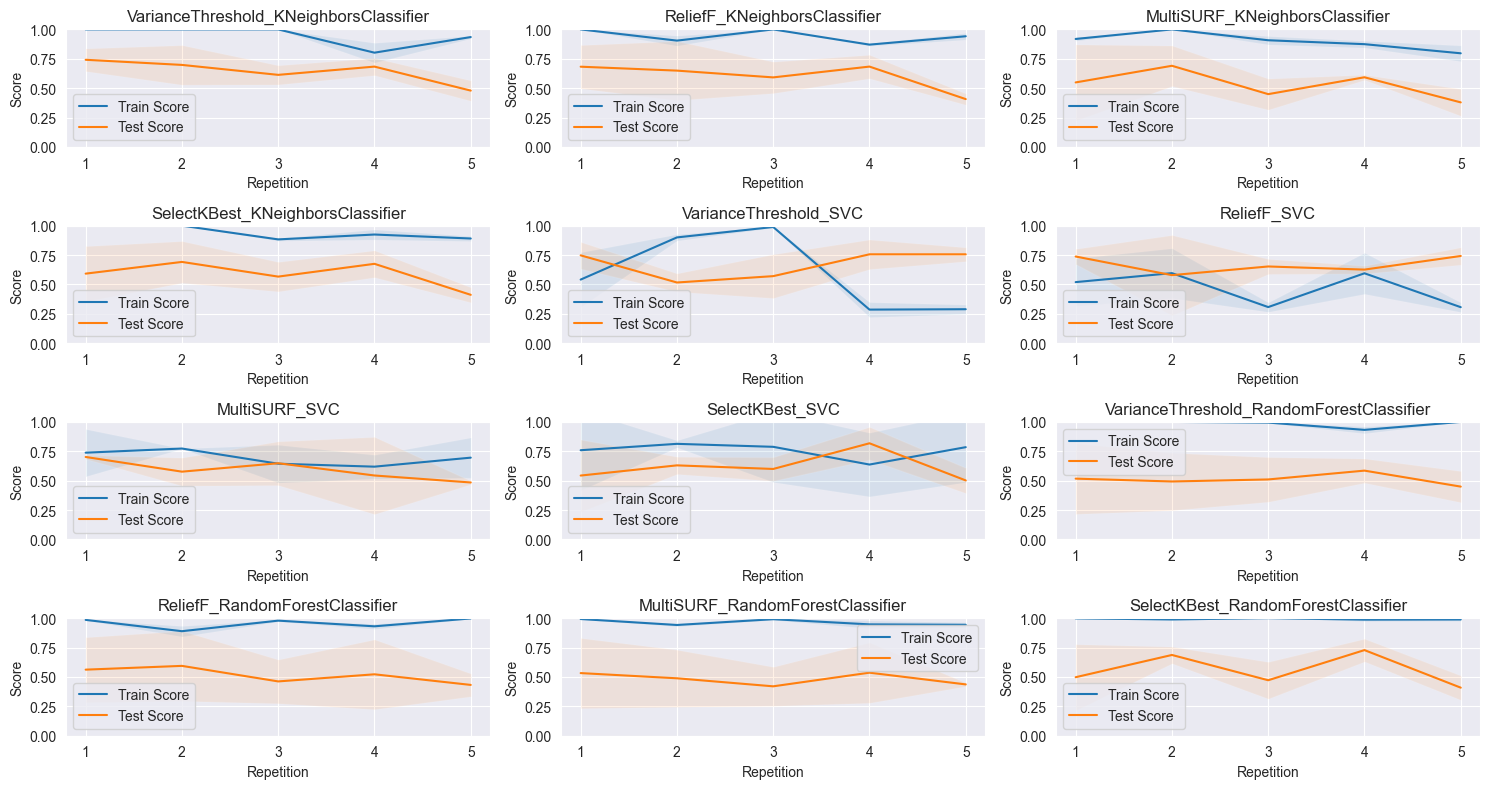

In [139]:
show_training_scores(pd.read_csv('./results/b_features_5_pe_pix_norm_eq_lbp_auc_pr_k_fold_3_10_kfold.csv'))

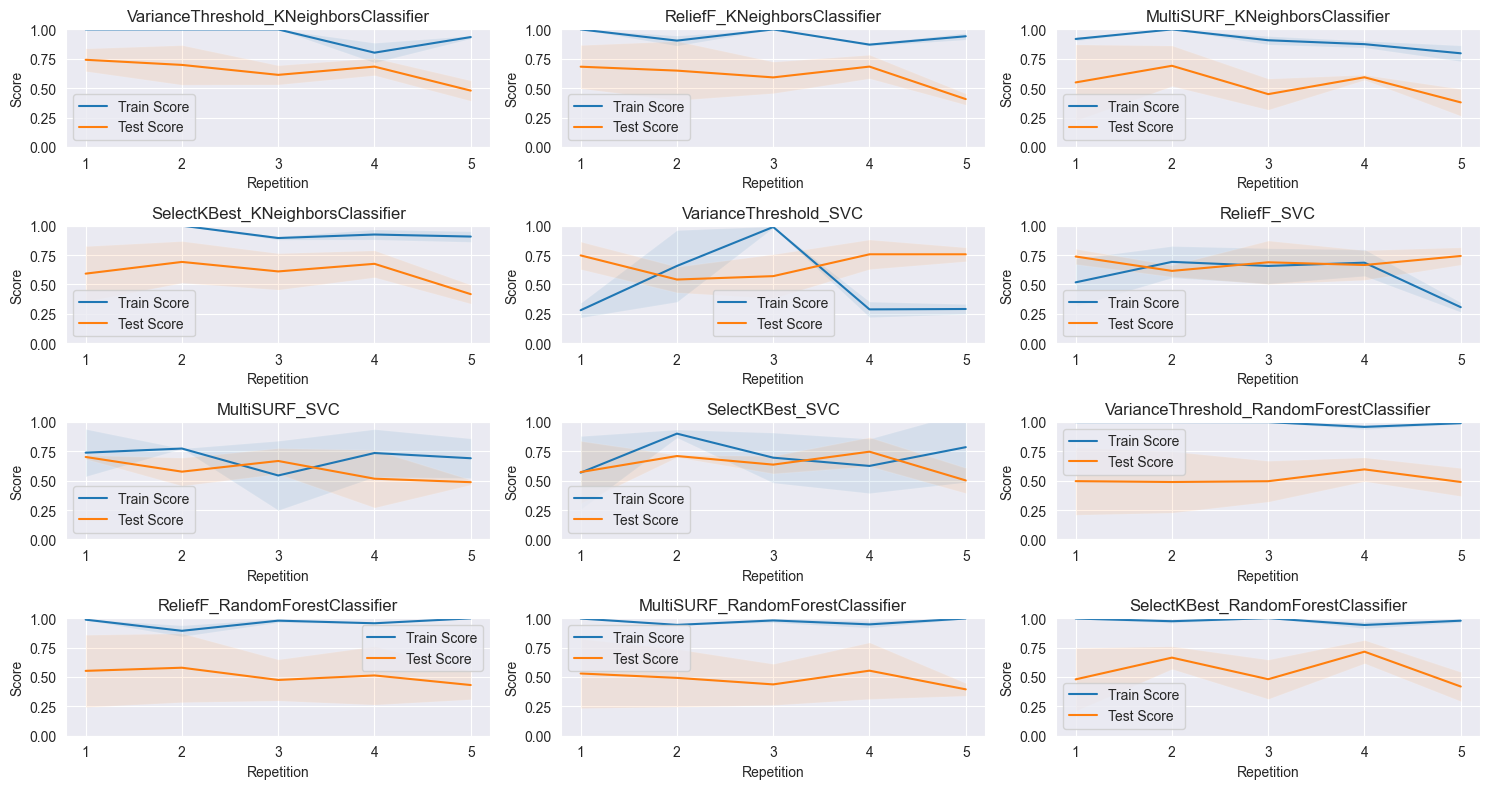

In [652]:
show_training_scores(pd.read_csv('./results/b_features_5_pe_pix_norm_eq_auc_pr_k_fold_3_10_kfold.csv'))


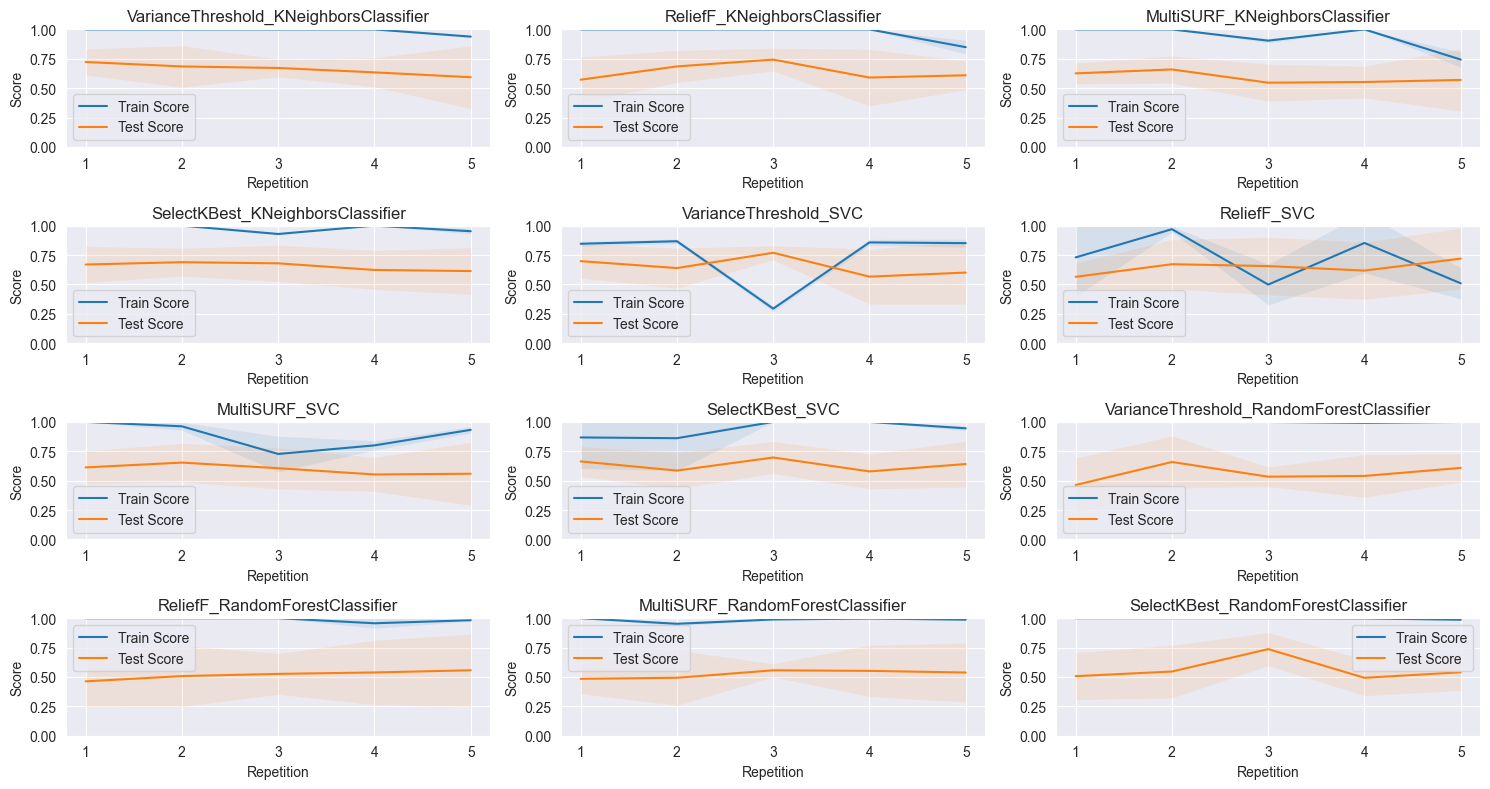

In [53]:
show_training_scores(pd.read_csv('./results/b_my_df_3sigma_7_fgr_eq_norm_k_fold_5_10.csv'))


In [76]:
apply_k_fold_cv_balance(my_df_3sigma_7_fgr_eq_norm, auc_pr, "b_my_df_3sigma_7_fgr_eq_norm_k_fold_5_10.csv", n_splits=5) 

False


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    9.3s remaining:   14.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.0s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.5s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   24.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   14.7s remaining:   22.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 314.69520235061646 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   54.0s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.722778   
1            435    VarianceThreshold_KNeighborsClassifier    0.685000   
2            860    VarianceThreshold_KNeighborsClassifier    0.672024   
3            270    VarianceThreshold_KNeighborsClassifier    0.634603   
4            106    VarianceThreshold_KNeighborsClassifier    0.593397   
5            102              ReliefF_KNeighborsClassifier    0.572222   
6            435              ReliefF_KNeighborsClassifier    0.685368   
7            860              ReliefF_KNeighborsClassifier    0.743182   
8            270              ReliefF_KNeighborsClassifier    0.590556   
9            106              ReliefF_KNeighborsClassifier    0.609843   
10           102            MultiSURF_KNeighborsClassifier    0.626190   
11           435            MultiSURF_KNeighborsClassifier    0.659444   
12           860            MultiSURF_KNeighborsClassifier    0.546872   
13           270            MultiSURF_KNeighborsClassifier    0.552589   
14           106            MultiSURF_KNeighborsClassifier    0.570145   
15           102          SelectKBest_KNeighborsClassifier    0.669658   
16           435          SelectKBest_KNeighborsClassifier    0.689268   
17           860          SelectKBest_KNeighborsClassifier    0.679532   
18           270          SelectKBest_KNeighborsClassifier    0.623384   
19           106          SelectKBest_KNeighborsClassifier    0.613751   
20           102                     VarianceThreshold_SVC    0.698129   
21           435                     VarianceThreshold_SVC    0.639352   
22           860                     VarianceThreshold_SVC    0.769485   
23           270                     VarianceThreshold_SVC    0.566324   
24           106                     VarianceThreshold_SVC    0.600972   
25           102                               ReliefF_SVC    0.564786   
26           435                               ReliefF_SVC    0.672124   
27           860                               ReliefF_SVC    0.656076   
28           270                               ReliefF_SVC    0.617929   
29           106                               ReliefF_SVC    0.719667   
30           102                             MultiSURF_SVC    0.613109   
31           435                             MultiSURF_SVC    0.654027   
32           860                             MultiSURF_SVC    0.606172   
33           270                             MultiSURF_SVC    0.553040   
34           106                             MultiSURF_SVC    0.559056   
35           102                           SelectKBest_SVC    0.663904   
36           435                           SelectKBest_SVC    0.586171   
37           860                           SelectKBest_SVC    0.697297   
38           270                           SelectKBest_SVC    0.578904   
39           106                           SelectKBest_SVC    0.641754   
40           102  VarianceThreshold_RandomForestClassifier    0.463808   
41           435  VarianceThreshold_RandomForestClassifier    0.659030   
42           860  VarianceThreshold_RandomForestClassifier    0.534104   
43           270  VarianceThreshold_RandomForestClassifier    0.540387   
44           106  VarianceThreshold_RandomForestClassifier    0.608897   
45           102            ReliefF_RandomForestClassifier    0.462480   
46           435            ReliefF_RandomForestClassifier    0.507230   
47           860            ReliefF_RandomForestClassifier    0.525944   
48           270            ReliefF_RandomForestClassifier    0.538171   
49           106            ReliefF_RandomForestClassifier    0.556844   
50           102          MultiSURF_RandomForestClassifier    0.483870   
51           435          MultiSURF_RandomForestClassifier    0.493014   
52           860          MultiSURF_RandomForestClassifier    0.556403   
53      

In [48]:
apply_k_fold_cv_balance(my_df_3sigma_7_pe_eq_norm, auc_pr, "b_my_df_3sigma_7_pe_eq_norm_k_fold_3_10.csv", n_splits=3) 

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.2s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.3s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    8.2s remaining:   12.4s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 126.78754806518555 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   26.5s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.676587   
1            435    VarianceThreshold_KNeighborsClassifier    0.692440   
2            860    VarianceThreshold_KNeighborsClassifier    0.600860   
3            270    VarianceThreshold_KNeighborsClassifier    0.635955   
4            106    VarianceThreshold_KNeighborsClassifier    0.564555   
5            102              ReliefF_KNeighborsClassifier    0.583170   
6            435              ReliefF_KNeighborsClassifier    0.586494   
7            860              ReliefF_KNeighborsClassifier    0.695444   
8            270              ReliefF_KNeighborsClassifier    0.594709   
9            106              ReliefF_KNeighborsClassifier    0.641859   
10           102            MultiSURF_KNeighborsClassifier    0.652218   
11           435            MultiSURF_KNeighborsClassifier    0.534656   
12           860            MultiSURF_KNeighborsClassifier    0.649840   
13           270            MultiSURF_KNeighborsClassifier    0.606955   
14           106            MultiSURF_KNeighborsClassifier    0.545570   
15           102          SelectKBest_KNeighborsClassifier    0.592419   
16           435          SelectKBest_KNeighborsClassifier    0.631812   
17           860          SelectKBest_KNeighborsClassifier    0.711528   
18           270          SelectKBest_KNeighborsClassifier    0.528968   
19           106          SelectKBest_KNeighborsClassifier    0.564280   
20           102                     VarianceThreshold_SVC    0.748710   
21           435                     VarianceThreshold_SVC    0.742244   
22           860                     VarianceThreshold_SVC    0.671883   
23           270                     VarianceThreshold_SVC    0.755734   
24           106                     VarianceThreshold_SVC    0.616205   
25           102                               ReliefF_SVC    0.658441   
26           435                               ReliefF_SVC    0.664691   
27           860                               ReliefF_SVC    0.585758   
28           270                               ReliefF_SVC    0.538218   
29           106                               ReliefF_SVC    0.518673   
30           102                             MultiSURF_SVC    0.585623   
31           435                             MultiSURF_SVC    0.731167   
32           860                             MultiSURF_SVC    0.574520   
33           270                             MultiSURF_SVC    0.665206   
34           106                             MultiSURF_SVC    0.509688   
35           102                           SelectKBest_SVC    0.519336   
36           435                           SelectKBest_SVC    0.612804   
37           860                           SelectKBest_SVC    0.633539   
38           270                           SelectKBest_SVC    0.683939   
39           106                           SelectKBest_SVC    0.637321   
40           102  VarianceThreshold_RandomForestClassifier    0.518916   
41           435  VarianceThreshold_RandomForestClassifier    0.734623   
42           860  VarianceThreshold_RandomForestClassifier    0.613950   
43           270  VarianceThreshold_RandomForestClassifier    0.585470   
44           106  VarianceThreshold_RandomForestClassifier    0.561372   
45           102            ReliefF_RandomForestClassifier    0.472772   
46           435            ReliefF_RandomForestClassifier    0.506834   
47           860            ReliefF_RandomForestClassifier    0.555811   
48           270            ReliefF_RandomForestClassifier    0.493470   
49           106            ReliefF_RandomForestClassifier    0.612859   
50           102          MultiSURF_RandomForestClassifier    0.480764   
51           435          MultiSURF_RandomForestClassifier    0.483825   
52           860          MultiSURF_RandomForestClassifier    0.541539   
53      

In [49]:
apply_k_fold_cv_balance(my_df_3sigma_raw_pe_eq_norm, auc_pr, "b_my_df_3sigma_raw_pe_eq_norm_k_fold_3_10.csv", n_splits=3) 

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.2s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   10.4s remaining:   15.7s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   10.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 139.95780205726624 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   29.1s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.673658   
1            435    VarianceThreshold_KNeighborsClassifier    0.696103   
2            860    VarianceThreshold_KNeighborsClassifier    0.636544   
3            270    VarianceThreshold_KNeighborsClassifier    0.638294   
4            106    VarianceThreshold_KNeighborsClassifier    0.617014   
5            102              ReliefF_KNeighborsClassifier    0.657816   
6            435              ReliefF_KNeighborsClassifier    0.562042   
7            860              ReliefF_KNeighborsClassifier    0.622619   
8            270              ReliefF_KNeighborsClassifier    0.542857   
9            106              ReliefF_KNeighborsClassifier    0.603270   
10           102            MultiSURF_KNeighborsClassifier    0.637861   
11           435            MultiSURF_KNeighborsClassifier    0.635053   
12           860            MultiSURF_KNeighborsClassifier    0.603881   
13           270            MultiSURF_KNeighborsClassifier    0.478968   
14           106            MultiSURF_KNeighborsClassifier    0.578687   
15           102          SelectKBest_KNeighborsClassifier    0.728302   
16           435          SelectKBest_KNeighborsClassifier    0.609590   
17           860          SelectKBest_KNeighborsClassifier    0.749815   
18           270          SelectKBest_KNeighborsClassifier    0.549478   
19           106          SelectKBest_KNeighborsClassifier    0.588424   
20           102                     VarianceThreshold_SVC    0.515684   
21           435                     VarianceThreshold_SVC    0.557591   
22           860                     VarianceThreshold_SVC    0.634347   
23           270                     VarianceThreshold_SVC    0.567603   
24           106                     VarianceThreshold_SVC    0.617196   
25           102                               ReliefF_SVC    0.550279   
26           435                               ReliefF_SVC    0.713800   
27           860                               ReliefF_SVC    0.616484   
28           270                               ReliefF_SVC    0.608381   
29           106                               ReliefF_SVC    0.550886   
30           102                             MultiSURF_SVC    0.570281   
31           435                             MultiSURF_SVC    0.518500   
32           860                             MultiSURF_SVC    0.579957   
33           270                             MultiSURF_SVC    0.451238   
34           106                             MultiSURF_SVC    0.515223   
35           102                           SelectKBest_SVC    0.590941   
36           435                           SelectKBest_SVC    0.491920   
37           860                           SelectKBest_SVC    0.617795   
38           270                           SelectKBest_SVC    0.528224   
39           106                           SelectKBest_SVC    0.599164   
40           102  VarianceThreshold_RandomForestClassifier    0.530320   
41           435  VarianceThreshold_RandomForestClassifier    0.542292   
42           860  VarianceThreshold_RandomForestClassifier    0.612391   
43           270  VarianceThreshold_RandomForestClassifier    0.642369   
44           106  VarianceThreshold_RandomForestClassifier    0.611704   
45           102            ReliefF_RandomForestClassifier    0.565569   
46           435            ReliefF_RandomForestClassifier    0.575378   
47           860            ReliefF_RandomForestClassifier    0.634843   
48           270            ReliefF_RandomForestClassifier    0.486398   
49           106            ReliefF_RandomForestClassifier    0.508182   
50           102          MultiSURF_RandomForestClassifier    0.506965   
51           435          MultiSURF_RandomForestClassifier    0.508305   
52           860          MultiSURF_RandomForestClassifier    0.522875   
53      

In [81]:
apply_k_fold_cv_balance(my_df_3sigma_raw_fgr_eq_norm, auc_pr, "b_my_df_3sigma_raw_fgr_eq_norm_k_fold_5_10.csv.csv", n_splits=5) 

False


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.6s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   11.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   28.8s remaining:   43.3s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   30.4s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   16.7s remaining:   25.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   16.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

Execution time: 275.7264304161072 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   45.4s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.727222   
1            435    VarianceThreshold_KNeighborsClassifier    0.803043   
2            860    VarianceThreshold_KNeighborsClassifier    0.783923   
3            270    VarianceThreshold_KNeighborsClassifier    0.741299   
4            106    VarianceThreshold_KNeighborsClassifier    0.681179   
5            102              ReliefF_KNeighborsClassifier    0.750828   
6            435              ReliefF_KNeighborsClassifier    0.735257   
7            860              ReliefF_KNeighborsClassifier    0.789283   
8            270              ReliefF_KNeighborsClassifier    0.745734   
9            106              ReliefF_KNeighborsClassifier    0.731580   
10           102            MultiSURF_KNeighborsClassifier    0.770161   
11           435            MultiSURF_KNeighborsClassifier    0.733712   
12           860            MultiSURF_KNeighborsClassifier    0.808054   
13           270            MultiSURF_KNeighborsClassifier    0.771587   
14           106            MultiSURF_KNeighborsClassifier    0.747152   
15           102          SelectKBest_KNeighborsClassifier    0.722633   
16           435          SelectKBest_KNeighborsClassifier    0.710701   
17           860          SelectKBest_KNeighborsClassifier    0.819318   
18           270          SelectKBest_KNeighborsClassifier    0.708214   
19           106          SelectKBest_KNeighborsClassifier    0.770960   
20           102                     VarianceThreshold_SVC    0.687909   
21           435                     VarianceThreshold_SVC    0.749708   
22           860                     VarianceThreshold_SVC    0.770101   
23           270                     VarianceThreshold_SVC    0.705957   
24           106                     VarianceThreshold_SVC    0.638092   
25           102                               ReliefF_SVC    0.720808   
26           435                               ReliefF_SVC    0.720460   
27           860                               ReliefF_SVC    0.835118   
28           270                               ReliefF_SVC    0.778644   
29           106                               ReliefF_SVC    0.724620   
30           102                             MultiSURF_SVC    0.777432   
31           435                             MultiSURF_SVC    0.743261   
32           860                             MultiSURF_SVC    0.818271   
33           270                             MultiSURF_SVC    0.767091   
34           106                             MultiSURF_SVC    0.680897   
35           102                           SelectKBest_SVC    0.747141   
36           435                           SelectKBest_SVC    0.720080   
37           860                           SelectKBest_SVC    0.808380   
38           270                           SelectKBest_SVC    0.761119   
39           106                           SelectKBest_SVC    0.685082   
40           102  VarianceThreshold_RandomForestClassifier    0.756204   
41           435  VarianceThreshold_RandomForestClassifier    0.765087   
42           860  VarianceThreshold_RandomForestClassifier    0.750938   
43           270  VarianceThreshold_RandomForestClassifier    0.732666   
44           106  VarianceThreshold_RandomForestClassifier    0.667942   
45           102            ReliefF_RandomForestClassifier    0.739860   
46           435            ReliefF_RandomForestClassifier    0.773654   
47           860            ReliefF_RandomForestClassifier    0.780602   
48           270            ReliefF_RandomForestClassifier    0.741614   
49           106            ReliefF_RandomForestClassifier    0.733356   
50           102          MultiSURF_RandomForestClassifier    0.820434   
51           435          MultiSURF_RandomForestClassifier    0.808771   
52           860          MultiSURF_RandomForestClassifier    0.780065   
53      

Nested cv vs cv:

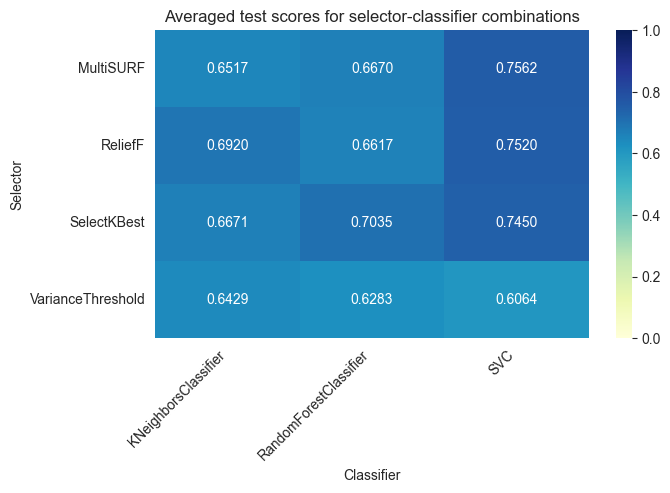

In [185]:
plot_heat_map('./results/b_features_5_fgr_pix_norm_eq_auc_pr_outer_5.csv', True, './results')

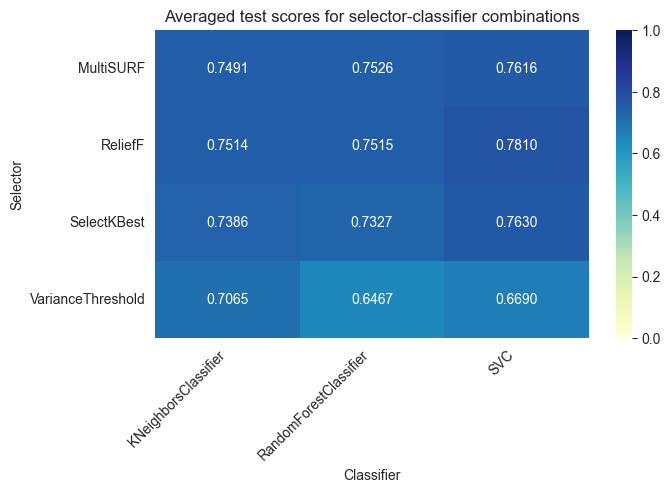

In [222]:
plot_heat_map('./results/b_features_5_fgr_pix_norm_eq_auc_pr_5_10_k_fold.csv', True, './results')

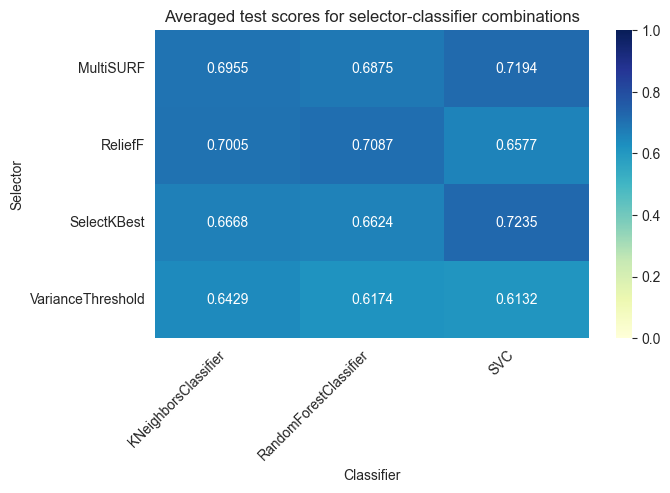

In [187]:
plot_heat_map('./results/b_features_5_fgr_pix_norm_eq_lbp_auc_pr_outer_5.csv', True, './results')

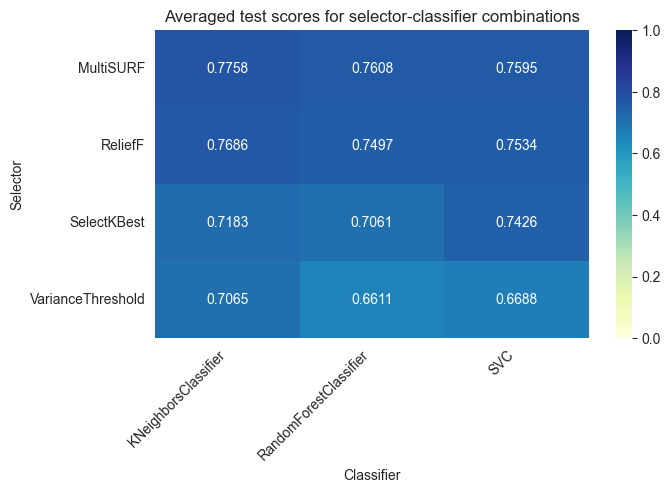

In [124]:
plot_heat_map('./results/b_features_5_fgr_pix_norm_eq_lbp_auc_pr_k_fold_5_10.csv', True, './results')

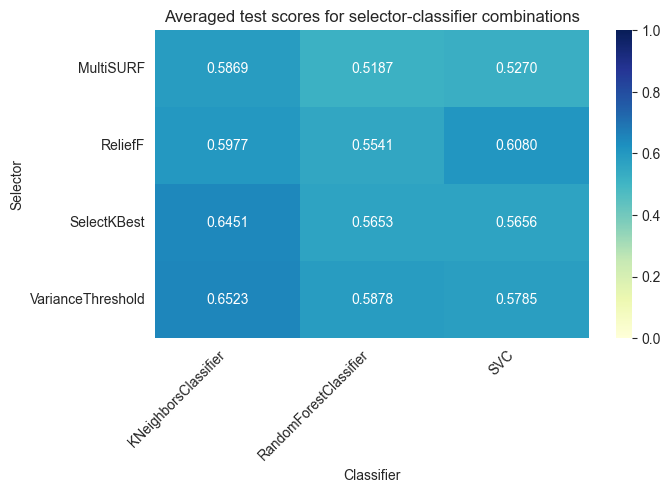

In [52]:
plot_heat_map('./results/b_my_df_3sigma_raw_pe_eq_norm_k_fold_3_10.csv', True, './results')

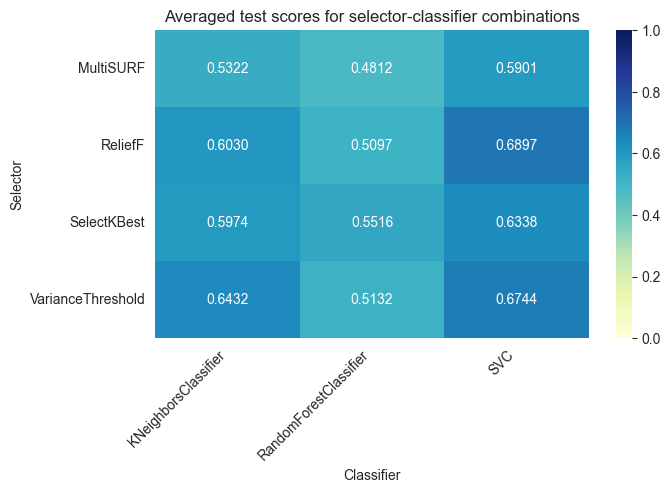

In [254]:
plot_heat_map('./results/b_features_5_pe_pix_norm_eq_auc_pr_k_fold_3_10_kfold.csv', True, './results')

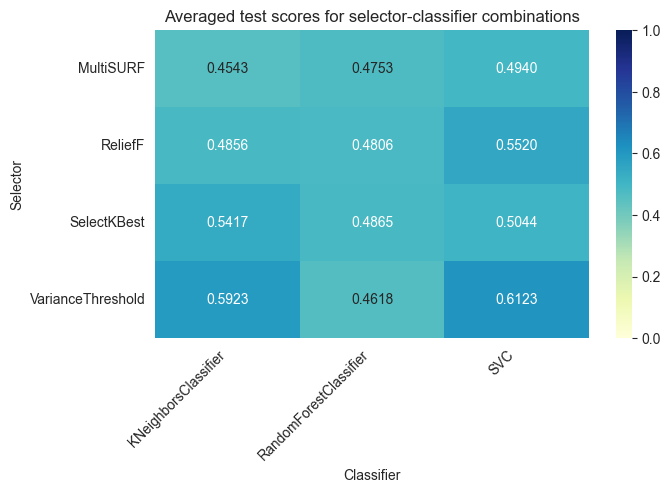

In [190]:
plot_heat_map('./results/b_features_5_pe_pix_norm_eq_auc_pr.csv', True, './results')

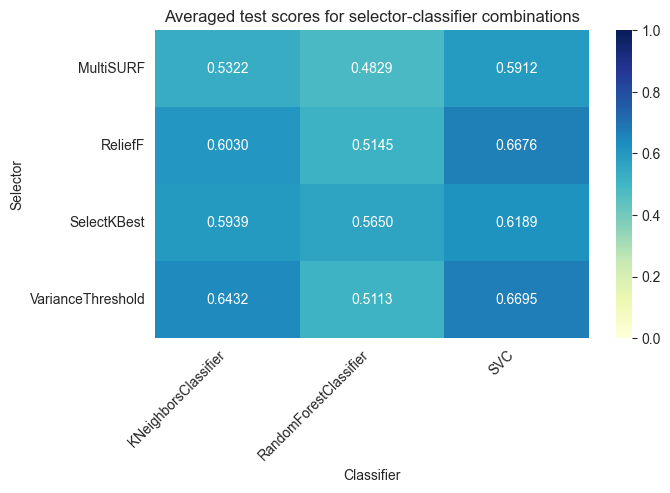

In [256]:
plot_heat_map('./results/b_features_5_pe_pix_norm_eq_lbp_auc_pr_k_fold_3_10_kfold.csv', True, './results')

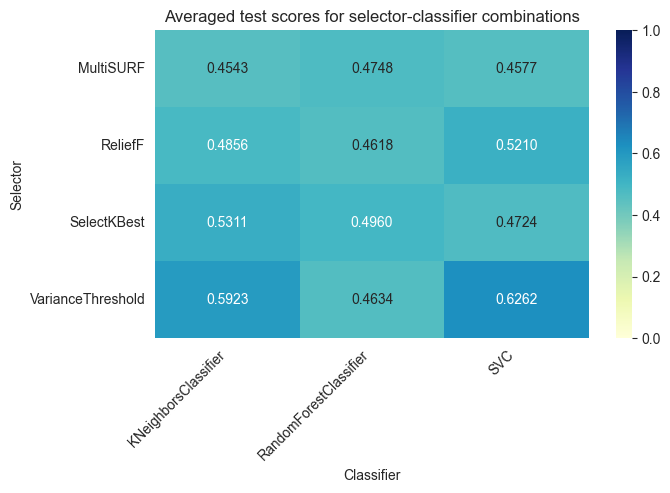

In [193]:
plot_heat_map('./results/b_features_5_pe_pix_norm_eq_lbp_auc_pr.csv', True, './results')

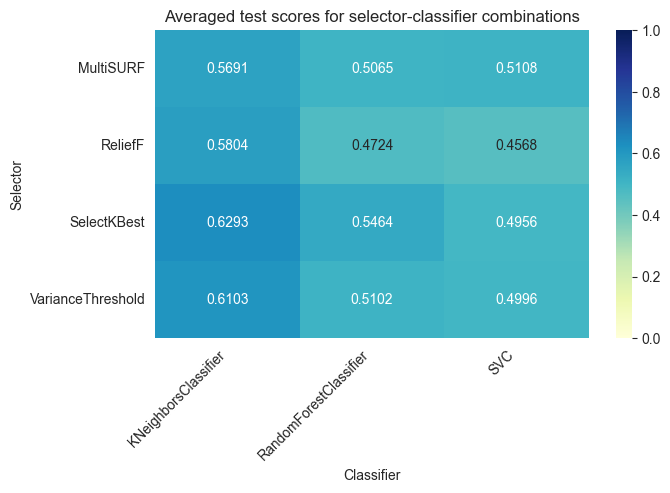

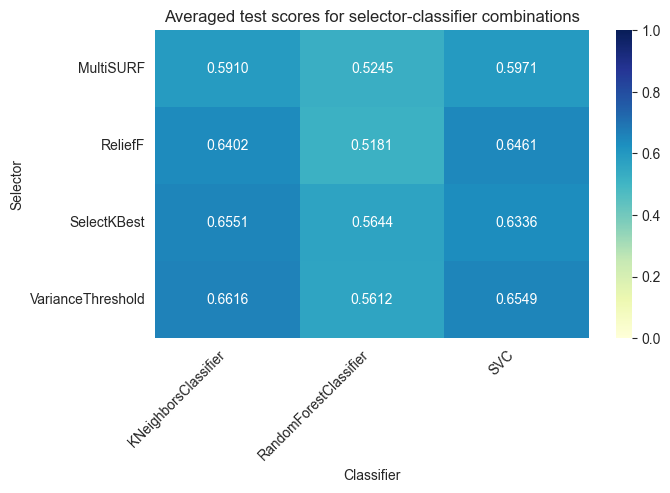

In [83]:
plot_heat_map('./results/b_my_df_3sigma_7_fgr_eq_norm_auc_pr.csv', True, './results')
plot_heat_map('./results/b_my_df_3sigma_7_fgr_eq_norm_k_fold_5_10.csv', True, './results')

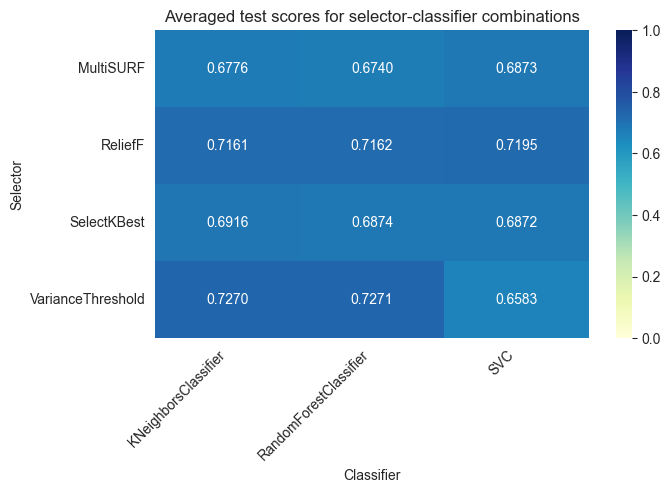

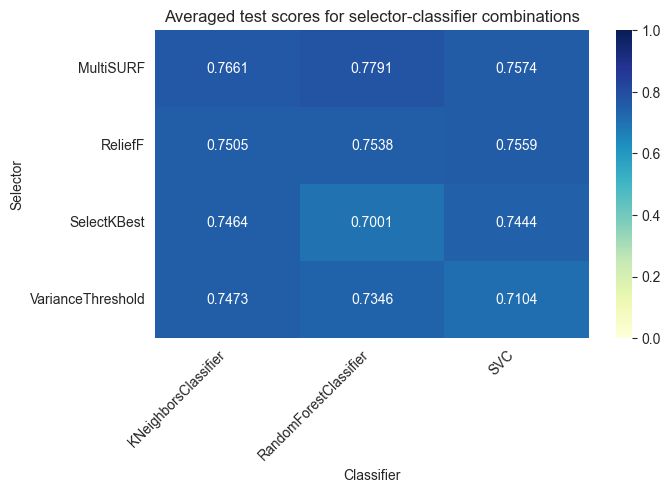

In [86]:
plot_heat_map('./results/b_my_df_3sigma_raw_fgr_eq_norm_auc_pr.csv', True, './results')
plot_heat_map('./results/b_my_df_3sigma_raw_fgr_eq_norm_k_fold_5_10.csv', True, './results')

## Train models

In [109]:
dataframe = features_5_pe_pix_norm_eq
stats_df = pd.read_csv('./results/b_features_5_pe_pix_norm_eq_auc_pr_k_fold_3_10_kfold.csv')
dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

X = dataframe.drop( ["Record ID", "Label","Image", "Pixel spacing x", "ROI pixels"], axis=1).values
y = dataframe['Label'].values.squeeze()

In [110]:
stats_df["selected_features"].iloc[3]  
best_params_row = stats_df.iloc[3]  
random = best_params_row['random_state']
print(random)
best_params_row = best_params_row.iloc[19:]
print(best_params_row)

270
KNeighborsClassifier__metric                 euclidean
KNeighborsClassifier__n_neighbors                  4.0
VarianceThreshold__threshold                  0.219196
ReliefF__n_features_to_select                      NaN
ReliefF__n_neighbors                               NaN
MultiSURF__n_features_to_select                    NaN
SelectKBest__k                                     NaN
SVC__C                                             NaN
SVC__gamma                                         NaN
SVC__kernel                                        NaN
RandomForestClassifier__criterion                  NaN
RandomForestClassifier__max_depth                  NaN
RandomForestClassifier__max_features               NaN
RandomForestClassifier__min_samples_leaf           NaN
RandomForestClassifier__min_samples_split          NaN
RandomForestClassifier__n_estimators               NaN
Name: 3, dtype: object


In [111]:
best_params = {'KNeighborsClassifier__metric': 'euclidean',
               'KNeighborsClassifier__n_neighbors': 4,
               'VarianceThreshold__threshold': 0.219196
              }
pipeline = Pipeline([(VarianceThreshold.__name__, VarianceThreshold()),
                     ('StandardScaler', StandardScaler()),
                     (KNeighborsClassifier.__name__,KNeighborsClassifier())])
pipeline.set_params(**best_params)
pipeline.fit(X, y)

Pipeline(steps=[('VarianceThreshold', VarianceThreshold(threshold=0.219196)),
                ('StandardScaler', StandardScaler()),
                ('KNeighborsClassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=4))])

In [45]:
stats_df.iloc[:19]

random_state                          combination_id  test_score  \
0            102  VarianceThreshold_KNeighborsClassifier    0.741667   
1            435  VarianceThreshold_KNeighborsClassifier    0.698016   
2            860  VarianceThreshold_KNeighborsClassifier    0.613426   
3            270  VarianceThreshold_KNeighborsClassifier    0.683587   
4            106  VarianceThreshold_KNeighborsClassifier    0.479446   
5            102            ReliefF_KNeighborsClassifier    0.682812   
6            435            ReliefF_KNeighborsClassifier    0.649455   
7            860            ReliefF_KNeighborsClassifier    0.591860   
8            270            ReliefF_KNeighborsClassifier    0.683770   
9            106            ReliefF_KNeighborsClassifier    0.407224   
10           102          MultiSURF_KNeighborsClassifier    0.549062   
11           435          MultiSURF_KNeighborsClassifier    0.690608   
12           860          MultiSURF_KNeighborsClassifier    0.449430   
13           270          MultiSURF_KNeighborsClassifier    0.592788   
14           106          MultiSURF_KNeighborsClassifier    0.379287   
15           102        SelectKBest_KNeighborsClassifier    0.591871   
16           435        SelectKBest_KNeighborsClassifier    0.691546   
17           860        SelectKBest_KNeighborsClassifier    0.610742   
18           270        SelectKBest_KNeighborsClassifier    0.675397   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.096465     1.000000         0.000000       0.533984   
1         0.168082     1.000000         0.000000       0.538120   
2         0.081447     1.000000         0.000000       0.458730   
3         0.073140     0.802097         0.083902       0.388471   
4         0.086421     0.934871         0.011793       0.185897   
5         0.184156     1.000000         0.000000       0.535785   
6         0.251071     0.904688         0.042677       0.214425   
7         0.133805     1.000000         0.000000       0.463723   
8         0.100169     0.870641         0.010461       0.429776   
9         0.047726     0.941799         0.028435       0.083333   
10        0.322929     0.918724         0.015328       0.416296   
11        0.172165     1.000000         0.000000       0.526007   
12        0.131954     0.907777         0.035620       0.309524   
13        0.021569     0.874450         0.028836       0.362406   
14        0.114216     0.796830         0.067246       0.233388   
15        0.234202     1.000000         0.000000       0.439594   
16        0.177174     1.000000         0.000000       0.457983   
17        0.154635     0.894723         0.014835       0.426151   
18        0.114175     0.924621         0.043036       0.273944   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k  SVC__C  \
0         1.000000     0.688889      1.000000  ...             NaN     NaN   
1         1.000000     0.594444      1.000000  ...             NaN     NaN   
2         1.000000     0.444444      1.000000  ...             NaN     NaN   
3         0.629952     0.511111      0.537037  ...             NaN     NaN   
4         0.741762     0.166667      0.592593  ...             NaN     NaN   
5         1.000000     0.672222      1.000000  ...             NaN     NaN   
6         0.660831     0.200000      0.509877  ...             NaN     NaN   
7         1.000000     0.472222      1.000000  ...             NaN     NaN   
8         0.780093     0.583333      0.807407  ...             NaN     NaN   
9         0.728055     0.055556      0.587963  ...             NaN     NaN   
10        0.801865     0.405556      0.765432  ...             NaN     NaN   
11        1.000000     0.588889      1.000000  ...             NaN     NaN   
12        0.801684     0.305556      0.763889  ...             NaN     NaN   
13        0.728105     0.350000      0.628395  ...             NaN     NaN   
14        0.635141     0.250000      0.564815  ...  

FGR:

In [112]:
pd.read_csv('./results/b_features_5_fgr_pix_norm_eq_lbp_auc_pr_outer_5.csv')

random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.593643   
1            435    VarianceThreshold_KNeighborsClassifier    0.672103   
2            860    VarianceThreshold_KNeighborsClassifier    0.737086   
3            270    VarianceThreshold_KNeighborsClassifier    0.596712   
4            106    VarianceThreshold_KNeighborsClassifier    0.615020   
5            102              ReliefF_KNeighborsClassifier    0.620760   
6            435              ReliefF_KNeighborsClassifier    0.705763   
7            860              ReliefF_KNeighborsClassifier    0.726645   
8            270              ReliefF_KNeighborsClassifier    0.694898   
9            106              ReliefF_KNeighborsClassifier    0.754216   
10           102            MultiSURF_KNeighborsClassifier    0.692703   
11           435            MultiSURF_KNeighborsClassifier    0.702745   
12           860            MultiSURF_KNeighborsClassifier    0.721907   
13           270            MultiSURF_KNeighborsClassifier    0.686727   
14           106            MultiSURF_KNeighborsClassifier    0.673571   
15           102          SelectKBest_KNeighborsClassifier    0.611145   
16           435          SelectKBest_KNeighborsClassifier    0.715112   
17           860          SelectKBest_KNeighborsClassifier    0.688377   
18           270          SelectKBest_KNeighborsClassifier    0.651066   
19           106          SelectKBest_KNeighborsClassifier    0.668538   
20           102                     VarianceThreshold_SVC    0.596043   
21           435                     VarianceThreshold_SVC    0.693838   
22           860                     VarianceThreshold_SVC    0.626724   
23           270                     VarianceThreshold_SVC    0.613763   
24           106                     VarianceThreshold_SVC    0.535512   
25           102                               ReliefF_SVC    0.690965   
26           435                               ReliefF_SVC    0.633027   
27           860                               ReliefF_SVC    0.649443   
28           270                               ReliefF_SVC    0.650916   
29           106                               ReliefF_SVC    0.664214   
30           102                             MultiSURF_SVC    0.725578   
31           435                             MultiSURF_SVC    0.716983   
32           860                             MultiSURF_SVC    0.804876   
33           270                             MultiSURF_SVC    0.662663   
34           106                             MultiSURF_SVC    0.686662   
35           102                           SelectKBest_SVC    0.703403   
36           435                           SelectKBest_SVC    0.696369   
37           860                           SelectKBest_SVC    0.733959   
38           270                           SelectKBest_SVC    0.756350   
39           106                           SelectKBest_SVC    0.727351   
40           102  VarianceThreshold_RandomForestClassifier    0.593594   
41           435  VarianceThreshold_RandomForestClassifier    0.620861   
42           860  VarianceThreshold_RandomForestClassifier    0.672234   
43           270  VarianceThreshold_RandomForestClassifier    0.609522   
44           106  VarianceThreshold_RandomForestClassifier    0.591027   
45           102            ReliefF_RandomForestClassifier    0.646697   
46           435            ReliefF_RandomForestClassifier    0.698379   
47           860            ReliefF_RandomForestClassifier    0.777750   
48           270            ReliefF_RandomForestClassifier    0.700514   
49           106            ReliefF_RandomForestClassifier    0.720090   
50           102          MultiSURF_RandomForestClassifier    0.749934   
51           435          MultiSURF_RandomForestClassifier    0.710440   
52           860          MultiSURF_RandomForestClassifier    0.702015   
53      

In [118]:
dataframe = features_5_fgr_pix_norm_eq_lbp
dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

X = dataframe.drop( ["Record ID", "Label","Image", "Pixel spacing x", "ROI pixels"], axis=1).values
y = dataframe['Label'].values.squeeze()

stats_df = pd.read_csv('./results/b_features_5_fgr_pix_norm_eq_lbp_auc_pr_k_fold_5_10.csv')

In [114]:
stats_df

random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.682955   
1            435    VarianceThreshold_KNeighborsClassifier    0.750303   
2            860    VarianceThreshold_KNeighborsClassifier    0.734179   
3            270    VarianceThreshold_KNeighborsClassifier    0.710833   
4            106    VarianceThreshold_KNeighborsClassifier    0.654414   
5            102              ReliefF_KNeighborsClassifier    0.741009   
6            435              ReliefF_KNeighborsClassifier    0.747942   
7            860              ReliefF_KNeighborsClassifier    0.794179   
8            270              ReliefF_KNeighborsClassifier    0.758968   
9            106              ReliefF_KNeighborsClassifier    0.800706   
10           102            MultiSURF_KNeighborsClassifier    0.778944   
11           435            MultiSURF_KNeighborsClassifier    0.769593   
12           860            MultiSURF_KNeighborsClassifier    0.811182   
13           270            MultiSURF_KNeighborsClassifier    0.746069   
14           106            MultiSURF_KNeighborsClassifier    0.773082   
15           102          SelectKBest_KNeighborsClassifier    0.733583   
16           435          SelectKBest_KNeighborsClassifier    0.743254   
17           860          SelectKBest_KNeighborsClassifier    0.758643   
18           270          SelectKBest_KNeighborsClassifier    0.657663   
19           106          SelectKBest_KNeighborsClassifier    0.698442   
20           102                     VarianceThreshold_SVC    0.626560   
21           435                     VarianceThreshold_SVC    0.705064   
22           860                     VarianceThreshold_SVC    0.720831   
23           270                     VarianceThreshold_SVC    0.652060   
24           106                     VarianceThreshold_SVC    0.639270   
25           102                               ReliefF_SVC    0.727321   
26           435                               ReliefF_SVC    0.728209   
27           860                               ReliefF_SVC    0.805843   
28           270                               ReliefF_SVC    0.743861   
29           106                               ReliefF_SVC    0.761851   
30           102                             MultiSURF_SVC    0.763443   
31           435                             MultiSURF_SVC    0.736404   
32           860                             MultiSURF_SVC    0.845953   
33           270                             MultiSURF_SVC    0.728721   
34           106                             MultiSURF_SVC    0.722952   
35           102                           SelectKBest_SVC    0.732064   
36           435                           SelectKBest_SVC    0.685041   
37           860                           SelectKBest_SVC    0.818315   
38           270                           SelectKBest_SVC    0.755562   
39           106                           SelectKBest_SVC    0.721946   
40           102  VarianceThreshold_RandomForestClassifier    0.628286   
41           435  VarianceThreshold_RandomForestClassifier    0.722261   
42           860  VarianceThreshold_RandomForestClassifier    0.687111   
43           270  VarianceThreshold_RandomForestClassifier    0.667079   
44           106  VarianceThreshold_RandomForestClassifier    0.600978   
45           102            ReliefF_RandomForestClassifier    0.717822   
46           435            ReliefF_RandomForestClassifier    0.755141   
47           860            ReliefF_RandomForestClassifier    0.803489   
48           270            ReliefF_RandomForestClassifier    0.719978   
49           106            ReliefF_RandomForestClassifier    0.752105   
50           102          MultiSURF_RandomForestClassifier    0.794403   
51           435          MultiSURF_RandomForestClassifier    0.787058   
52           860          MultiSURF_RandomForestClassifier    0.757326   
53      

In [119]:
stats_df["selected_features"].iloc[12]  
best_params_row = stats_df.iloc[12]  
random = best_params_row['random_state']
print(random)
best_params_row = best_params_row.iloc[19:]
print(best_params_row)

860
KNeighborsClassifier__metric                 manhattan
KNeighborsClassifier__n_neighbors                  4.0
VarianceThreshold__threshold                       NaN
ReliefF__n_features_to_select                      NaN
ReliefF__n_neighbors                               NaN
MultiSURF__n_features_to_select                    9.0
SelectKBest__k                                     NaN
SVC__C                                             NaN
SVC__gamma                                         NaN
SVC__kernel                                        NaN
RandomForestClassifier__criterion                  NaN
RandomForestClassifier__max_depth                  NaN
RandomForestClassifier__max_features               NaN
RandomForestClassifier__min_samples_leaf           NaN
RandomForestClassifier__min_samples_split          NaN
RandomForestClassifier__n_estimators               NaN
Name: 12, dtype: object


In [121]:
best_params = {'KNeighborsClassifier__metric': 'manhattan',
               'KNeighborsClassifier__n_neighbors': 4,
               'MultiSURF__n_features_to_select': 9
              }
pipeline = Pipeline([('StandardScaler', StandardScaler()),
                     (MultiSURF.__name__, MultiSURF()),
                     (KNeighborsClassifier.__name__,KNeighborsClassifier())])
pipeline.set_params(**best_params)
pipeline.fit(X, y)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('MultiSURF', MultiSURF(n_features_to_select=9)),
                ('KNeighborsClassifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=4))])

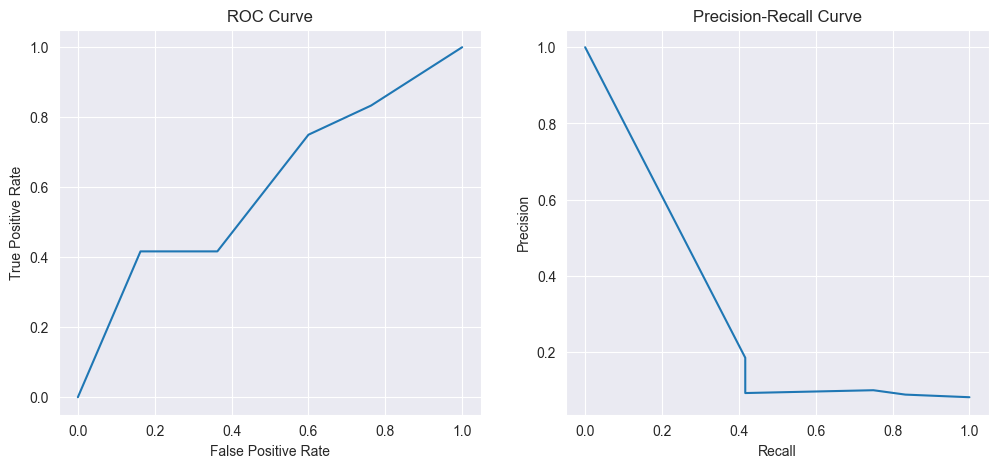

{'f1_score': 0.152, 'recall': 0.417, 'specificity': 0.6370370370370371, 'precision': 0.093, 'average_precision': 0.131, 'auc_roc': 0.6018518518518519, 'auc_pr': 0.301}


In [122]:
dataframe_val = pd.read_csv('../data/anterior/features_5_lbp_val_fgr_pix_norm.csv')

X_val = dataframe_val.drop(["Record ID", "Label", "Image", "Pixel spacing x", "ROI pixels"], axis=1).values
y_val = dataframe_val['Label'].values.squeeze()
prob = pipeline.predict_proba(X_val)[:, 1]
y_pred = pipeline.predict(X_val)
precision, recall, _ = precision_recall_curve(y_val, prob)
auc_pr_ = auc(recall, precision)

plot_combined_curves(y_val, prob)

f1_score = round(metrics.f1_score(y_val, y_pred), 3)
average_precision = round(metrics.average_precision_score(y_val, prob), 3)
auc_pr_ = round(auc_pr(y_val, prob), 3) 
auc_roc = roc_auc_score(y_val, prob)
recall = round(metrics.recall_score(y_val, y_pred), 3)
precision_score = round(metrics.precision_score(y_val, y_pred), 3)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn + fp)

print({"f1_score":f1_score, 
        "recall":recall, 
        "specificity": specificity,
        "precision":precision_score,
        "average_precision": average_precision, 
        "auc_roc":auc_roc, 
        "auc_pr":auc_pr_,
})

In [692]:
print(f"AUC-PR: {auc_pr_}")
print(classification_report(y_val, y_pred))

AUC-PR: 0.30104368033676926
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       135
           1       0.09      0.42      0.15        12

    accuracy                           0.62       147
   macro avg       0.51      0.53      0.45       147
weighted avg       0.86      0.62      0.71       147


In [123]:
dataframe = features_5_fgr_pix_norm_eq
dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

X = dataframe.drop( ["Record ID", "Label","Image", "Pixel spacing x", "ROI pixels"], axis=1).values
y = dataframe['Label'].values.squeeze()

In [124]:
stats_df = pd.read_csv('./results/b_features_5_fgr_pix_norm_eq_auc_pr_5_10_k_fold.csv')
stats_df["selected_features"].iloc[27]  

"['original_firstorder_90Percentile', 'original_firstorder_Energy_pix_norm', 'original_firstorder_RootMeanSquared', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_ngtdm_Busyness', 'original_firstorder_10Percentile']"

In [239]:
stats_df 

random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.682955   
1            435    VarianceThreshold_KNeighborsClassifier    0.750303   
2            860    VarianceThreshold_KNeighborsClassifier    0.734179   
3            270    VarianceThreshold_KNeighborsClassifier    0.710833   
4            106    VarianceThreshold_KNeighborsClassifier    0.654414   
5            102              ReliefF_KNeighborsClassifier    0.768361   
6            435              ReliefF_KNeighborsClassifier    0.768527   
7            860              ReliefF_KNeighborsClassifier    0.728041   
8            270              ReliefF_KNeighborsClassifier    0.760556   
9            106              ReliefF_KNeighborsClassifier    0.731383   
10           102            MultiSURF_KNeighborsClassifier    0.761338   
11           435            MultiSURF_KNeighborsClassifier    0.751764   
12           860            MultiSURF_KNeighborsClassifier    0.788010   
13           270            MultiSURF_KNeighborsClassifier    0.710565   
14           106            MultiSURF_KNeighborsClassifier    0.734073   
15           102          SelectKBest_KNeighborsClassifier    0.709684   
16           435          SelectKBest_KNeighborsClassifier    0.783141   
17           860          SelectKBest_KNeighborsClassifier    0.744976   
18           270          SelectKBest_KNeighborsClassifier    0.729394   
19           106          SelectKBest_KNeighborsClassifier    0.726052   
20           102                     VarianceThreshold_SVC    0.626560   
21           435                     VarianceThreshold_SVC    0.705064   
22           860                     VarianceThreshold_SVC    0.720831   
23           270                     VarianceThreshold_SVC    0.652060   
24           106                     VarianceThreshold_SVC    0.640460   
25           102                               ReliefF_SVC    0.762870   
26           435                               ReliefF_SVC    0.786404   
27           860                               ReliefF_SVC    0.842560   
28           270                               ReliefF_SVC    0.782301   
29           106                               ReliefF_SVC    0.730718   
30           102                             MultiSURF_SVC    0.759277   
31           435                             MultiSURF_SVC    0.736404   
32           860                             MultiSURF_SVC    0.845953   
33           270                             MultiSURF_SVC    0.743643   
34           106                             MultiSURF_SVC    0.722952   
35           102                           SelectKBest_SVC    0.723178   
36           435                           SelectKBest_SVC    0.737245   
37           860                           SelectKBest_SVC    0.833010   
38           270                           SelectKBest_SVC    0.784814   
39           106                           SelectKBest_SVC    0.736896   
40           102  VarianceThreshold_RandomForestClassifier    0.607233   
41           435  VarianceThreshold_RandomForestClassifier    0.657973   
42           860  VarianceThreshold_RandomForestClassifier    0.706452   
43           270  VarianceThreshold_RandomForestClassifier    0.660191   
44           106  VarianceThreshold_RandomForestClassifier    0.601818   
45           102            ReliefF_RandomForestClassifier    0.786591   
46           435            ReliefF_RandomForestClassifier    0.769845   
47           860            ReliefF_RandomForestClassifier    0.725001   
48           270            ReliefF_RandomForestClassifier    0.743671   
49           106            ReliefF_RandomForestClassifier    0.732444   
50           102          MultiSURF_RandomForestClassifier    0.751146   
51           435          MultiSURF_RandomForestClassifier    0.774407   
52           860          MultiSURF_RandomForestClassifier    0.746420   
53      

In [125]:
stats_df = pd.read_csv('./results/b_features_5_fgr_pix_norm_eq_auc_pr_5_10_k_fold.csv')
stats_df
best_params_row = stats_df.iloc[27]  
random = best_params_row['random_state']
print(random)
best_params_row = best_params_row.iloc[19:]
print(best_params_row)

860
KNeighborsClassifier__metric                    NaN
KNeighborsClassifier__n_neighbors               NaN
VarianceThreshold__threshold                    NaN
ReliefF__n_features_to_select                   7.0
ReliefF__n_neighbors                            1.0
MultiSURF__n_features_to_select                 NaN
SelectKBest__k                                  NaN
SVC__C                                       2.5158
SVC__gamma                                     10.0
SVC__kernel                                  linear
RandomForestClassifier__criterion               NaN
RandomForestClassifier__max_depth               NaN
RandomForestClassifier__max_features            NaN
RandomForestClassifier__min_samples_leaf        NaN
RandomForestClassifier__min_samples_split       NaN
RandomForestClassifier__n_estimators            NaN
Name: 27, dtype: object


In [126]:
best_params = {'SVC__C': 2.5158, 
               'SVC__kernel': 'linear',
               'SVC__gamma': 10,
               'ReliefF__n_features_to_select': 7,
               'ReliefF__n_neighbors': 1}
pipeline = Pipeline([('StandardScaler', StandardScaler()),
                     (ReliefF.__name__,ReliefF()),
                     (SVC.__name__, SVC(probability=True, random_state=random))])
pipeline.set_params(**best_params)
pipeline.fit(X, y)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('ReliefF', ReliefF(n_features_to_select=7, n_neighbors=1)),
                ('SVC',
                 SVC(C=2.5158, gamma=10, kernel='linear', probability=True,
                     random_state=860))])

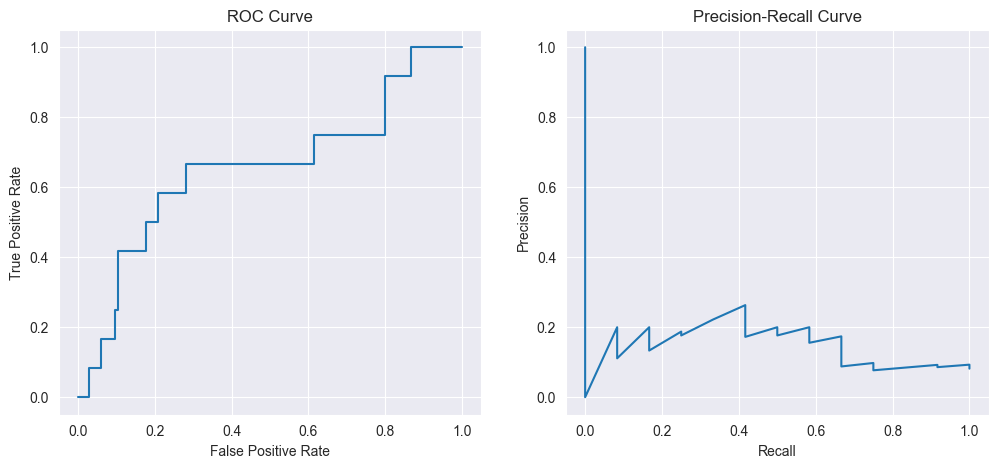

{'f1_score': 0.19, 'recall': 0.667, 'specificity': 0.5259259259259259, 'precision': 0.111, 'average_precision': 0.168, 'auc_roc': 0.6549382716049383, 'auc_pr': 0.146}


In [127]:
dataframe_val = pd.read_csv('../data/anterior/features_5_fgr_val_pix_norm.csv')

X_val = dataframe_val.drop(["Record ID", "Label", "Image", "Pixel spacing x", "ROI pixels"], axis=1).values
y_val = dataframe_val['Label'].values.squeeze()
prob = pipeline.predict_proba(X_val)[:, 1]
y_pred = pipeline.predict(X_val)
precision, recall, _ = precision_recall_curve(y_val, prob)
auc_pr_ = auc(recall, precision)

plot_combined_curves(y_val, prob)

f1_score = round(metrics.f1_score(y_val, y_pred), 3)
average_precision = round(metrics.average_precision_score(y_val, prob), 3)
auc_pr_ = round(auc_pr(y_val, prob), 3) 
auc_roc = roc_auc_score(y_val, prob)
recall = round(metrics.recall_score(y_val, y_pred), 3)
precision_score = round(metrics.precision_score(y_val, y_pred), 3)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn + fp)

print({"f1_score":f1_score, 
        "recall":recall, 
        "specificity": specificity,
        "precision":precision_score,
        "average_precision": average_precision, 
        "auc_roc":auc_roc, 
        "auc_pr":auc_pr_,
})

In [128]:
confusion_matrix(y_val, y_pred)

array([[71, 64],
       [ 4,  8]], dtype=int64)

In [246]:
print(f"AUC-PR: {auc_pr_}")
print(classification_report(y_val, y_pred))

AUC-PR: 0.14574670250220287
              precision    recall  f1-score   support

           0       0.95      0.53      0.68       135
           1       0.11      0.67      0.19        12

    accuracy                           0.54       147
   macro avg       0.53      0.60      0.43       147
weighted avg       0.88      0.54      0.64       147


### Pyradiomics features (imbalanced)

In [ ]:
apply_k_fold_cv(features_11_all_norm_filtered, auc_pr, "_features_11_all_norm_filtered_auc_pr_5_k_fold.csv",  n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_11_all_norm_filtered, auc_pr, "_features_11_all_norm_filtered_auc_pr_5_k_fold.csv",  n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_11_all_norm, auc_pr, "_features_11_all_norm_uc_pr_5_k_fold.csv",  n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_11_all_norm, auc_pr, "_features_11_all_norm_uc_pr_5_k_fold.csv",  n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_11_all_fgr_norm, auc_pr, "_features_11_all_fgr_norm_auc_pr_5_k_fold.csv",  n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_11_all_fgr_norm, auc_pr, "_features_11_all_fgr_norm_auc_pr_5_k_fold.csv",  n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_11_all_fgr_norm_filtered, auc_pr, "_features_11_all_fgr_norm_filtered_auc_pr_5_k_fold.csv",  n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_11_ant_fgr_norm, auc_pr, "_features_11_ant_fgr_norm_auc_pr_5_k_fold.csv",  n_splits=5, smote=False)

In [257]:
pd.read_csv('./results/_features_11_ant_fgr_norm_auc_pr_5_k_fold.csv')

random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            860              VarianceThreshold_RUSBoostClassifier   
3            270              VarianceThreshold_RUSBoostClassifier   
4            106              VarianceThreshold_RUSBoostClassifier   
5            102                        ReliefF_RUSBoostClassifier   
6            435                        ReliefF_RUSBoostClassifier   
7            860                        ReliefF_RUSBoostClassifier   
8            270                        ReliefF_RUSBoostClassifier   
9            106                        ReliefF_RUSBoostClassifier   
10           102                      MultiSURF_RUSBoostClassifier   
11           435                      MultiSURF_RUSBoostClassifier   
12           860                      MultiSURF_RUSBoostClassifier   
13           270                      MultiSURF_RUSBoostClassifier   
14           106                      MultiSURF_RUSBoostClassifier   
15           102                    SelectKBest_RUSBoostClassifier   
16           435                    SelectKBest_RUSBoostClassifier   
17           860                    SelectKBest_RUSBoostClassifier   
18           270                    SelectKBest_RUSBoostClassifier   
19           106                    SelectKBest_RUSBoostClassifier   
20           102                             VarianceThreshold_SVC   
21           435                             VarianceThreshold_SVC   
22           860                             VarianceThreshold_SVC   
23           270                             VarianceThreshold_SVC   
24           106                             VarianceThreshold_SVC   
25           102                                       ReliefF_SVC   
26           435                                       ReliefF_SVC   
27           860                                       ReliefF_SVC   
28           270                                       ReliefF_SVC   
29           106                                       ReliefF_SVC   
30           102                                     MultiSURF_SVC   
31           435                                     MultiSURF_SVC   
32           860                                     MultiSURF_SVC   
33           270                                     MultiSURF_SVC   
34           106                                     MultiSURF_SVC   
35           102                                   SelectKBest_SVC   
36           435                                   SelectKBest_SVC   
37           860                                   SelectKBest_SVC   
38           270                                   SelectKBest_SVC   
39           106                                   SelectKBest_SVC   
40           102  VarianceThreshold_BalancedRandomForestClassifier   
41           435  VarianceThreshold_BalancedRandomForestClassifier   
42           860  VarianceThreshold_BalancedRandomForestClassifier   
43           270  VarianceThreshold_BalancedRandomForestClassifier   
44           106  VarianceThreshold_BalancedRandomForestClassifier   
45           102            ReliefF_BalancedRandomForestClassifier   
46           435            ReliefF_BalancedRandomForestClassifier   
47           860            ReliefF_BalancedRandomForestClassifier   
48           270            ReliefF_BalancedRandomForestClassifier   
49           106            ReliefF_BalancedRandomForestClassifier   
50           102          MultiSURF_BalancedRandomForestClassifier   
51           435          MultiSURF_BalancedRandomForestClassifier   
52           860          MultiSURF_BalancedRandomForestClassifier   
53           270          MultiSURF_BalancedRandomForestClassifier   
54           106          MultiSURF_BalancedRandomForestClassifier   
55           102        SelectKBest_BalancedRandomForestClassifier   
56           4

In [ ]:
apply_k_fold_cv(features_12_fgr_pix_norm, auc_pr, "_features_12_fgr_pix_norm_auc_pr_k_fold.csv",  n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_12_fgr_pix_norm, auc_pr, "_features_12_fgr_pix_norm_auc_pr_k_fold.csv",  n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_12_fgr_pix_norm_filtered, auc_pr, "_features_12_fgr_pix_norm_auc_pr_k_fold.csv",  n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_12_fgr_pix_norm_filtered, auc_pr, "_features_12_fgr_pix_norm_auc_pr_k_fold.csv",  n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_5_fgr_pix_norm, auc_pr, "_features_5_fgr_pix_norm_auc_pr_5_10_k_fold.csv", size_random_states = 3, n_splits=5, smote=False)

In [4]:
pd.read_csv('./results/_features_5_fgr_pix_norm_auc_pr_5_10_k_fold.csv')

random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            860              VarianceThreshold_RUSBoostClassifier   
3            102                        ReliefF_RUSBoostClassifier   
4            435                        ReliefF_RUSBoostClassifier   
5            860                        ReliefF_RUSBoostClassifier   
6            102                      MultiSURF_RUSBoostClassifier   
7            435                      MultiSURF_RUSBoostClassifier   
8            860                      MultiSURF_RUSBoostClassifier   
9            102                    SelectKBest_RUSBoostClassifier   
10           435                    SelectKBest_RUSBoostClassifier   
11           860                    SelectKBest_RUSBoostClassifier   
12           102                             VarianceThreshold_SVC   
13           435                             VarianceThreshold_SVC   
14           860                             VarianceThreshold_SVC   
15           102                                       ReliefF_SVC   
16           435                                       ReliefF_SVC   
17           860                                       ReliefF_SVC   
18           102                                     MultiSURF_SVC   
19           435                                     MultiSURF_SVC   
20           860                                     MultiSURF_SVC   
21           102                                   SelectKBest_SVC   
22           435                                   SelectKBest_SVC   
23           860                                   SelectKBest_SVC   
24           102  VarianceThreshold_BalancedRandomForestClassifier   
25           435  VarianceThreshold_BalancedRandomForestClassifier   
26           860  VarianceThreshold_BalancedRandomForestClassifier   
27           102            ReliefF_BalancedRandomForestClassifier   
28           435            ReliefF_BalancedRandomForestClassifier   
29           860            ReliefF_BalancedRandomForestClassifier   
30           102          MultiSURF_BalancedRandomForestClassifier   
31           435          MultiSURF_BalancedRandomForestClassifier   
32           860          MultiSURF_BalancedRandomForestClassifier   
33           102        SelectKBest_BalancedRandomForestClassifier   
34           435        SelectKBest_BalancedRandomForestClassifier   
35           860        SelectKBest_BalancedRandomForestClassifier   

    test_score  test_score_std  train_score  train_score_std  test_f1_score  \
0     0.146397        0.106253     0.309277         0.024575       0.130056   
1     0.130649        0.068599     0.339073         0.018567       0.126364   
2     0.166911        0.072203     0.447610         0.113699       0.216956   
3     0.106698        0.060785     0.311319         0.024490       0.130818   
4     0.117344        0.074168     0.493935         0.061416       0.114235   
5     0.101626        0.045694     0.419616         0.104372       0.128831   
6     0.115964        0.072080     0.246171         0.024797       0.108624   
7     0.131419        0.071074     0.346032         0.084239       0.131279   
8     0.141556        0.069865     0.761139         0.222211       0.111903   
9     0.129860        0.082669     0.645111         0.084498       0.098698   
10    0.168326        0.067660     0.288087         0.028483       0.147318   
11    0.141259        0.071373     0.858545         0.083040       0.120290   
12    0.110168        0.057808     0.281879         0.414673       0.029412   
13    0.125139        0.052791     0.118722         0.124661       0.105556   
14    0.112385        0.055872     0.200999         0.033607       0.136555   
15    0.138716        0.071631     0.281001         0.415165       0.148947   
16    0.117000        0.089274     0.121276         0.067776       0.1

In [ ]:
apply_k_fold_cv(features_5_fgr_pix_norm, auc_pr, "_features_5_fgr_pix_norm_auc_pr_5_10_k_fold.csv", size_random_states = 3, n_splits=5, smote=True)

In [6]:
pd.read_csv('./results/_smote_features_5_fgr_pix_norm_auc_pr_5_10_k_fold.csv')

random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.165894   
1            435    VarianceThreshold_KNeighborsClassifier    0.164816   
2            860    VarianceThreshold_KNeighborsClassifier    0.130277   
3            102              ReliefF_KNeighborsClassifier    0.204482   
4            435              ReliefF_KNeighborsClassifier    0.209748   
5            860              ReliefF_KNeighborsClassifier    0.156826   
6            102            MultiSURF_KNeighborsClassifier    0.092471   
7            435            MultiSURF_KNeighborsClassifier    0.189202   
8            860            MultiSURF_KNeighborsClassifier    0.167433   
9            102          SelectKBest_KNeighborsClassifier    0.113060   
10           435          SelectKBest_KNeighborsClassifier    0.242024   
11           860          SelectKBest_KNeighborsClassifier    0.113338   
12           102                     VarianceThreshold_SVC    0.093790   
13           435                     VarianceThreshold_SVC    0.091466   
14           860                     VarianceThreshold_SVC    0.099894   
15           102                               ReliefF_SVC    0.104556   
16           435                               ReliefF_SVC    0.124805   
17           860                               ReliefF_SVC    0.137328   
18           102                             MultiSURF_SVC    0.095106   
19           435                             MultiSURF_SVC    0.126327   
20           860                             MultiSURF_SVC    0.141202   
21           102                           SelectKBest_SVC    0.089468   
22           435                           SelectKBest_SVC    0.134500   
23           860                           SelectKBest_SVC    0.130063   
24           102  VarianceThreshold_RandomForestClassifier    0.087781   
25           435  VarianceThreshold_RandomForestClassifier    0.086973   
26           860  VarianceThreshold_RandomForestClassifier    0.108086   
27           102            ReliefF_RandomForestClassifier    0.125488   
28           435            ReliefF_RandomForestClassifier    0.092274   
29           860            ReliefF_RandomForestClassifier    0.112125   
30           102          MultiSURF_RandomForestClassifier    0.085863   
31           435          MultiSURF_RandomForestClassifier    0.089735   
32           860          MultiSURF_RandomForestClassifier    0.128819   
33           102        SelectKBest_RandomForestClassifier    0.105790   
34           435        SelectKBest_RandomForestClassifier    0.089611   
35           860        SelectKBest_RandomForestClassifier    0.152379   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.080467     1.000000         0.000000       0.096753   
1         0.066124     1.000000         0.000000       0.095638   
2         0.035816     0.991932         0.009680       0.106727   
3         0.074927     1.000000         0.000000       0.109273   
4         0.049937     1.000000         0.000000       0.112288   
5         0.037878     0.404746         0.044338       0.133988   
6         0.041577     0.834503         0.085802       0.103757   
7         0.068563     1.000000         0.000000       0.099416   
8         0.016750     0.906268         0.056145       0.130525   
9         0.062070     0.901947         0.027066       0.070854   
10        0.042852     1.000000         0.000000       0.146726   
11        0.065966     0.878962         0.051562       0.094946   
12        0.058027     1.000000         0.000000       0.000000   
13        0.045786     0.215525         0.012886       0.140696   
14        0.040541     0.204798         0.026156       0.126546   
15        0.046356     1.000000         0.000000       0.000000   
16        0.091922     0.128820         0.022148       0.157007   
17        0.123580     0.136315         0.023028       0.10

In [166]:
apply_k_fold_cv(features_5_pe_pix_norm, auc_pr, "_features_5_pe_pix_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=4, smote=False)

In [ ]:
apply_k_fold_cv(features_5_pe_pix_norm, auc_pr, "_features_5_pe_pix_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=4, smote=True)

In [267]:
features_5_lbp_pix_norm= pd.read_csv('../data/anterior/features_5_lbp_pix_norm.csv')

In [ ]:
apply_k_fold_cv(features_5_lbp_pix_norm, auc_pr, "_features_5_pe_pix_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=4, smote=True)

In [ ]:
apply_k_fold_cv(features_5_lbp_pix_norm, auc_pr, "_features_5_pe_pix_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=4, smote=False)

In [ ]:
apply_k_fold_cv(features_3_ant_zscore_fgr_norm, auc_pr, "_features_3_ant_zscore_fgr_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_3_ant_zscore_fgr_norm_filtered, auc_pr, "_features_3_ant_zscore_fgr_norm_filtered_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(my_df_3_sigma8_fgr_norm, auc_pr, "_my_df_3_sigma8_fgr_norm_fgr_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(my_df_3_sigma8_fgr_norm, auc_pr, "_my_df_3_sigma8_fgr_norm_fgr_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3_sigma8_fgr_norm_filtered, auc_pr, "_my_df_3_sigma8_fgr_norm_filtered_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3_sigma8_fgr_norm_filtered, auc_pr, "_my_df_3_sigma8_fgr_norm_filtered_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_3_fgr, auc_pr, "_features_3_fgr_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_3_fgr, auc_pr, "_features_3_fgr_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_3_fgr_pix_norm_lbp, auc_pr, "_features_3_fgr_lbp_pix_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(features_3_fgr_pix_norm_lbp, auc_pr, "_features_3_fgr_lbp_pix_norm_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_3_fgr_filtered, auc_pr, "_features_3_fgr_filtered_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_3_fgr_pix_norm_lbp, auc_pr, "_features_3_fgr_pix_norm_lbp_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_3_fgr_lbp_all_norm, auc_pr, "_features_3_fgr_lbp_pix_all_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5 , smote=False)

In [ ]:
apply_k_fold_cv(features_10_fgr_norm, auc_pr, "_features_10_fgr_filtered_auc_pr_5_10_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_1_norm, auc_pr, "_features_1_pix_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_1_norm_filtered, auc_pr, "_filtered_features_1_pix_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_1_fgr_norm, auc_pr, "_features_1_fgr_pix_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_1_fgr_norm_filtered, auc_pr, "_filtered_features_1_fgr_norm_auc_pr.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(features_1_pe_norm, auc_pr, "_features_1_fgr_norm_auc_pr.csv", size_random_states = 2, n_splits=4, smote=False)

In [104]:
apply_k_fold_cv(features_2_norm, auc_pr, "features_2_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)

kfold with smote? False
random_state VarianceThreshold_RUSBoostClassifier


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   53.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  9.4min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   38.4s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  8.7min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   15.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   31.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  9.2min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_BalancedRandomForestClassifier
Execution time: 2025.2228083610535 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   47.2s finished


random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            102                        ReliefF_RUSBoostClassifier   
3            435                        ReliefF_RUSBoostClassifier   
4            102                      MultiSURF_RUSBoostClassifier   
5            435                      MultiSURF_RUSBoostClassifier   
6            102                    SelectKBest_RUSBoostClassifier   
7            435                    SelectKBest_RUSBoostClassifier   
8            102                             VarianceThreshold_SVC   
9            435                             VarianceThreshold_SVC   
10           102                                       ReliefF_SVC   
11           435                                       ReliefF_SVC   
12           102                                     MultiSURF_SVC   
13           435                                     MultiSURF_SVC   
14           102                                   SelectKBest_SVC   
15           435                                   SelectKBest_SVC   
16           102  VarianceThreshold_BalancedRandomForestClassifier   
17           435  VarianceThreshold_BalancedRandomForestClassifier   
18           102            ReliefF_BalancedRandomForestClassifier   
19           435            ReliefF_BalancedRandomForestClassifier   
20           102          MultiSURF_BalancedRandomForestClassifier   
21           435          MultiSURF_BalancedRandomForestClassifier   
22           102        SelectKBest_BalancedRandomForestClassifier   
23           435        SelectKBest_BalancedRandomForestClassifier   

    test_score  test_score_std  train_score  train_score_std  test_f1_score  \
0     0.168664        0.092881     0.685003         0.047287       0.183159   
1     0.188792        0.071248     0.819839         0.035218       0.175673   
2     0.245214        0.068162     0.373034         0.042813       0.275291   
3     0.217846        0.043473     0.367301         0.073183       0.258007   
4     0.180293        0.068454     0.969149         0.032742       0.178135   
5     0.184859        0.074877     0.305256         0.026446       0.218380   
6     0.199965        0.097223     0.999345         0.001310       0.183563   
7     0.223664        0.122043     0.682143         0.106348       0.214732   
8     0.166778        0.075640     0.487306         0.034970       0.213639   
9     0.158555        0.071050     0.548828         0.037755       0.220810   
10    0.211266        0.077283     0.304906         0.038214       0.245313   
11    0.173015        0.067618     0.414776         0.035490       0.256711   
12    0.182523        0.113346     0.816653         0.366695       0.096702   
13    0.169227        0.042957     0.624907         0.459395       0.000000   
14    0.170264        0.081684     0.442308         0.455414       0.077333   
15    0.170028        0.065797     0.436134         0.056446       0.234790   
16    0.180028        0.102308     0.926549         0.019461       0.239803   
17    0.201928        0.078853     0.868082         0.014549       0.253335   
18    0.197142        0.104711     0.664145         0.034352       0.255438   
19    0.204878        0.090991     0.489865         0.039163       0.284679   
20    0.149426        0.061859     0.742476         0.082037       0.244940   
21    0.162987        0.064902     0.875317         0.051418       0.217652   
22    0.166733        0.075640     0.846892         0.045626       0.247005   
23    0.162234        0.052931     0.804879         0.046692       0.246292   

    train_f1_score  test_recall  train_recall  ...     SVC__C  SVC__gamma  \
0         0.623000     0.260317      0.852023  ...        NaN         NaN   
1         0.693108     0.245714      0.976702  ...        NaN         NaN   
2         0.344871     0.732063      0.910177 

In [105]:
apply_k_fold_cv(features_2_norm, auc_pr, "features_2_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

kfold with smote? True
random_state VarianceThreshold_KNeighborsClassifier


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    5.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   59.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 26.0min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 25.9min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   19.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   32.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.5min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 26.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RandomForestClassifier
Execution time: 5052.363439083099 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   46.0s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.252463   
1            435    VarianceThreshold_KNeighborsClassifier    0.244922   
2            102              ReliefF_KNeighborsClassifier    0.209777   
3            435              ReliefF_KNeighborsClassifier    0.244617   
4            102            MultiSURF_KNeighborsClassifier    0.248224   
5            435            MultiSURF_KNeighborsClassifier    0.318597   
6            102          SelectKBest_KNeighborsClassifier    0.196896   
7            435          SelectKBest_KNeighborsClassifier    0.259014   
8            102                     VarianceThreshold_SVC    0.164899   
9            435                     VarianceThreshold_SVC    0.164752   
10           102                               ReliefF_SVC    0.199388   
11           435                               ReliefF_SVC    0.188706   
12           102                             MultiSURF_SVC    0.189501   
13           435                             MultiSURF_SVC    0.201142   
14           102                           SelectKBest_SVC    0.203373   
15           435                           SelectKBest_SVC    0.208662   
16           102  VarianceThreshold_RandomForestClassifier    0.193708   
17           435  VarianceThreshold_RandomForestClassifier    0.197853   
18           102            ReliefF_RandomForestClassifier    0.162944   
19           435            ReliefF_RandomForestClassifier    0.153226   
20           102          MultiSURF_RandomForestClassifier    0.184007   
21           435          MultiSURF_RandomForestClassifier    0.202991   
22           102        SelectKBest_RandomForestClassifier    0.183865   
23           435        SelectKBest_RandomForestClassifier    0.164785   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.050799     1.000000     0.000000e+00       0.173724   
1         0.025583     1.000000     0.000000e+00       0.164866   
2         0.111090     0.974298     1.836632e-02       0.177639   
3         0.085776     0.995560     2.296089e-03       0.187382   
4         0.113849     0.895747     9.360667e-03       0.229453   
5         0.091474     1.000000     0.000000e+00       0.239175   
6         0.103601     0.885623     2.186430e-02       0.221553   
7         0.055792     1.000000     0.000000e+00       0.179426   
8         0.077009     0.602648     1.928725e-02       0.217198   
9         0.073243     0.487096     2.997923e-02       0.253220   
10        0.116700     0.622298     7.807041e-02       0.184759   
11        0.114478     0.658399     9.556720e-02       0.197695   
12        0.073636     0.425237     1.771864e-02       0.249667   
13        0.105190     0.229023     1.709273e-02       0.226216   
14        0.111896     0.214415     2.710575e-02       0.237177   
15        0.115810     0.245221     2.374537e-02       0.235716   
16        0.110865     0.964496     2.690332e-02       0.178649   
17        0.062666     0.986550     5.979006e-03       0.190682   
18        0.128475     0.983697     1.128380e-02       0.152245   
19        0.069915     0.999880     2.399336e-04       0.129485   
20        0.082376     0.949568     1.092346e-02       0.231322   
21        0.060939     0.838830     2.169432e-02       0.258076   
22        0.074874     1.000000     1.790181e-16       0.184601   
23        0.041668     0.804462     4.157100e-02       0.209420   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         1.000000     0.249841      1.000000  ...             NaN        NaN   
1         1.000000     0.262063      1.000000  ...             NaN        NaN   
2         0.597375     0.291111      0.994203  ...             NaN        NaN   
3         0.993043     0.246508      0.986206  ...             NaN        NaN   
4         0.652580     0.295556      0.903380  ...             NaN      

In [ ]:
apply_k_fold_cv(features_2_norm_filtered, auc_pr, "_filtered_features_2_norm_auc_pr.csv", size_random_states=2, n_splits=5)

In [ ]:
apply_k_fold_cv(features_2_norm_filtered, auc_pr, "_filtered_features_2_norm_auc_pr.csv", size_random_states=2, n_splits=5, smote=True)

In [103]:
apply_k_fold_cv(features_2_fgr_norm, auc_pr, "_features_2_fgr_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)

kfold with smote? False
random_state VarianceThreshold_RUSBoostClassifier


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   50.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  9.9min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    7.2s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   34.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  9.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   32.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   56.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  9.1min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_BalancedRandomForestClassifier
Execution time: 2090.714420080185 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   48.0s finished


random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            102                        ReliefF_RUSBoostClassifier   
3            435                        ReliefF_RUSBoostClassifier   
4            102                      MultiSURF_RUSBoostClassifier   
5            435                      MultiSURF_RUSBoostClassifier   
6            102                    SelectKBest_RUSBoostClassifier   
7            435                    SelectKBest_RUSBoostClassifier   
8            102                             VarianceThreshold_SVC   
9            435                             VarianceThreshold_SVC   
10           102                                       ReliefF_SVC   
11           435                                       ReliefF_SVC   
12           102                                     MultiSURF_SVC   
13           435                                     MultiSURF_SVC   
14           102                                   SelectKBest_SVC   
15           435                                   SelectKBest_SVC   
16           102  VarianceThreshold_BalancedRandomForestClassifier   
17           435  VarianceThreshold_BalancedRandomForestClassifier   
18           102            ReliefF_BalancedRandomForestClassifier   
19           435            ReliefF_BalancedRandomForestClassifier   
20           102          MultiSURF_BalancedRandomForestClassifier   
21           435          MultiSURF_BalancedRandomForestClassifier   
22           102        SelectKBest_BalancedRandomForestClassifier   
23           435        SelectKBest_BalancedRandomForestClassifier   

    test_score  test_score_std  train_score  train_score_std  test_f1_score  \
0     0.089378        0.051426     0.585152         0.091723       0.050682   
1     0.115045        0.088968     0.447899         0.062533       0.164160   
2     0.145662        0.080871     0.460900         0.113449       0.157464   
3     0.151127        0.115370     0.615739         0.130638       0.164141   
4     0.139556        0.089901     0.632487         0.071460       0.162531   
5     0.180772        0.084059     0.466929         0.142672       0.184431   
6     0.130876        0.087971     0.399233         0.058348       0.164049   
7     0.154316        0.078260     0.863138         0.116443       0.192357   
8     0.107721        0.053585     0.118605         0.057890       0.092221   
9     0.108055        0.063796     0.125193         0.044225       0.107644   
10    0.143958        0.086449     0.140788         0.012742       0.171379   
11    0.147465        0.103353     0.142255         0.025469       0.149626   
12    0.123661        0.060827     0.140566         0.020757       0.111837   
13    0.141412        0.080494     0.132676         0.007335       0.165642   
14    0.108343        0.062093     0.152469         0.018234       0.148419   
15    0.124921        0.077027     0.146778         0.018832       0.157845   
16    0.094644        0.062477     0.779110         0.049492       0.120271   
17    0.099463        0.082763     0.703097         0.085549       0.112925   
18    0.108311        0.059532     0.609312         0.079615       0.147533   
19    0.123110        0.099401     0.769668         0.082583       0.132620   
20    0.123048        0.070938     0.802010         0.045828       0.181851   
21    0.166962        0.099621     0.558533         0.035549       0.195026   
22    0.091723        0.033667     0.679398         0.045929       0.113137   
23    0.126898        0.084817     0.625712         0.065734       0.139358   

    train_f1_score  test_recall  train_recall  ...     SVC__C  SVC__gamma  \
0         0.561947     0.061111      0.811344  ...        NaN         NaN   
1         0.468554     0.211111      0.896722  ...        NaN         NaN   
2         0.432228     0.250000      0.787141 

In [98]:
apply_k_fold_cv(features_2_fgr_norm, auc_pr, "_features_2_fgr_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

kfold with smote? True
random_state VarianceThreshold_KNeighborsClassifier


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 27.7min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   17.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.0min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 28.5min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   19.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   33.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.6min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 28.6min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RandomForestClassifier
Execution time: 5452.521758317947 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   47.1s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.113569   
1            435    VarianceThreshold_KNeighborsClassifier    0.165091   
2            102              ReliefF_KNeighborsClassifier    0.206703   
3            435              ReliefF_KNeighborsClassifier    0.250567   
4            102            MultiSURF_KNeighborsClassifier    0.161404   
5            435            MultiSURF_KNeighborsClassifier    0.229926   
6            102          SelectKBest_KNeighborsClassifier    0.156635   
7            435          SelectKBest_KNeighborsClassifier    0.190115   
8            102                     VarianceThreshold_SVC    0.096266   
9            435                     VarianceThreshold_SVC    0.088507   
10           102                               ReliefF_SVC    0.166007   
11           435                               ReliefF_SVC    0.129226   
12           102                             MultiSURF_SVC    0.118556   
13           435                             MultiSURF_SVC    0.115834   
14           102                           SelectKBest_SVC    0.140758   
15           435                           SelectKBest_SVC    0.193750   
16           102  VarianceThreshold_RandomForestClassifier    0.097104   
17           435  VarianceThreshold_RandomForestClassifier    0.101654   
18           102            ReliefF_RandomForestClassifier    0.150652   
19           435            ReliefF_RandomForestClassifier    0.149141   
20           102          MultiSURF_RandomForestClassifier    0.102957   
21           435          MultiSURF_RandomForestClassifier    0.130879   
22           102        SelectKBest_RandomForestClassifier    0.101341   
23           435        SelectKBest_RandomForestClassifier    0.150500   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.116719     1.000000     0.000000e+00       0.068632   
1         0.088275     1.000000     0.000000e+00       0.099686   
2         0.039620     1.000000     0.000000e+00       0.127763   
3         0.154627     1.000000     0.000000e+00       0.160999   
4         0.056216     0.949738     2.542796e-02       0.110204   
5         0.103855     1.000000     0.000000e+00       0.134933   
6         0.111800     0.909051     5.306813e-02       0.155774   
7         0.137755     1.000000     0.000000e+00       0.119264   
8         0.053020     1.000000     0.000000e+00       0.000000   
9         0.054469     0.992945     1.378761e-02       0.041191   
10        0.168752     0.499650     1.236169e-01       0.157744   
11        0.077575     0.672630     9.383522e-02       0.134251   
12        0.065818     0.394305     1.014712e-01       0.153372   
13        0.051778     0.326272     6.509931e-02       0.165656   
14        0.053486     0.167213     3.539746e-02       0.171077   
15        0.122840     0.285919     4.859414e-02       0.178867   
16        0.054836     1.000000     4.965068e-17       0.036364   
17        0.074263     1.000000     1.404333e-16       0.062062   
18        0.064308     0.905571     1.810851e-02       0.169476   
19        0.076168     0.287768     6.011771e-02       0.164976   
20        0.039660     1.000000     9.930137e-17       0.140333   
21        0.092871     0.853600     6.483466e-02       0.165811   
22        0.034649     0.900719     3.354454e-02       0.112271   
23        0.081589     0.996341     4.066424e-03       0.136014   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         1.000000     0.105556      1.000000  ...             NaN        NaN   
1         1.000000     0.188889      1.000000  ...             NaN        NaN   
2         1.000000     0.266667      1.000000  ...             NaN        NaN   
3         1.000000     0.322222      1.000000  ...             NaN        NaN   
4         0.570083     0.211111      0.972650  ...             NaN      

In [ ]:
apply_k_fold_cv(features_2_fgr_norm_filtered, auc_pr, "_ffiltered_features_2_fgr_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_2_fgr_norm_filtered, auc_pr, "_ffiltered_features_2_fgr_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)

In [699]:
apply_k_fold_cv(features_2_pe_norm, auc_pr, "_features_2_pe_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   26.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   35.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  5.7min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   29.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out

Execution time: 1181.948311328888 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   19.5s finished


random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            102                        ReliefF_RUSBoostClassifier   
3            435                        ReliefF_RUSBoostClassifier   
4            102                      MultiSURF_RUSBoostClassifier   
5            435                      MultiSURF_RUSBoostClassifier   
6            102                    SelectKBest_RUSBoostClassifier   
7            435                    SelectKBest_RUSBoostClassifier   
8            102                             VarianceThreshold_SVC   
9            435                             VarianceThreshold_SVC   
10           102                                       ReliefF_SVC   
11           435                                       ReliefF_SVC   
12           102                                     MultiSURF_SVC   
13           435                                     MultiSURF_SVC   
14           102                                   SelectKBest_SVC   
15           435                                   SelectKBest_SVC   
16           102  VarianceThreshold_BalancedRandomForestClassifier   
17           435  VarianceThreshold_BalancedRandomForestClassifier   
18           102            ReliefF_BalancedRandomForestClassifier   
19           435            ReliefF_BalancedRandomForestClassifier   
20           102          MultiSURF_BalancedRandomForestClassifier   
21           435          MultiSURF_BalancedRandomForestClassifier   
22           102        SelectKBest_BalancedRandomForestClassifier   
23           435        SelectKBest_BalancedRandomForestClassifier   

    test_score  test_score_std  train_score  train_score_std  test_f1_score  \
0     0.079901        0.069525     0.543668         0.099450       0.000000   
1     0.095040        0.100332     0.515246         0.108149       0.053121   
2     0.089518        0.068149     0.440942         0.077769       0.061029   
3     0.138042        0.109727     0.331991         0.073770       0.125714   
4     0.092057        0.063074     0.572346         0.139963       0.080196   
5     0.071317        0.026649     0.163018         0.039036       0.108401   
6     0.067686        0.053631     0.982798         0.019387       0.000000   
7     0.087042        0.053574     0.273089         0.101886       0.079373   
8     0.084621        0.088130     0.162295         0.023150       0.097642   
9     0.061351        0.030756     0.551787         0.103722       0.042051   
10    0.065706        0.039366     0.182494         0.072514       0.115513   
11    0.074461        0.045810     0.132178         0.098147       0.103627   
12    0.091417        0.072438     0.609512         0.478252       0.050000   
13    0.090204        0.068504     0.080507         0.105251       0.063123   
14    0.116975        0.146542     0.088652         0.011344       0.079317   
15    0.151883        0.180863     0.091143         0.024753       0.092792   
16    0.094451        0.075463     0.719987         0.027374       0.101900   
17    0.116906        0.117254     0.565851         0.064255       0.074800   
18    0.085833        0.070378     0.319655         0.038417       0.088733   
19    0.145457        0.133744     0.387850         0.093444       0.090240   
20    0.081815        0.072861     0.421991         0.079641       0.070217   
21    0.088791        0.076421     0.867815         0.085231       0.067758   
22    0.091672        0.092671     0.667163         0.070632       0.094025   
23    0.122949        0.117136     0.822303         0.086797       0.096363   

    train_f1_score  test_recall  train_recall  ...     SVC__C  SVC__gamma  \
0         0.000000     0.000000      0.000000  ...        NaN         NaN   
1         0.395609     0.144444      1.000000  ...        NaN         NaN   
2         0.415523     0.166667      0.739815 

In [ ]:
apply_k_fold_cv(features_2_pe_norm_filtered, auc_pr, "_filtered_features_2_pe_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=4)

In [ ]:
apply_k_fold_cv(features_2_pe_norm_filtered, auc_pr, "_filtered_features_2_pe_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=4, smote=True)

In [ ]:
apply_k_fold_cv(features_3_norm, auc_pr, "_features_3_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(features_3_norm, auc_pr, "_features_3_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(features_3_pe_norm, auc_pr, "_features_3_pe_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 4)

In [ ]:
apply_k_fold_cv(features_3_fgr_norm, auc_pr, "_features_3_fgr_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(features_3_fgr_norm, auc_pr, "_features_3_fgr_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(features_4_norm, auc_pr, "_features_4_pix_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(features_4_norm, auc_pr, "_features_4_pix_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(features_4_norm_filtered, auc_pr, "_features_4_norm_filtered_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(features_5_norm, auc_pr, "_features_5_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [106]:
apply_k_fold_cv(features_5_norm, auc_pr, "_features_5_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

kfold with smote? True
random_state VarianceThreshold_KNeighborsClassifier


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    8.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   44.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 14.6min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   10.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   37.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 13.4min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   12.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   38.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 13.6min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RandomForestClassifier
Execution time: 2780.4342069625854 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   40.5s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.249959   
1            435    VarianceThreshold_KNeighborsClassifier    0.237612   
2            102              ReliefF_KNeighborsClassifier    0.316785   
3            435              ReliefF_KNeighborsClassifier    0.357563   
4            102            MultiSURF_KNeighborsClassifier    0.131101   
5            435            MultiSURF_KNeighborsClassifier    0.283116   
6            102          SelectKBest_KNeighborsClassifier    0.207523   
7            435          SelectKBest_KNeighborsClassifier    0.295732   
8            102                     VarianceThreshold_SVC    0.153409   
9            435                     VarianceThreshold_SVC    0.145579   
10           102                               ReliefF_SVC    0.172909   
11           435                               ReliefF_SVC    0.175963   
12           102                             MultiSURF_SVC    0.196103   
13           435                             MultiSURF_SVC    0.165935   
14           102                           SelectKBest_SVC    0.161020   
15           435                           SelectKBest_SVC    0.207982   
16           102  VarianceThreshold_RandomForestClassifier    0.171300   
17           435  VarianceThreshold_RandomForestClassifier    0.151772   
18           102            ReliefF_RandomForestClassifier    0.177959   
19           435            ReliefF_RandomForestClassifier    0.154039   
20           102          MultiSURF_RandomForestClassifier    0.118075   
21           435          MultiSURF_RandomForestClassifier    0.167112   
22           102        SelectKBest_RandomForestClassifier    0.161558   
23           435        SelectKBest_RandomForestClassifier    0.162354   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.063848     1.000000     0.000000e+00       0.171276   
1         0.068753     1.000000     0.000000e+00       0.158903   
2         0.124707     1.000000     0.000000e+00       0.232660   
3         0.102738     1.000000     0.000000e+00       0.264326   
4         0.057275     0.681451     6.429063e-02       0.177538   
5         0.033934     1.000000     0.000000e+00       0.189898   
6         0.060475     0.933440     3.112700e-02       0.168138   
7         0.102752     1.000000     0.000000e+00       0.206194   
8         0.068283     1.000000     9.930137e-17       0.000000   
9         0.052330     0.283266     2.765294e-02       0.174482   
10        0.082192     0.334656     7.353562e-02       0.206510   
11        0.053967     0.603784     5.268698e-02       0.171886   
12        0.097257     0.206831     3.866135e-02       0.238276   
13        0.065536     0.209334     2.679659e-02       0.218785   
14        0.064129     0.205390     2.451896e-02       0.239366   
15        0.053431     0.202766     2.375655e-02       0.238023   
16        0.072095     0.420164     5.699988e-02       0.260021   
17        0.066860     0.999049     8.523925e-04       0.167081   
18        0.070179     0.989438     4.490308e-03       0.217462   
19        0.065554     0.944843     8.412647e-03       0.156531   
20        0.049093     0.975802     1.628602e-02       0.114951   
21        0.071520     0.465870     5.168222e-02       0.212640   
22        0.069061     0.978585     2.356322e-02       0.185698   
23        0.018938     0.994408     2.563604e-03       0.152606   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         1.000000     0.269444      1.000000  ...             NaN        NaN   
1         1.000000     0.255556      1.000000  ...             NaN        NaN   
2         1.000000     0.381667      1.000000  ...             NaN        NaN   
3         1.000000     0.444444      1.000000  ...             NaN        NaN   
4         0.493295     0.331111      0.877059  ...             NaN      

In [ ]:
apply_k_fold_cv(features_5_norm_filtered, auc_pr, "_filtered_features_5_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [271]:
apply_k_fold_cv(features_5_norm_filtered, auc_pr, "_filtered_features_5_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


kfold with smote? True
random_state VarianceThreshold_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   11.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    2.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   11.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   14.2s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.5min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RandomForestClassifier
Execution time: 333.2939693927765 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   14.7s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.178998   
1            435    VarianceThreshold_KNeighborsClassifier    0.280268   
2            102              ReliefF_KNeighborsClassifier    0.209170   
3            435              ReliefF_KNeighborsClassifier    0.227403   
4            102            MultiSURF_KNeighborsClassifier    0.155631   
5            435            MultiSURF_KNeighborsClassifier    0.211871   
6            102          SelectKBest_KNeighborsClassifier    0.173731   
7            435          SelectKBest_KNeighborsClassifier    0.241952   
8            102                     VarianceThreshold_SVC    0.159024   
9            435                     VarianceThreshold_SVC    0.163863   
10           102                               ReliefF_SVC    0.176184   
11           435                               ReliefF_SVC    0.165598   
12           102                             MultiSURF_SVC    0.187498   
13           435                             MultiSURF_SVC    0.184919   
14           102                           SelectKBest_SVC    0.186003   
15           435                           SelectKBest_SVC    0.205351   
16           102  VarianceThreshold_RandomForestClassifier    0.155616   
17           435  VarianceThreshold_RandomForestClassifier    0.156537   
18           102            ReliefF_RandomForestClassifier    0.197410   
19           435            ReliefF_RandomForestClassifier    0.179392   
20           102          MultiSURF_RandomForestClassifier    0.175160   
21           435          MultiSURF_RandomForestClassifier    0.158394   
22           102        SelectKBest_RandomForestClassifier    0.174992   
23           435        SelectKBest_RandomForestClassifier    0.160048   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.045496     0.976192         0.007769       0.174071   
1         0.065496     1.000000         0.000000       0.198090   
2         0.068839     0.564702         0.023892       0.224012   
3         0.108203     1.000000         0.000000       0.158531   
4         0.070592     0.696960         0.069433       0.221277   
5         0.038683     1.000000         0.000000       0.130632   
6         0.063222     0.618715         0.064967       0.220280   
7         0.095356     1.000000         0.000000       0.161383   
8         0.066859     0.214789         0.029061       0.246561   
9         0.050231     0.208844         0.018114       0.211189   
10        0.100913     0.694736         0.049463       0.169455   
11        0.073638     0.540552         0.066726       0.174693   
12        0.117707     0.207613         0.027044       0.252179   
13        0.083044     0.204493         0.021205       0.223940   
14        0.068766     0.208315         0.027796       0.265020   
15        0.071034     0.194919         0.027654       0.254045   
16        0.041984     0.910750         0.020869       0.209724   
17        0.068505     0.995461         0.005829       0.203068   
18        0.091385     0.930714         0.013369       0.192810   
19        0.075480     0.975068         0.007893       0.204552   
20        0.091562     0.969246         0.011770       0.182750   
21        0.051586     0.601922         0.066433       0.230646   
22        0.089659     0.885981         0.019649       0.167313   
23        0.059838     0.992371         0.011354       0.179762   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         0.625297     0.321667      0.995833  ...             NaN        NaN   
1         1.000000     0.311111      1.000000  ...             NaN        NaN   
2         0.427946     0.457222      0.871044  ...             NaN        NaN   
3         1.000000     0.233333      1.000000  ...             NaN        NaN   
4         0.436093     0.479444      0.919762  ...             NaN      

In [ ]:
apply_k_fold_cv(features_6_norm, auc_pr, "_features_6_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(features_6_norm_filtered, auc_pr, "_filtered_features_6_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(features_7_norm, auc_pr, "_features_7_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [269]:
apply_k_fold_cv(features_7_norm, auc_pr, "_features_7_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

kfold with smote? True
random_state VarianceThreshold_KNeighborsClassifier


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    6.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   59.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 13.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   10.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    5.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   38.4s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 12.9min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   10.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   48.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 13.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RandomForestClassifier
Execution time: 2594.479825735092 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   23.1s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.193590   
1            435    VarianceThreshold_KNeighborsClassifier    0.244600   
2            102              ReliefF_KNeighborsClassifier    0.218649   
3            435              ReliefF_KNeighborsClassifier    0.237769   
4            102            MultiSURF_KNeighborsClassifier    0.195445   
5            435            MultiSURF_KNeighborsClassifier    0.322693   
6            102          SelectKBest_KNeighborsClassifier    0.206612   
7            435          SelectKBest_KNeighborsClassifier    0.286841   
8            102                     VarianceThreshold_SVC    0.149409   
9            435                     VarianceThreshold_SVC    0.162848   
10           102                               ReliefF_SVC    0.211408   
11           435                               ReliefF_SVC    0.160553   
12           102                             MultiSURF_SVC    0.243256   
13           435                             MultiSURF_SVC    0.184119   
14           102                           SelectKBest_SVC    0.206555   
15           435                           SelectKBest_SVC    0.205067   
16           102  VarianceThreshold_RandomForestClassifier    0.162634   
17           435  VarianceThreshold_RandomForestClassifier    0.162678   
18           102            ReliefF_RandomForestClassifier    0.201934   
19           435            ReliefF_RandomForestClassifier    0.172544   
20           102          MultiSURF_RandomForestClassifier    0.192895   
21           435          MultiSURF_RandomForestClassifier    0.219071   
22           102        SelectKBest_RandomForestClassifier    0.174505   
23           435        SelectKBest_RandomForestClassifier    0.176386   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.063701     0.982538     1.010997e-02       0.141619   
1         0.071952     1.000000     0.000000e+00       0.171722   
2         0.055969     0.959967     2.498003e-02       0.209239   
3         0.083459     1.000000     0.000000e+00       0.152921   
4         0.081125     0.781132     4.470344e-02       0.250262   
5         0.086213     1.000000     0.000000e+00       0.237444   
6         0.083754     0.757742     3.220694e-02       0.241967   
7         0.045650     1.000000     0.000000e+00       0.199392   
8         0.060854     1.000000     0.000000e+00       0.000000   
9         0.035699     0.241241     2.758976e-02       0.220156   
10        0.076574     1.000000     1.489520e-16       0.066667   
11        0.089485     0.406195     7.319604e-02       0.186494   
12        0.050804     0.501828     6.709399e-02       0.250962   
13        0.041523     0.389946     5.399219e-02       0.201116   
14        0.129762     0.232780     2.074803e-02       0.239743   
15        0.110804     0.247911     1.919797e-02       0.244462   
16        0.076562     0.953997     1.703041e-02       0.182815   
17        0.066046     0.859821     4.703150e-02       0.223015   
18        0.117447     0.982922     1.068487e-02       0.197715   
19        0.110881     0.957840     1.413182e-02       0.207443   
20        0.099516     1.000000     9.930137e-17       0.185015   
21        0.088429     1.000000     1.404333e-16       0.178433   
22        0.081850     0.999958     8.341585e-05       0.158208   
23        0.064331     0.977631     7.516562e-03       0.191079   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         0.621336     0.243810      0.997101  ...             NaN        NaN   
1         1.000000     0.263810      1.000000  ...             NaN        NaN   
2         0.592093     0.446032      0.983679  ...             NaN        NaN   
3         1.000000     0.264921      1.000000  ...             NaN        NaN   
4         0.512591     0.478095      0.909542  ...             NaN      

In [270]:
apply_k_fold_cv(features_7_norm_filtered, auc_pr, "_filtered_features_7_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


kfold with smote? True
random_state VarianceThreshold_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    4.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   17.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    4.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   14.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  2.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   12.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   24.0s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  2.5min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RandomForestClassifier
Execution time: 527.5639495849609 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   16.1s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.224351   
1            435    VarianceThreshold_KNeighborsClassifier    0.251853   
2            102              ReliefF_KNeighborsClassifier    0.282090   
3            435              ReliefF_KNeighborsClassifier    0.258657   
4            102            MultiSURF_KNeighborsClassifier    0.202612   
5            435            MultiSURF_KNeighborsClassifier    0.351620   
6            102          SelectKBest_KNeighborsClassifier    0.226651   
7            435          SelectKBest_KNeighborsClassifier    0.270880   
8            102                     VarianceThreshold_SVC    0.152802   
9            435                     VarianceThreshold_SVC    0.140627   
10           102                               ReliefF_SVC    0.226011   
11           435                               ReliefF_SVC    0.170156   
12           102                             MultiSURF_SVC    0.221392   
13           435                             MultiSURF_SVC    0.215232   
14           102                           SelectKBest_SVC    0.175691   
15           435                           SelectKBest_SVC    0.182840   
16           102  VarianceThreshold_RandomForestClassifier    0.157435   
17           435  VarianceThreshold_RandomForestClassifier    0.144060   
18           102            ReliefF_RandomForestClassifier    0.208584   
19           435            ReliefF_RandomForestClassifier    0.175033   
20           102          MultiSURF_RandomForestClassifier    0.171218   
21           435          MultiSURF_RandomForestClassifier    0.186977   
22           102        SelectKBest_RandomForestClassifier    0.197659   
23           435        SelectKBest_RandomForestClassifier    0.166003   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.075861     0.973662     1.231177e-02       0.191043   
1         0.064633     1.000000     0.000000e+00       0.169565   
2         0.091096     0.987804     1.138241e-02       0.225886   
3         0.061732     1.000000     0.000000e+00       0.170966   
4         0.031267     0.828892     2.086140e-02       0.218083   
5         0.040409     1.000000     0.000000e+00       0.260845   
6         0.052115     0.828211     2.771380e-02       0.229780   
7         0.065972     1.000000     0.000000e+00       0.189818   
8         0.066032     0.988232     2.353665e-02       0.133030   
9         0.053169     0.192117     2.868090e-02       0.197814   
10        0.090134     0.683904     7.727837e-02       0.173931   
11        0.093730     0.547274     5.746741e-02       0.195517   
12        0.054314     0.500895     2.658209e-02       0.252767   
13        0.050389     0.443601     6.091100e-02       0.285256   
14        0.057447     0.398678     5.438901e-02       0.206416   
15        0.071991     0.537718     8.480807e-02       0.199257   
16        0.085424     1.000000     1.719950e-16       0.149404   
17        0.059385     0.790329     3.971178e-02       0.191072   
18        0.092010     0.871178     2.844146e-02       0.183485   
19        0.091727     0.988556     6.192053e-03       0.223084   
20        0.027349     0.821262     3.340241e-02       0.178820   
21        0.060093     0.986052     3.441567e-03       0.197470   
22        0.062710     0.990528     5.226990e-03       0.211880   
23        0.052596     0.830852     5.432346e-02       0.158435   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         0.607279     0.327619      0.993593  ...             NaN        NaN   
1         1.000000     0.275873      1.000000  ...             NaN        NaN   
2         0.621749     0.451111      0.997101  ...             NaN        NaN   
3         1.000000     0.290952      1.000000  ...             NaN        NaN   
4         0.507060     0.536508      0.937067  ...             NaN      

In [ ]:
apply_k_fold_cv(features_4_norm, auc_pr, "_features_4_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=False)

In [ ]:
apply_k_fold_cv(features_4_norm, auc_pr, "_features_4_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(features_8_norm, auc_pr, "_features_8_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=False)

In [102]:
pd.read_csv('./results/_features_8_norm_auc_pr_k_fold.csv')

random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            102                        ReliefF_RUSBoostClassifier   
3            435                        ReliefF_RUSBoostClassifier   
4            102                      MultiSURF_RUSBoostClassifier   
5            435                      MultiSURF_RUSBoostClassifier   
6            102                    SelectKBest_RUSBoostClassifier   
7            435                    SelectKBest_RUSBoostClassifier   
8            102                             VarianceThreshold_SVC   
9            435                             VarianceThreshold_SVC   
10           102                                       ReliefF_SVC   
11           435                                       ReliefF_SVC   
12           102                                     MultiSURF_SVC   
13           435                                     MultiSURF_SVC   
14           102                                   SelectKBest_SVC   
15           435                                   SelectKBest_SVC   
16           102  VarianceThreshold_BalancedRandomForestClassifier   
17           435  VarianceThreshold_BalancedRandomForestClassifier   
18           102            ReliefF_BalancedRandomForestClassifier   
19           435            ReliefF_BalancedRandomForestClassifier   
20           102          MultiSURF_BalancedRandomForestClassifier   
21           435          MultiSURF_BalancedRandomForestClassifier   
22           102        SelectKBest_BalancedRandomForestClassifier   
23           435        SelectKBest_BalancedRandomForestClassifier   

    test_score  test_score_std  train_score  train_score_std  test_f1_score  \
0     0.167485        0.076494     0.982883         0.012439       0.133144   
1     0.193583        0.107889     0.834603         0.071048       0.209157   
2     0.171651        0.076457     0.954391         0.055815       0.095794   
3     0.214005        0.110444     0.571944         0.067641       0.246715   
4     0.243711        0.060615     0.996074         0.006906       0.124840   
5     0.174183        0.067281     0.506416         0.127351       0.237576   
6     0.179493        0.089717     0.997893         0.003660       0.130909   
7     0.202854        0.074777     0.379835         0.041429       0.243318   
8     0.186141        0.106726     0.488039         0.047838       0.236877   
9     0.165528        0.082754     0.524448         0.040374       0.207107   
10    0.195596        0.061483     0.436571         0.034878       0.221902   
11    0.196465        0.064114     0.363203         0.055321       0.221466   
12    0.200339        0.114586     0.210742         0.030054       0.220007   
13    0.140180        0.046993     0.218479         0.034533       0.212399   
14    0.175763        0.069641     0.439274         0.457840       0.072078   
15    0.167193        0.056891     0.440793         0.030720       0.206284   
16    0.164038        0.073862     0.902726         0.036506       0.282673   
17    0.157457        0.071742     0.863174         0.033794       0.256541   
18    0.185113        0.075432     0.885024         0.041339       0.274101   
19    0.212618        0.072659     0.601132         0.046173       0.248287   
20    0.188772        0.081788     0.671107         0.103077       0.270888   
21    0.173719        0.058704     0.946299         0.026849       0.250652   
22    0.195765        0.078245     0.826194         0.066804       0.239284   
23    0.202643        0.080439     0.861959         0.031251       0.232776   

    train_f1_score  test_recall  train_recall  ...     SVC__C  SVC__gamma  \
0         0.931974     0.117460      0.969476  ...        NaN         NaN   
1         0.682929     0.279841      0.961779  ...        NaN         NaN   
2         0.906012     0.081270      0.939732 

In [ ]:
apply_k_fold_cv(features_8_norm, auc_pr, "_features_8_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [101]:
pd.read_csv('./results/_smote_features_8_auc_pr_k_fold.csv')

random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.231822   
1            435    VarianceThreshold_KNeighborsClassifier    0.306766   
2            102              ReliefF_KNeighborsClassifier    0.280956   
3            435              ReliefF_KNeighborsClassifier    0.249899   
4            102            MultiSURF_KNeighborsClassifier    0.178009   
5            435            MultiSURF_KNeighborsClassifier    0.298568   
6            102          SelectKBest_KNeighborsClassifier    0.199055   
7            435          SelectKBest_KNeighborsClassifier    0.272707   
8            102                     VarianceThreshold_SVC    0.207893   
9            435                     VarianceThreshold_SVC    0.165957   
10           102                               ReliefF_SVC    0.156041   
11           435                               ReliefF_SVC    0.158725   
12           102                             MultiSURF_SVC    0.270919   
13           435                             MultiSURF_SVC    0.169428   
14           102                           SelectKBest_SVC    0.215581   
15           435                           SelectKBest_SVC    0.177105   
16           102  VarianceThreshold_RandomForestClassifier    0.195698   
17           435  VarianceThreshold_RandomForestClassifier    0.148721   
18           102            ReliefF_RandomForestClassifier    0.172723   
19           435            ReliefF_RandomForestClassifier    0.170493   
20           102          MultiSURF_RandomForestClassifier    0.241230   
21           435          MultiSURF_RandomForestClassifier    0.168893   
22           102        SelectKBest_RandomForestClassifier    0.168888   
23           435        SelectKBest_RandomForestClassifier    0.166906   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.114485     0.989276         0.011096       0.239685   
1         0.147053     1.000000         0.000000       0.230326   
2         0.078226     0.975317         0.013919       0.197608   
3         0.097040     1.000000         0.000000       0.173621   
4         0.093984     0.752823         0.061879       0.225973   
5         0.071568     1.000000         0.000000       0.218037   
6         0.045405     0.487890         0.070431       0.221143   
7         0.090596     1.000000         0.000000       0.194696   
8         0.120236     0.509002         0.046454       0.243853   
9         0.070806     0.561641         0.028873       0.223682   
10        0.059408     0.664229         0.052149       0.168572   
11        0.098886     0.736848         0.102963       0.159439   
12        0.065969     0.426126         0.071256       0.245813   
13        0.040926     0.410554         0.042084       0.179090   
14        0.146424     0.221170         0.030201       0.236244   
15        0.071473     0.377892         0.052525       0.235373   
16        0.118032     0.995171         0.003369       0.170313   
17        0.067735     0.868305         0.019044       0.185547   
18        0.096085     0.963554         0.028546       0.213710   
19        0.075136     0.795929         0.127414       0.212968   
20        0.086447     0.657755         0.067376       0.246145   
21        0.070068     0.551414         0.058703       0.248808   
22        0.073509     0.999292         0.001234       0.202663   
23        0.087939     0.797413         0.070681       0.167510   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         0.611043     0.409841      0.994203  ...             NaN        NaN   
1         1.000000     0.368413      1.000000  ...             NaN        NaN   
2         0.621207     0.493016      0.994203  ...             NaN        NaN   
3         1.000000     0.279048      1.000000  ...             NaN        NaN   
4         0.499375     0.457460      0.895315  ...             NaN      

In [ ]:
apply_k_fold_cv(features_9_norm, auc_pr, "_features_9_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=False)

In [ ]:
apply_k_fold_cv(features_9_norm, auc_pr, "_features_9_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(features_13_norm, auc_pr, "_features_13_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=False)

In [ ]:
apply_k_fold_cv(features_13_norm, auc_pr, "_features_13_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(features_14_norm, auc_pr, "_features_14_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(features_14_norm, auc_pr, "_features_14_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=False)

### Upsampling with posterior

In [ ]:
apply_k_fold_cv(both_features_1_norm, auc_pr, "_both_features_1_norm_auc_k_fold.csv",  size_random_states = 5,  n_splits = 5)

In [ ]:
apply_k_fold_cv(both_features_1_norm, auc_pr, "_both_features_1_norm_auc_k_fold.csv", size_random_states=5, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_2_norm, auc_pr, "_both_features_2_norm_auc_k_fold.csv",  size_random_states = 2,  n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_2_norm, auc_pr, "_both_features_2_norm_auc_k_fold.csv",  size_random_states = 2,  n_splits = 5)

In [674]:
pd.read_csv('./results/_both_features_2_norm_auc_k_fold.csv')

random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            102                        ReliefF_RUSBoostClassifier   
3            435                        ReliefF_RUSBoostClassifier   
4            102                      MultiSURF_RUSBoostClassifier   
5            435                      MultiSURF_RUSBoostClassifier   
6            102                    SelectKBest_RUSBoostClassifier   
7            435                    SelectKBest_RUSBoostClassifier   
8            102                             VarianceThreshold_SVC   
9            435                             VarianceThreshold_SVC   
10           102                                       ReliefF_SVC   
11           435                                       ReliefF_SVC   
12           102                                     MultiSURF_SVC   
13           435                                     MultiSURF_SVC   
14           102                                   SelectKBest_SVC   
15           435                                   SelectKBest_SVC   
16           102  VarianceThreshold_BalancedRandomForestClassifier   
17           435  VarianceThreshold_BalancedRandomForestClassifier   
18           102            ReliefF_BalancedRandomForestClassifier   
19           435            ReliefF_BalancedRandomForestClassifier   
20           102          MultiSURF_BalancedRandomForestClassifier   
21           435          MultiSURF_BalancedRandomForestClassifier   
22           102        SelectKBest_BalancedRandomForestClassifier   
23           435        SelectKBest_BalancedRandomForestClassifier   

    test_score  test_score_std  train_score  train_score_std  test_f1_score  \
0     0.234603        0.028314     0.484903         0.111828       0.295333   
1     0.237144        0.049278     0.503026         0.079005       0.285333   
2     0.231849        0.051650     0.681826         0.224987       0.227667   
3     0.224194        0.065262     0.482203         0.090356       0.242000   
4     0.263542        0.040085     0.680014         0.223459       0.311333   
5     0.276825        0.028367     0.467586         0.031523       0.316667   
6     0.231244        0.035019     0.648428         0.152418       0.241333   
7     0.301382        0.026856     0.417869         0.015020       0.314000   
8     0.242485        0.047992     0.452338         0.017510       0.270667   
9     0.313972        0.019249     0.413957         0.021323       0.317333   
10    0.272349        0.094506     0.362204         0.035098       0.285333   
11    0.264469        0.032834     0.421078         0.106377       0.339000   
12    0.246130        0.060573     0.620640         0.275204       0.228667   
13    0.263976        0.019377     0.418972         0.059172       0.324333   
14    0.260332        0.047779     0.378025         0.065319       0.293333   
15    0.275002        0.031586     0.463385         0.154251       0.315333   
16    0.226025        0.021424     0.944464         0.029388       0.313667   
17    0.239086        0.032337     0.988581         0.011690       0.308000   
18    0.252522        0.010601     0.922895         0.020039       0.338000   
19    0.199205        0.025330     0.746862         0.026011       0.313667   
20    0.247449        0.055767     0.836543         0.088069       0.327667   
21    0.250274        0.017797     0.844946         0.047169       0.332667   
22    0.235012        0.033677     0.829349         0.088660       0.312000   
23    0.239993        0.033215     0.896704         0.072866       0.299000   

    train_f1_score  test_recall  train_recall  ...     SVC__C  SVC__gamma  \
0         0.481333     0.411333      0.623667  ...        NaN         NaN   
1         0.505000     0.420667      0.714667  ...        NaN         NaN   
2         0.667000     0.320333      0.826000 

In [108]:
apply_k_fold_cv(both_features_2_norm_filtered, auc_pr, "_filtered_both_features_2_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


kfold with smote? True
random_state VarianceThreshold_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    4.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   25.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  3.7min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    5.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   19.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   17.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   28.7s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  3.8min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RandomForestClassifier
Execution time: 792.8378312587738 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   17.0s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.250375   
1            435    VarianceThreshold_KNeighborsClassifier    0.353553   
2            102              ReliefF_KNeighborsClassifier    0.300639   
3            435              ReliefF_KNeighborsClassifier    0.407095   
4            102            MultiSURF_KNeighborsClassifier    0.265570   
5            435            MultiSURF_KNeighborsClassifier    0.335678   
6            102          SelectKBest_KNeighborsClassifier    0.263909   
7            435          SelectKBest_KNeighborsClassifier    0.293802   
8            102                     VarianceThreshold_SVC    0.292186   
9            435                     VarianceThreshold_SVC    0.294792   
10           102                               ReliefF_SVC    0.272654   
11           435                               ReliefF_SVC    0.304759   
12           102                             MultiSURF_SVC    0.313316   
13           435                             MultiSURF_SVC    0.326015   
14           102                           SelectKBest_SVC    0.302958   
15           435                           SelectKBest_SVC    0.268669   
16           102  VarianceThreshold_RandomForestClassifier    0.223899   
17           435  VarianceThreshold_RandomForestClassifier    0.227853   
18           102            ReliefF_RandomForestClassifier    0.246251   
19           435            ReliefF_RandomForestClassifier    0.248090   
20           102          MultiSURF_RandomForestClassifier    0.253457   
21           435          MultiSURF_RandomForestClassifier    0.242786   
22           102        SelectKBest_RandomForestClassifier    0.248297   
23           435        SelectKBest_RandomForestClassifier    0.238129   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.045964     0.961092     6.169308e-03       0.250134   
1         0.050705     1.000000     0.000000e+00       0.275188   
2         0.053050     0.958914     9.952737e-03       0.297291   
3         0.087257     1.000000     0.000000e+00       0.329189   
4         0.022821     0.694300     2.203432e-02       0.319413   
5         0.075027     1.000000     0.000000e+00       0.257281   
6         0.013510     0.742780     1.695052e-02       0.329943   
7         0.067445     1.000000     0.000000e+00       0.211153   
8         0.097252     0.326911     2.576013e-02       0.342696   
9         0.107070     0.330123     2.656962e-02       0.323635   
10        0.075268     0.309840     3.190608e-02       0.314084   
11        0.104286     0.316380     3.337796e-02       0.283105   
12        0.101011     0.353580     3.961063e-02       0.295190   
13        0.118424     0.358580     4.018844e-02       0.304315   
14        0.090422     0.345135     3.956751e-02       0.305792   
15        0.071652     0.335089     6.292257e-02       0.265674   
16        0.036773     0.993181     3.829856e-03       0.222678   
17        0.018461     0.998335     8.156213e-04       0.250556   
18        0.060264     0.981295     2.678640e-02       0.257454   
19        0.085205     0.968754     3.046692e-03       0.251759   
20        0.046666     0.925153     1.101933e-02       0.269340   
21        0.070058     1.000000     1.110223e-16       0.273435   
22        0.053496     0.996829     1.461764e-03       0.226960   
23        0.082919     0.998824     1.411204e-03       0.255818   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         0.708826     0.351481      0.979144  ...             NaN        NaN   
1         1.000000     0.347222      1.000000  ...             NaN        NaN   
2         0.708205     0.455370      0.973539  ...             NaN        NaN   
3         1.000000     0.435774      1.000000  ...             NaN        NaN   
4         0.549034     0.499259      0.876520  ...             NaN      

In [ ]:
apply_k_fold_cv(both_features_2_norm_filtered, auc_pr, "_filtered_both_features_2_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [107]:
apply_k_fold_cv(both_features_4_norm, auc_pr, "_both_features_4_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


kfold with smote? True
random_state VarianceThreshold_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    7.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 35.7min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_KNeighborsClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   18.9s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   13.8s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 36.1min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   20.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   33.5s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed: 37.0min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RandomForestClassifier
Execution time: 6925.791875600815 s


[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:   47.9s finished


random_state                            combination_id  test_score  \
0            102    VarianceThreshold_KNeighborsClassifier    0.412790   
1            435    VarianceThreshold_KNeighborsClassifier    0.426534   
2            102              ReliefF_KNeighborsClassifier    0.332243   
3            435              ReliefF_KNeighborsClassifier    0.340035   
4            102            MultiSURF_KNeighborsClassifier    0.332653   
5            435            MultiSURF_KNeighborsClassifier    0.427089   
6            102          SelectKBest_KNeighborsClassifier    0.337799   
7            435          SelectKBest_KNeighborsClassifier    0.427498   
8            102                     VarianceThreshold_SVC    0.365312   
9            435                     VarianceThreshold_SVC    0.359102   
10           102                               ReliefF_SVC    0.257060   
11           435                               ReliefF_SVC    0.315876   
12           102                             MultiSURF_SVC    0.449089   
13           435                             MultiSURF_SVC    0.420796   
14           102                           SelectKBest_SVC    0.427306   
15           435                           SelectKBest_SVC    0.434767   
16           102  VarianceThreshold_RandomForestClassifier    0.391758   
17           435  VarianceThreshold_RandomForestClassifier    0.352946   
18           102            ReliefF_RandomForestClassifier    0.266469   
19           435            ReliefF_RandomForestClassifier    0.252882   
20           102          MultiSURF_RandomForestClassifier    0.358684   
21           435          MultiSURF_RandomForestClassifier    0.361243   
22           102        SelectKBest_RandomForestClassifier    0.382025   
23           435        SelectKBest_RandomForestClassifier    0.364068   

    test_score_std  train_score  train_score_std  test_f1_score  \
0         0.056242     1.000000         0.000000       0.345458   
1         0.090267     1.000000         0.000000       0.352296   
2         0.053425     1.000000         0.000000       0.242506   
3         0.042497     1.000000         0.000000       0.253777   
4         0.096000     0.558278         0.045292       0.366808   
5         0.089803     1.000000         0.000000       0.332100   
6         0.123602     0.538748         0.016214       0.353661   
7         0.102433     1.000000         0.000000       0.335544   
8         0.140075     0.460053         0.055969       0.378025   
9         0.099545     0.463752         0.022542       0.389106   
10        0.086455     0.652409         0.158671       0.233915   
11        0.138153     0.340808         0.042470       0.326275   
12        0.153743     0.434348         0.032666       0.452808   
13        0.139468     0.536751         0.033497       0.441963   
14        0.150495     0.508449         0.038920       0.447276   
15        0.124120     0.439670         0.029261       0.422330   
16        0.160066     0.643103         0.038940       0.381724   
17        0.078551     0.999233         0.000553       0.384825   
18        0.087932     0.985932         0.006708       0.266240   
19        0.043974     0.999623         0.000277       0.269987   
20        0.068168     0.768634         0.021707       0.387592   
21        0.067331     0.692671         0.027162       0.395705   
22        0.105736     0.761451         0.017838       0.389028   
23        0.069579     0.704168         0.033001       0.365220   

    train_f1_score  test_recall  train_recall  ...  SelectKBest__k     SVC__C  \
0         1.000000     0.413148      1.000000  ...             NaN        NaN   
1         1.000000     0.461869      1.000000  ...             NaN        NaN   
2         1.000000     0.351296      1.000000  ...             NaN        NaN   
3         1.000000     0.350421      1.000000  ...             NaN        NaN   
4         0.497695     0.525185      0.660675  ...             NaN      

In [123]:
apply_k_fold_cv(both_features_4_norm, auc_pr, "_both_features_4_norm_auc_k_fold.csv",  size_random_states = 5, n_splits = 5)

kfold with smote? False
random_state VarianceThreshold_RUSBoostClassifier


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   46.5s remaining:  1.2min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed: 24.1min remaining: 36.1min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed: 24.6min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_RUSBoostClassifier


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state VarianceThreshold_SVC


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   25.5s remaining:   38.3s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   26.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_SVC


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed: 22.5min remaining: 33.7min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed: 22.6min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_SVC


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   34.4s remaining:   51.7s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   34.6s finished


random_state VarianceThreshold_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   59.8s remaining:  1.5min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state ReliefF_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state MultiSURF_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed: 21.2min remaining: 31.8min
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed: 21.3min finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


random_state SelectKBest_BalancedRandomForestClassifier


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   54.8s remaining:  1.4min


Execution time: 4822.950799465179 s


[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:  1.1min finished


random_state                                    combination_id  \
0            102              VarianceThreshold_RUSBoostClassifier   
1            435              VarianceThreshold_RUSBoostClassifier   
2            860              VarianceThreshold_RUSBoostClassifier   
3            270              VarianceThreshold_RUSBoostClassifier   
4            106              VarianceThreshold_RUSBoostClassifier   
5            102                        ReliefF_RUSBoostClassifier   
6            435                        ReliefF_RUSBoostClassifier   
7            860                        ReliefF_RUSBoostClassifier   
8            270                        ReliefF_RUSBoostClassifier   
9            106                        ReliefF_RUSBoostClassifier   
10           102                      MultiSURF_RUSBoostClassifier   
11           435                      MultiSURF_RUSBoostClassifier   
12           860                      MultiSURF_RUSBoostClassifier   
13           270                      MultiSURF_RUSBoostClassifier   
14           106                      MultiSURF_RUSBoostClassifier   
15           102                    SelectKBest_RUSBoostClassifier   
16           435                    SelectKBest_RUSBoostClassifier   
17           860                    SelectKBest_RUSBoostClassifier   
18           270                    SelectKBest_RUSBoostClassifier   
19           106                    SelectKBest_RUSBoostClassifier   
20           102                             VarianceThreshold_SVC   
21           435                             VarianceThreshold_SVC   
22           860                             VarianceThreshold_SVC   
23           270                             VarianceThreshold_SVC   
24           106                             VarianceThreshold_SVC   
25           102                                       ReliefF_SVC   
26           435                                       ReliefF_SVC   
27           860                                       ReliefF_SVC   
28           270                                       ReliefF_SVC   
29           106                                       ReliefF_SVC   
30           102                                     MultiSURF_SVC   
31           435                                     MultiSURF_SVC   
32           860                                     MultiSURF_SVC   
33           270                                     MultiSURF_SVC   
34           106                                     MultiSURF_SVC   
35           102                                   SelectKBest_SVC   
36           435                                   SelectKBest_SVC   
37           860                                   SelectKBest_SVC   
38           270                                   SelectKBest_SVC   
39           106                                   SelectKBest_SVC   
40           102  VarianceThreshold_BalancedRandomForestClassifier   
41           435  VarianceThreshold_BalancedRandomForestClassifier   
42           860  VarianceThreshold_BalancedRandomForestClassifier   
43           270  VarianceThreshold_BalancedRandomForestClassifier   
44           106  VarianceThreshold_BalancedRandomForestClassifier   
45           102            ReliefF_BalancedRandomForestClassifier   
46           435            ReliefF_BalancedRandomForestClassifier   
47           860            ReliefF_BalancedRandomForestClassifier   
48           270            ReliefF_BalancedRandomForestClassifier   
49           106            ReliefF_BalancedRandomForestClassifier   
50           102          MultiSURF_BalancedRandomForestClassifier   
51           435          MultiSURF_BalancedRandomForestClassifier   
52           860          MultiSURF_BalancedRandomForestClassifier   
53           270          MultiSURF_BalancedRandomForestClassifier   
54           106          MultiSURF_BalancedRandomForestClassifier   
55           102        SelectKBest_BalancedRandomForestClassifier   
56           4

In [ ]:
apply_k_fold_cv(both_features_4_norm, auc_pr, "_both_features_4_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_5_norm, auc_pr, "_both_features_5_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(both_features_5_norm, auc_pr, "_both_features_5_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, n_iter = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_5_norm_filtered, auc_pr, "_filtered_both_features_5_norm_auc_pr_k_fold.csv",  size_random_states = 5, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_5_norm_filtered, auc_pr, "_filtered_both_features_5_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(both_features_5_norm_filtered, auc_pr, "_filtered_both_features_5_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_4_norm_filtered, auc_pr, "_filtered_both_features_4_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(both_features_4_norm_filtered, auc_pr, "_filtered_both_features_4_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_8_norm, auc_pr, "_both_features_8_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5,  smote=True)

In [ ]:
apply_k_fold_cv(both_features_8_norm, auc_pr, "_both_filtered_features_8_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(both_features_8_norm_filtered, auc_pr, "_both_filtered_features_8_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(both_features_8_norm_filtered, auc_pr, "_both_filtered_features_8_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_9_norm, auc_pr, "_both_features_9_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(both_features_9_norm, auc_pr, "_both_filtered_9_norm_auc_pr_k_fold.csv",  size_random_states = 2, n_splits = 5, n_iter = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_features_9_norm_filtered, auc_pr, "filtered_both_features_9_norm_auc_pr.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(both_features_9_norm_filtered, auc_pr, "filtered_both_features_9_norm_auc_pr.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_my_df_3sigma_7_norm, auc_pr, "_both_my_df_3sigma_7_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_my_df_3sigma_7_norm, auc_pr, "_both_my_df_3sigma_7_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

In [ ]:
apply_k_fold_cv(both_my_df_3sigma_7_norm_filtered, auc_pr, "_filtered_both_my_df_3sigma_7_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5, smote=True)

In [ ]:
apply_k_fold_cv(both_my_df_3sigma_7_norm_filtered, auc_pr, "_filtered_both_my_df_3sigma_7_norm_auc_k_fold.csv",  size_random_states = 2, n_splits = 5)

### My features (imbalanced)

In [ ]:
apply_k_fold_cv(my_df_3sigma_raw_fgr_all_norm, auc_pr, "_my_df_3sigma_raw_fgr_all_norm_5_k_fold.csv", size_random_states = 2, n_splits=5, smote=False)

In [ ]:
apply_k_fold_cv(my_df_3sigma_raw_fgr_all_norm, auc_pr, "_my_df_3sigma_raw_fgr_all_norm_5_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_raw_fgr_all_norm_filtered, auc_pr, "_my_df_3sigma_raw_fgr_all_norm_filtered_auc_pr_5_k_fold.csv", size_random_states = 2, n_splits=5,  smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_raw_fgr_all_norm_filtered, auc_pr, "_my_df_3sigma_raw_fgr_all_norm_filtered_auc_pr_5_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_raw_norm, auc_pr, "_my_df_3sigma_raw_norm_auc_pr_5_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_raw_norm, auc_pr, "_my_df_3sigma_raw_norm_auc_pr_5_k_fold.csv", size_random_states = 2, n_splits=5,smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_fgr_all_norm, auc_pr, "_my_df_3sigma_7_fgr_all_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_fgr_all_norm, auc_pr, "_my_df_3sigma_7_fgr_all_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_6_norm, auc_pr, "_my_df_3sigma_6_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_6_norm, auc_pr, "_my_df_3sigma_6_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5,  smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_6_norm_filtered, auc_pr, "_filtered_my_df_3sigma_6_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_6_norm_filtered, auc_pr, "_filtered_my_df_3sigma_6_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_norm, auc_pr, "_my_df_3sigma_7_int_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5,  smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_norm, auc_pr, "_my_df_3sigma_7_int_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_int_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_int_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_pe_norm, auc_pr, "_my_df_3sigma_7_int_pe_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=3)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_pe_norm, auc_pr, "_my_df_3sigma_7_int_pe_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=3,smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_pe_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_int_pe_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=3)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_pe_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_int_pe_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=3,  n_iter=5,smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_fgr_norm, auc_pr, "_my_df_3sigma_7_int_fgr_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_fgr_norm, auc_pr, "_my_df_3sigma_7_int_fgr_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_fgr_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_int_fgr_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_int_fgr_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_int_fgr_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_norm, auc_pr, "_my_df_3sigma_7_norm_auc_pr_k_fold.csv", size_random_states = 5, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_norm, auc_pr, "_my_df_3sigma_7_norm_auc_pr_k_fold.csv", size_random_states = 5, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_norm_filtered_auc_pr_k_fold.csv", size_random_states = 5, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_norm_filtered_auc_pr_k_fold.csv", size_random_states = 5, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_pe_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_pe_norm_filtered_auc_pr_k_fold.csv", size_random_states = 2, n_splits=3)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_pe_norm_filtered, auc_pr, "_filtered_my_df_3sigma_7_pe_norm_filtered_auc_pr_k_fold.csv", size_random_states = 2, n_splits=3, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_pe_norm, auc_pr, "_filtered_my_df_3sigma_7_pe_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=3,  n_iter=5,smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_fgr_norm, auc_pr, "_my_df_3sigma_7_fgr_norm_auc_pr_k_fold.csv", size_random_states = 5, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_fgr_norm, auc_pr, "_my_df_3sigma_7_fgr_norm_auc_pr_k_fold.csv", size_random_states = 5, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_pe_norm, auc_pr, "_my_df_3sigma_7_pe_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_pe_norm, auc_pr, "_my_df_3sigma_7_pe_norm_auc_pr_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_raw_norm, auc_pr, "_my_df_3sigma_raw_norm_k_fold.csv", size_random_states = 2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_raw_norm, auc_pr, "_my_df_3sigma_raw_norm_k_fold.csv", size_random_states = 2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_fgr_norm_filtered, auc_pr, "_my_df_3sigma_8_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5, n_iter=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_7_fgr_norm_filtered, auc_pr, "_my_df_3sigma_8_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_8_norm, auc_pr, "_my_df_3sigma_8_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)

In [ ]:
apply_k_fold_cv(my_df_3sigma_8_norm_filtered, auc_pr, "_filtered_my_df_3sigma_8_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(my_df_3sigma_8_norm_filtered, auc_pr, "_filtered_my_df_3sigma_8_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)

In [ ]:
apply_k_fold_cv(lbp_norm, auc_pr, "_lbp_norm_filtered_auc_pr_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(lbp_norm_filtered, auc_pr, "_lbp_norm_filtered_auc_pr_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_8_pix_norm, auc_pr, "_features_8_auc_pr_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_8_pix_norm, auc_pr, "_features_8_auc_pr_pr_k_fold.csv", size_random_states=2, n_splits=5)

In [ ]:
apply_k_fold_cv(features_8_filtered, auc_pr, "_features_8_filtered_auc_pr_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(features_8_filtered, auc_pr, "_features_8_filtered_auc_pr_pr_k_fold.csv", size_random_states=2, n_splits=5)

In [ ]:
apply_k_fold_cv(both_my_df_3sigma_7_norm, auc_pr, "_both_my_df_3sigma_7_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(both_my_df_3sigma_7_norm, auc_pr, "_both_my_df_3sigma_7_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)

In [ ]:
apply_k_fold_cv(both_my_df_3sigma_7_norm_filtered, auc_pr, "_filtered_both_my_df_3sigma_7_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5, smote=True)

In [ ]:
apply_k_fold_cv(both_my_df_3sigma_7_norm_filtered, auc_pr, "_filtered_both_my_df_3sigma_7_norm_auc_pr_k_fold.csv", size_random_states=2, n_splits=5)